<br>

<br>

# This next cell contains methods for generating data for training the feature extractor and data for environments 1, 2, and 3 by adding color to the MNIST images and binarizing the image labels.

In [1]:

import numpy as np
import struct
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import torch
from torchvision import datasets
from torch import nn, optim, autograd
import pandas as pd
from numpy import vstack
from numpy import argmax
from pandas import read_csv
from sklearn.metrics import accuracy_score
from torchvision.datasets import MNIST
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor
from torchvision.transforms import Normalize
from torch.utils.data import DataLoader
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Softmax
from torch.nn import Module
from torch.optim import Adam
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
from scipy import stats



# Download and split MNIST data
mnist = datasets.MNIST('~/datasets/mnist', train=True, download=True)
mnist_train = (mnist.data[:40000], mnist.targets[:40000])
mnist_test = (mnist.data[40000:], mnist.targets[40000:])
mnist_all = (mnist.data, mnist.targets)

#Shuffle the data
rng_state = np.random.get_state()
np.random.shuffle(mnist_train[0].numpy())
np.random.set_state(rng_state)
np.random.shuffle(mnist_train[1].numpy())

rng_state = np.random.get_state()
np.random.shuffle(mnist_all[0].numpy())
np.random.set_state(rng_state)
np.random.shuffle(mnist_all[1].numpy())

# Splitting the data that will be used to train the feature extractor 
# into 80% train set and 20% test set
X_train = mnist_all[0][:int(0.8*len(mnist_all[0]))] 
y_train = mnist_all[1][:int(0.8*len(mnist_all[1]))] 
X_test = mnist_all[0][int(0.8*len(mnist_all[0])):]
y_test = mnist_all[1][int(0.8*len(mnist_all[1])):]


# used to binarize the target variable
def binarize(y, label_noise=0.):
    
    y = np.copy(y) > 4
    
    if label_noise > 0:
        y = np.logical_xor(y, np.random.binomial(1, label_noise, size=len(y)))
    
    return y.astype(int)

# used to randomly add color to the dataset used to train the feature extractor
def color_digits(X, y, color_noise=None, downsample=True):    
    if downsample:
        X = np.copy(X)[:,::2,::2]
    
    if color_noise is None:
        color = np.random.choice([True, False], size=len(y))
    else:
        color = np.logical_xor(y, np.random.binomial(1, color_noise, size=len(y)))
    colored_X = np.repeat(X[:,None,:,:],2,axis=1)
    colored_X[color,0,:,:] = 0
    colored_X[~color,1,:,:] = 0    
    colored_X = colored_X.reshape(X.shape[0],-1)    
    return (colored_X.astype(float)/ 255.), color.astype(int)



# used to color either the entire dataset green or the entire dataset red
def color_all_images_same_color(X, green=True, downsample=True):    
    if downsample:
        X = np.copy(X)[:,::2,::2]
        
    if green:
        colored_X = np.repeat(X[:,None,:,:],2,axis=1)
        colored_X[:,0,:,:] = 0
    else:
        colored_X = np.repeat(X[:,None,:,:],2,axis=1)
        colored_X[:,1,:,:] = 0
   
    colored_X = colored_X.reshape(X.shape[0],-1)    
    return (colored_X.astype(float)/ 255.)


# Produce images for the factor model
def produce_images_for_the_factor_model(X, green=True, downsample=True):    
    if downsample:
        X = np.copy(X)[:,::2,::2]
    color = None    
    if green:
        color = np.ones(len(X))
        colored_X = np.repeat(X[:,None,:,:],2,axis=1)
        colored_X[:,0,:,:] = 0
    else:
        color = np.zeros(len(X))
        colored_X = np.repeat(X[:,None,:,:],2,axis=1)
        colored_X[:,1,:,:] = 0
   
    colored_X = colored_X.reshape(X.shape[0],-1)    
    return (colored_X.astype(float)/ 255.), color.astype(int)


# Used to generate environments 1, 2, and 3 by varying the distribution of color
def generate_environments(X, y, color_noise=None, downsample=True):    
    if downsample:
        X = np.copy(X)[:,::2,::2]
    
    if color_noise is None:
        color = np.random.choice([True, False], size=len(y))
    else:
        color = np.logical_xor(y, np.random.binomial(1, color_noise, size=len(y)))
    colored_X = np.repeat(X[:,None,:,:],2,axis=1)
    colored_X[color,0,:,:] = 0
    colored_X[~color,1,:,:] = 0
    
    colored_X = colored_X.reshape(X.shape[0],-1)
    
    return {
      'images': (colored_X.astype(float) / 255.),
      'labels': y[:, None],
      'colors': color[:, None]
    }

    
    
# Used to plot colored images    
def plot_images(X, n_row=10, n_col=10, shape=(2,14,14), scale=False):
    fig = plt.figure(figsize=(n_row, n_col))
    grid = ImageGrid(fig, 111,  
                     nrows_ncols=(n_row, n_col),  # creates 2x2 grid of axes
                     axes_pad=0.05,  # pad between axes in inch.
                     )
    for ax in grid:
        index = np.random.choice(np.arange(X.shape[0]))
        img = X[index].reshape(shape)
        if scale:
            img = img - img.min()
            img /= img.max()
        img = np.vstack((img, np.zeros((1,shape[1],shape[2]))))
        img = np.moveaxis(img, 0, -1)
        ax.imshow(img)
        ax.set_axis_off()
    plt.show()
    return

<br>

# Define, train, and evaluate the feature extractor

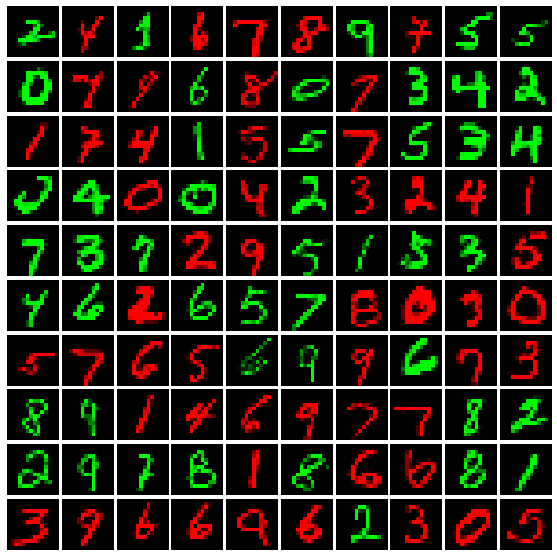

Sequential(
  (0): Linear(in_features=392, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=2, bias=True)
)
Label Accuracy:  0.9434166666666667
Color Accuracy:  1.0


In [2]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader

class MLP(torch.nn.Module):

    def __init__(self, size=[2*14*14, 2]):
        super(MLP, self).__init__()
        layers = []
        for i in range(len(size)-2):
            layers.append(torch.nn.Linear(size[i], size[i+1]))
            layers.append(torch.nn.ReLU())
        layers.append(torch.nn.Linear(size[-2], size[-1]))
        self.net = torch.nn.Sequential(*layers)
        print(self.net)

    def forward(self, x):
        return self.net(x)

def tensor_numpy(arrays, device):
    out = []
    for a in arrays:
        out.append(torch.from_numpy(a).float().to(device))
    return out
    
    
np.random.seed(1)
label_noise = 0.
color_noise = None

y_train = binarize(y_train, label_noise=label_noise)
y_test = binarize(y_test, label_noise=label_noise)

X_train, color_train = color_digits(X_train, y_train, color_noise, downsample=True)
X_test, color_test = color_digits(X_test, y_test, color_noise, downsample=True)

plot_images(X_train)
# plot_images(X_test)

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

hidden_size = [2*14*14, 50, 2]
net = MLP(hidden_size).to(device)

tr_x, tr_y, tr_c = tensor_numpy([X_train, y_train, color_train], device)
te_x, te_y, te_c = tensor_numpy([X_test, y_test, color_test], device)

bs = 256

tr_dataset = TensorDataset(tr_x, tr_y, tr_c)
tr_loader = DataLoader(tr_dataset, batch_size = bs, shuffle = True)
# te_dataset = TensorDataset(te_x, te_y, te_c)
# te_loader = DataLoader(te_dataset, batch_size = bs, shuffle = True)

loss_label = torch.nn.BCEWithLogitsLoss()
loss_color = torch.nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(net.parameters(), lr=1e-3, weight_decay=1e-5)

epoch = 10
for e in range(epoch):
    
    for x, y, c in tr_loader:
        
        optimizer.zero_grad()
        
        out = net(x)
        loss_y = loss_label(out[:,0], y)
        loss_c = loss_color(out[:,1], c)
        loss = loss_y + loss_c
        
        loss.backward()
        optimizer.step()
        
            
with torch.no_grad():
    test_preds = 1*(net(te_x).detach().cpu().numpy()>0)
#     acc_y = (test_preds[:,0] == y_test).mean()
#     acc_c = (test_preds[:,1] == color_test).mean()
    acc_y = accuracy_score(y_test, test_preds[:,0])
    acc_c = accuracy_score(color_test, test_preds[:,1])
    print('Label Accuracy: ', acc_y)
    print('Color Accuracy: ', acc_c)

<br>

# Use the trained feature extractor to extract features from data that will be used to train and test our classifiers

In [3]:
label_noise = 0.
color_noise = None


env1_X_train = mnist_train[0][::2]
env1_y_train = binarize(mnist_train[1][::2], label_noise=label_noise)

env2_X_train = mnist_train[0][1::2]
env2_y_train = binarize(mnist_train[1][1::2], label_noise=label_noise)

env3_X_train = mnist_test[0]
env3_y_train = binarize(mnist_test[1], label_noise=label_noise)

envs = [
generate_environments(env1_X_train, env1_y_train, 0.1),
generate_environments(env2_X_train, env2_y_train, 0.05),
generate_environments(env3_X_train, env3_y_train, 0.9)
]


class feature_extractor(nn.Module):
    def __init__(self):
        super().__init__()   
        net.eval()
        self.children_list = []
        for n,c in net.named_children():
            self.children_list.append(c)
            
        print("Printing all the trained model layers")
        print(self.children_list)
        self.children_list = self.children_list[0][:2]
        print("Printing model layers after dropping the output layer for feature extraction")    
        print(self.children_list)
        self.net = nn.Sequential(*self.children_list)
        self.pretrained = None
        
    def forward(self,x):
        x = self.net(x)
        return x


def extract_features(model,x,y, device = 'cpu'):
    extracted_features = []
    labels = []   
    with torch.no_grad():
        x = x.to(device)
        extracted_features = model(x.float())
    extracted_features = torch.flatten(extracted_features, 1)
    extracted_features_df = pd.DataFrame(extracted_features.numpy())
    extracted_features_df["target"] = y.cpu().numpy()
    return extracted_features_df



train_envs_1_and_2_inputs = torch.cat((torch.from_numpy(envs[0]['images']), torch.from_numpy(envs[1]['images'])), 0)
train_envs_1_and_2_targets = torch.cat((torch.from_numpy(envs[0]['labels']), torch.from_numpy(envs[1]['labels'])), 0)

print("Combined environments 1 and 2 data size - used to train our final prediction models")
print(len(train_envs_1_and_2_inputs))
print(len(train_envs_1_and_2_targets))

test_inputs =torch.from_numpy(envs[2]['images'])
test_targets =torch.from_numpy(envs[2]['labels'])

print("Environment 3 data size - used to test our final prediction models")
print(len(test_inputs))
print(len(test_targets))

feature_extractor = feature_extractor()

train_extracted_features_df = extract_features(feature_extractor,train_envs_1_and_2_inputs, train_envs_1_and_2_targets)
test_extracted_features_df = extract_features(feature_extractor,test_inputs, test_targets)


print("Printing the extracted features - first train features followed by test features shape/size!!!")
# print(train_extracted_features_df)
print(train_extracted_features_df.shape)
# print(test_extracted_features_df)
print(test_extracted_features_df.shape)


Combined environments 1 and 2 data size - used to train our final prediction models
40000
40000
Environment 3 data size - used to test our final prediction models
20000
20000
Printing all the trained model layers
[Sequential(
  (0): Linear(in_features=392, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=2, bias=True)
)]
Printing model layers after dropping the output layer for feature extraction
Sequential(
  (0): Linear(in_features=392, out_features=50, bias=True)
  (1): ReLU()
)
Printing the extracted features - first train features followed by test features shape/size!!!
(40000, 51)
(20000, 51)


In [4]:
# envs = [
# generate_environments(env1_X_train, env1_y_train, 0.2),
# generate_environments(env2_X_train, env2_y_train, 0.4),
# generate_environments(env3_X_train, env3_y_train, 0.9)
# ]

<br>

<br>

# Transforming the extracted image features using a factor model

# Preparing the features that we will need to obtain F and L for.

All images colored green
Color labels for green:
[1 1 1 ... 1 1 1]


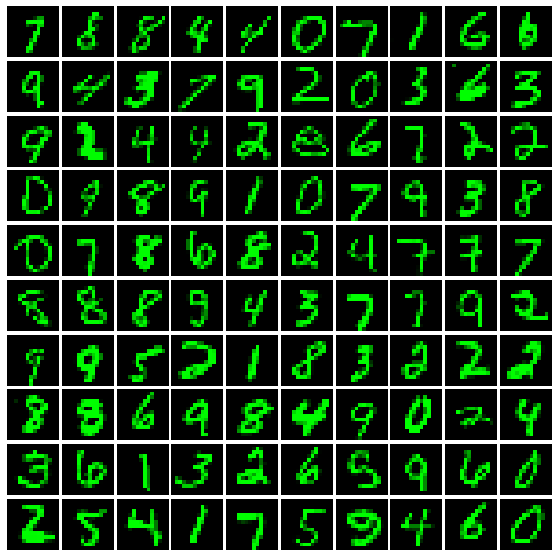

All images colored red
Color labels for red:
[0 0 0 ... 0 0 0]


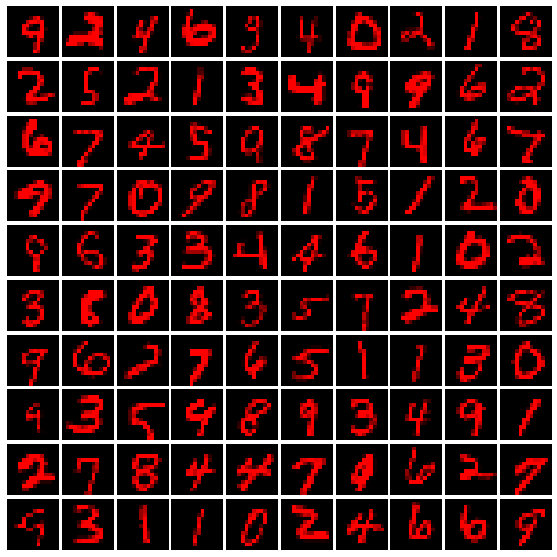

Z shape
(96000, 50)
Z_test shape
(24000, 50)
Z_test_green shape
(12000, 50)
Z_test_red shape
(12000, 50)


In [5]:
X_train_ = mnist_all[0][:int(0.8*len(mnist_all[0]))] 
y_train_ = mnist_all[1][:int(0.8*len(mnist_all[1]))]

X_test_ = mnist_all[0][int(0.8*len(mnist_all[0])):]
y_test_ = mnist_all[1][int(0.8*len(mnist_all[1])):]

y_train_ = binarize(y_train_, label_noise=label_noise)
y_test_ = binarize(y_test_, label_noise=label_noise)

green_images, color_green = produce_images_for_the_factor_model(X_train_, green=True)

red_images, color_red = produce_images_for_the_factor_model(X_train_, green=False)

green_and_red_images = np.concatenate((green_images, red_images), axis=0)
color = np.concatenate((color_green, color_red), axis=None)
label_train = np.concatenate((y_train_, y_train_), axis=None)
    



green_images_test, color_green_test = produce_images_for_the_factor_model(X_test_, green=True)

red_images_test, color_red_test = produce_images_for_the_factor_model(X_test_, green=False)

green_and_red_images_test = np.concatenate((green_images_test, red_images_test), axis=0)
color_test = np.concatenate((color_green_test, color_red_test), axis=None)
label_test = np.concatenate((y_test_, y_test_), axis=None)




print("All images colored green")
print("Color labels for green:")
print(color_green)
plot_images(green_images)


print("All images colored red")
print("Color labels for red:")
print(color_red)
plot_images(red_images)


# extract features from green and red train images
Z = extract_features(feature_extractor,torch.from_numpy(green_and_red_images), 
                                        torch.from_numpy(color)).to_numpy()[:, :-1]



# extract features from green and red test images
Z_test = extract_features(feature_extractor,torch.from_numpy(green_and_red_images_test), 
                                        torch.from_numpy(color_test)).to_numpy()[:, :-1]


# extract features from green test images
Z_test_green = extract_features(feature_extractor,torch.from_numpy(green_images_test), 
                                        torch.from_numpy(color_green_test)).to_numpy()[:, :-1]

# extract features from red test images
Z_test_red = extract_features(feature_extractor,torch.from_numpy(red_images_test), 
                                        torch.from_numpy(color_red_test)).to_numpy()[:, :-1]

# Features from images in environments 1, 2, and 3. Environments 1 and 2 are combined to be used for training. 
Z_envs_1_and_2 = train_extracted_features_df.to_numpy()[:, :-1]
Z_env3 = test_extracted_features_df.to_numpy()[:, :-1]


print("Z shape")
print(Z.shape)

print("Z_test shape")
print(Z_test.shape)

print("Z_test_green shape")
print(Z_test_green.shape)

print("Z_test_red shape")
print(Z_test_red.shape)


# Findind L using a closed form solution

## Obtaining color coefficients

In [6]:
# Using sklearn Logistic Regression
from sklearn.linear_model import LogisticRegression


lr_model = LogisticRegression(random_state=0).fit(Z, color)

color_coefficients = lr_model.coef_.reshape(-1,1)
color_coefficients = color_coefficients / np.linalg.norm(color_coefficients)

print("Printing color coefficients")
print(color_coefficients)
print()
print("Color coefficients shape")
print(color_coefficients.shape)

Printing color coefficients
[[-0.13611737]
 [-0.10290048]
 [-0.09914154]
 [-0.05591476]
 [-0.21016367]
 [ 0.27687923]
 [-0.13959777]
 [ 0.0258377 ]
 [ 0.15144779]
 [ 0.16989472]
 [-0.08701428]
 [-0.25503285]
 [-0.12152722]
 [-0.20009033]
 [ 0.06178284]
 [ 0.16220662]
 [ 0.11287609]
 [ 0.19097206]
 [ 0.1065141 ]
 [-0.16787397]
 [ 0.10320098]
 [ 0.32397624]
 [ 0.00161866]
 [-0.12014511]
 [-0.00979727]
 [ 0.15136336]
 [-0.0553565 ]
 [-0.05051392]
 [ 0.13803003]
 [ 0.07586538]
 [ 0.05887157]
 [-0.1101394 ]
 [ 0.13220928]
 [ 0.18358692]
 [ 0.00441141]
 [-0.09139207]
 [ 0.03898102]
 [-0.03040043]
 [ 0.0165208 ]
 [ 0.09922126]
 [-0.16450361]
 [-0.19563471]
 [ 0.18666445]
 [-0.11699273]
 [-0.06274599]
 [ 0.0845185 ]
 [ 0.15816742]
 [-0.27322376]
 [ 0.1421295 ]
 [ 0.05337996]]

Color coefficients shape
(50, 1)


## Computing M

In [7]:
lamda = 0.01

k = int(Z.shape[1]*0.2) # 20% of original number of features
n = Z.shape[0]


# the difference between Z_green and Z_red in Z
# delta_Z_matrix = (Z[:int(len(color)/2),:] - Z[int(len(color)/2):,:])
delta_Z_matrix = np.absolute((Z[:int(len(color)/2),:] - Z[int(len(color)/2):,:]))

M = - Z.T @ Z/n + lamda * delta_Z_matrix.T @ delta_Z_matrix / (n // 2 ) 
#n M = p.matmul(-Z.transpose(), Z) -   lamda * (Z.transpose() @ Z@ delta_Z_matrix.transpose() @ delta_Z_matrix)
# M = np.matmul(-Z.transpose(), Z) +   lamda * (Z.transpose() @ Z@ delta_Z_matrix.transpose() @ delta_Z_matrix)
# M = np.matmul(-Z.transpose(), Z)/n +   lamda * (Z.transpose() @ Z@ delta_Z_matrix.transpose() @ delta_Z_matrix)/(n // 2 )
M.shape

(50, 50)

## Computing the term on which we will perform SVD

In [8]:
alpha_alpha_T = color_coefficients @ color_coefficients.T
d = alpha_alpha_T.shape[0]
I = np.identity(d)
I_minus_alpa_alpha_T = I-alpha_alpha_T
term_for_SVD = (I_minus_alpa_alpha_T @ M) @ I_minus_alpa_alpha_T
term_for_SVD

array([[-3.81410702, -2.84939357, -2.56601007, ..., -3.68973691,
        -2.83254507, -1.75438938],
       [-2.84939357, -2.88906922, -2.26058588, ..., -3.22717648,
        -2.54446315, -1.4417125 ],
       [-2.56601007, -2.26058588, -2.29132   , ..., -3.08102872,
        -2.38170546, -1.37184977],
       ...,
       [-3.68973691, -3.22717648, -3.08102872, ..., -4.33279766,
        -3.36973312, -2.00782195],
       [-2.83254507, -2.54446315, -2.38170546, ..., -3.36973312,
        -2.98762114, -1.48870331],
       [-1.75438938, -1.4417125 , -1.37184977, ..., -2.00782195,
        -1.48870331, -1.29128629]])

## Performing SVD to get eigenvectors and eigenvalues

In [9]:
from numpy import linalg as LA
eigenvalues, eigenvectors = LA.eigh(term_for_SVD)
display(eigenvalues)
display(eigenvectors)
display(eigenvectors.shape)

array([-1.02021117e+02, -3.98889001e+00, -2.81260479e+00, -2.22386262e+00,
       -1.77716112e+00, -1.44412693e+00, -1.12053870e+00, -1.08254154e+00,
       -7.71923123e-01, -5.87132620e-01, -4.87775535e-01, -4.52743964e-01,
       -3.00672302e-01, -2.57854162e-01, -2.37845906e-01, -1.74687993e-01,
       -1.58706473e-01, -1.56763902e-01, -1.35499456e-01, -1.22031227e-01,
       -1.12942870e-01, -1.02198020e-01, -9.02500883e-02, -8.58817420e-02,
       -6.80502089e-02, -5.36054854e-02, -4.66872663e-02, -4.51146528e-02,
       -3.70141828e-02, -3.26486123e-02, -2.95943206e-02, -2.51330762e-02,
       -2.35001138e-02, -2.06311281e-02, -1.92509659e-02, -1.81297951e-02,
       -1.57050702e-02, -1.40068008e-02, -1.26060701e-02, -1.09851971e-02,
       -8.99792370e-03, -7.11420473e-03, -5.80943026e-03, -4.74324665e-03,
       -3.95081123e-03, -3.02230595e-03, -2.13697211e-03, -1.44498889e-03,
        1.42144242e-15,  3.54302581e-02])

array([[-0.17537351,  0.10329897,  0.18746286, ...,  0.0187336 ,
        -0.13611737,  0.04581528],
       [-0.15439072,  0.26994292, -0.02157806, ...,  0.04330497,
        -0.10290048, -0.02170464],
       [-0.14667524, -0.04006822,  0.07067533, ...,  0.00732053,
        -0.09914154,  0.43192637],
       ...,
       [-0.20546542,  0.00635501,  0.01886238, ...,  0.06638132,
        -0.27322376, -0.3393643 ],
       [-0.16024385,  0.02483235, -0.01633161, ..., -0.00478916,
         0.1421295 ,  0.12200473],
       [-0.09499623, -0.02553965,  0.01210815, ..., -0.01584057,
         0.05337996,  0.05595015]])

(50, 50)

## Forming L from the eigen vectors and alpha

In [10]:
L_1 = color_coefficients
# L_2 = eigenvectors[:,(eigenvectors.shape[1]-k):eigenvectors.shape[1]-1]

least_k_eigen_values = eigenvalues[:k]


least_k_eigen_values[np.absolute(least_k_eigen_values)<0.000001]=0

print("Printing least k eigenvalues before removing the zero eigenvalue")
print(least_k_eigen_values)

non_zero_indeces = None
if 0 in least_k_eigen_values:
    non_zero_indeces = np.nonzero(least_k_eigen_values)[0]
    least_k_eigen_values_without_0 = least_k_eigen_values[non_zero_indeces]
    print("Printing least k eigenvalues after removing the zero eigenvalue")
    print(least_k_eigen_values_without_0)
    
else:
    non_zero_indeces = np.nonzero(least_k_eigen_values[:k-1])[0]
    least_k_eigen_values_without_0 = least_k_eigen_values[:k-1]
    print("Printing least k eigenvalues after removing the zero eigenvalue")
    print(least_k_eigen_values_without_0)

print("Printing non zero indeces of the least k eigenvalues") 
print(non_zero_indeces) #

L_2 = eigenvectors[:,non_zero_indeces]

print(L_2.shape)

L = np.concatenate((L_1, L_2), axis=1)

L.shape

Printing least k eigenvalues before removing the zero eigenvalue
[-102.02111672   -3.98889001   -2.81260479   -2.22386262   -1.77716112
   -1.44412693   -1.1205387    -1.08254154   -0.77192312   -0.58713262]
Printing least k eigenvalues after removing the zero eigenvalue
[-102.02111672   -3.98889001   -2.81260479   -2.22386262   -1.77716112
   -1.44412693   -1.1205387    -1.08254154   -0.77192312]
Printing non zero indeces of the least k eigenvalues
[0 1 2 3 4 5 6 7 8]
(50, 9)


(50, 10)

# Obtaining F_test values from extracted image features using numpy's linalg.lstsq function.

In [11]:
# Documentation of np.linalg.lstsq: https://numpy.org/doc/stable/reference/generated/numpy.linalg.lstsq.html
# F_test = torch.from_numpy(np.linalg.lstsq((L.T).detach().numpy(), Z_test.transpose(), rcond=None)[0].transpose())
# F_test_green = torch.from_numpy(np.linalg.lstsq((L.T).detach().numpy(), Z_test_green.transpose(), rcond=None)[0].transpose())
# F_test_red = torch.from_numpy(np.linalg.lstsq((L.T).detach().numpy(), Z_test_red.transpose(), rcond=None)[0].transpose())

# F_envs_1_and_2 = torch.from_numpy(np.linalg.lstsq((L.T).detach().numpy(), Z_envs_1_and_2.transpose(), rcond=None)[0].transpose())
# F_env3 = torch.from_numpy(np.linalg.lstsq((L.T).detach().numpy(), Z_env3.transpose(), rcond=None)[0].transpose())



F = torch.from_numpy(np.linalg.lstsq(L, Z.transpose(), rcond=None)[0].transpose())
F_test = torch.from_numpy(np.linalg.lstsq(L, Z_test.transpose(), rcond=None)[0].transpose())
F_test_green = torch.from_numpy(np.linalg.lstsq(L, Z_test_green.transpose(), rcond=None)[0].transpose())
F_test_red = torch.from_numpy(np.linalg.lstsq(L, Z_test_red.transpose(), rcond=None)[0].transpose())

F_envs_1_and_2 = torch.from_numpy(np.linalg.lstsq(L, Z_envs_1_and_2.transpose(), rcond=None)[0].transpose())
F_env3 = torch.from_numpy(np.linalg.lstsq(L, Z_env3.transpose(), rcond=None)[0].transpose())



print("F_test shape")
print(F_test.shape)

print("F_test_green shape")
print(F_test_green.shape)

print("F_test_red shape")
print(F_test_red.shape)

print("F_envs_1_and_2 shape")
print(F_envs_1_and_2.shape)

print("F_env3 shape")
print(F_env3.shape)


F_test shape
torch.Size([24000, 10])
F_test_green shape
torch.Size([12000, 10])
F_test_red shape
torch.Size([12000, 10])
F_envs_1_and_2 shape
torch.Size([40000, 10])
F_env3 shape
torch.Size([20000, 10])


# Correlation Matrices

## Correlation Matrix for F

In [12]:
pd.DataFrame(torch.corrcoef(F.T).detach().numpy())

,0,1,2,3,4,5,6,7,8,9
0,1.000000,-0.112963,-0.639373,-0.215889,-0.080965,0.291372,-0.048862,-0.081227,-0.036014,-0.221307
1,-0.112963,1.000000,-0.013993,0.270672,0.151559,0.136617,-0.119021,0.099255,0.044673,0.030219
2,-0.639373,-0.013993,1.000000,0.000208,0.000089,-0.000131,-0.000364,0.000365,0.000140,0.000137
3,-0.215889,0.270672,0.000208,1.000000,-0.004544,-0.002113,0.001732,0.000140,-0.003749,0.002668
4,-0.080965,0.151559,0.000089,-0.004544,1.000000,0.000277,0.000668,-0.001033,0.000961,-0.000249
5,0.291372,0.136617,-0.000131,-0.002113,0.000277,1.000000,0.000395,-0.001237,0.000055,0.000712
6,-0.048862,-0.119021,-0.000364,0.001732,0.000668,0.000395,1.000000,0.002941,0.001868,-0.001900
7,-0.081227,0.099255,0.000365,0.000140,-0.001033,-0.001237,0.002941,1.000000,0.008946,0.000121
8,-0.036014,0.044673,0.000140,-0.003749,0.000961,0.000055,0.001868,0.008946,1.000000,-0.001940
9,-0.221307,0.030219,0.000137,0.002668,-0.000249,0.000712,-0.001900,0.000121,-0.001940,1.000000


## Correlation Matrix for F_test

In [13]:
pd.DataFrame(torch.corrcoef(F_test.T).detach().numpy())

,0,1,2,3,4,5,6,7,8,9
0,1.000000,-0.115271,-0.640361,-0.219668,-0.092401,0.295391,-0.050339,-0.082372,-0.025851,-0.207324
1,-0.115271,1.000000,-0.012621,0.272994,0.156979,0.145634,-0.110416,0.099627,0.042271,0.030462
2,-0.640361,-0.012621,1.000000,0.005547,0.010122,-0.004103,-0.001802,-0.000108,-0.003520,-0.009988
3,-0.219668,0.272994,0.005547,1.000000,0.003142,0.000041,-0.004205,0.001302,-0.006472,-0.002604
4,-0.092401,0.156979,0.010122,0.003142,1.000000,-0.002615,0.003877,-0.000426,0.000693,-0.003228
5,0.295391,0.145634,-0.004103,0.000041,-0.002615,1.000000,0.003813,0.002403,0.008100,0.005140
6,-0.050339,-0.110416,-0.001802,-0.004205,0.003877,0.003813,1.000000,0.010630,0.003407,-0.002328
7,-0.082372,0.099627,-0.000108,0.001302,-0.000426,0.002403,0.010630,1.000000,0.007303,0.002459
8,-0.025851,0.042271,-0.003520,-0.006472,0.000693,0.008100,0.003407,0.007303,1.000000,-0.010200
9,-0.207324,0.030462,-0.009988,-0.002604,-0.003228,0.005140,-0.002328,0.002459,-0.010200,1.000000


## Correlation Matrix for F_test_green

In [14]:
pd.DataFrame(torch.corrcoef(F_test_green.T).detach().numpy())

,0,1,2,3,4,5,6,7,8,9
0,1.000000,-0.939574,-0.359795,-0.225442,-0.225495,0.001933,0.025707,-0.169295,-0.124212,-0.153506
1,-0.939574,1.000000,0.300960,0.365695,0.340559,-0.008312,-0.164989,0.099698,0.002550,0.163193
2,-0.359795,0.300960,1.000000,-0.144544,0.579450,0.858884,-0.029878,0.009104,0.149310,-0.199640
3,-0.225442,0.365695,-0.144544,1.000000,0.474191,-0.160234,-0.032308,-0.143353,-0.023055,-0.137239
4,-0.225495,0.340559,0.579450,0.474191,1.000000,0.473060,-0.455884,0.054732,0.034932,-0.087920
5,0.001933,-0.008312,0.858884,-0.160234,0.473060,1.000000,0.092691,-0.375668,-0.130918,-0.524743
6,0.025707,-0.164989,-0.029878,-0.032308,-0.455884,0.092691,1.000000,-0.085235,0.389692,-0.633854
7,-0.169295,0.099698,0.009104,-0.143353,0.054732,-0.375668,-0.085235,1.000000,0.804934,0.481854
8,-0.124212,0.002550,0.149310,-0.023055,0.034932,-0.130918,0.389692,0.804934,1.000000,0.011642
9,-0.153506,0.163193,-0.199640,-0.137239,-0.087920,-0.524743,-0.633854,0.481854,0.011642,1.000000


## Correlation Matrix for F_test_red

In [15]:
pd.DataFrame(torch.corrcoef(F_test_red.T).detach().numpy())

,0,1,2,3,4,5,6,7,8,9
0,1.000000,0.943761,-0.482040,0.043511,-0.023884,0.376247,-0.054022,0.001728,0.096827,-0.145874
1,0.943761,1.000000,-0.524208,0.058358,0.031682,0.400605,-0.063901,0.109384,0.124278,-0.079253
2,-0.482040,-0.524208,1.000000,-0.105796,-0.451052,-0.626191,-0.042358,-0.083129,-0.342536,-0.104627
3,0.043511,0.058358,-0.105796,1.000000,-0.703399,0.591194,0.024795,0.065247,0.050977,0.074662
4,-0.023884,0.031682,-0.451052,-0.703399,1.000000,-0.306710,0.289084,-0.017488,-0.042307,0.011722
5,0.376247,0.400605,-0.626191,0.591194,-0.306710,1.000000,-0.066642,0.164684,0.313689,0.433303
6,-0.054022,-0.063901,-0.042358,0.024795,0.289084,-0.066642,1.000000,0.036493,-0.727730,0.350602
7,0.001728,0.109384,-0.083129,0.065247,-0.017488,0.164684,0.036493,1.000000,-0.456175,-0.100029
8,0.096827,0.124278,-0.342536,0.050977,-0.042307,0.313689,-0.727730,-0.456175,1.000000,-0.044035
9,-0.145874,-0.079253,-0.104627,0.074662,0.011722,0.433303,0.350602,-0.100029,-0.044035,1.000000


## Correlation Matrix for F_envs_1_and_2

In [16]:
pd.DataFrame(torch.corrcoef(F_envs_1_and_2.T).detach().numpy())

,0,1,2,3,4,5,6,7,8,9
0,1.000000,-0.073237,-0.703621,0.376212,-0.390609,0.397625,0.262025,-0.259772,-0.147570,-0.213416
1,-0.073237,1.000000,-0.084055,0.108865,0.043033,0.242375,-0.087219,0.081662,0.146216,0.060085
2,-0.703621,-0.084055,1.000000,-0.384271,0.040507,-0.466960,-0.241485,0.228305,0.042311,-0.007089
3,0.376212,0.108865,-0.384271,1.000000,-0.304866,0.226760,0.097117,-0.045843,0.282782,-0.128876
4,-0.390609,0.043033,0.040507,-0.304866,1.000000,-0.195226,0.267837,0.101564,0.009424,0.212376
5,0.397625,0.242375,-0.466960,0.226760,-0.195226,1.000000,-0.038328,-0.179155,-0.017673,0.197499
6,0.262025,-0.087219,-0.241485,0.097117,0.267837,-0.038328,1.000000,0.025130,0.005367,0.128213
7,-0.259772,0.081662,0.228305,-0.045843,0.101564,-0.179155,0.025130,1.000000,0.289261,0.120257
8,-0.147570,0.146216,0.042311,0.282782,0.009424,-0.017673,0.005367,0.289261,1.000000,0.024644
9,-0.213416,0.060085,-0.007089,-0.128876,0.212376,0.197499,0.128213,0.120257,0.024644,1.000000


## Correlation Matrix for F_env3

In [17]:
pd.DataFrame(torch.corrcoef(F_env3.T).detach().numpy())

,0,1,2,3,4,5,6,7,8,9
0,1.000000,-0.144808,-0.601842,-0.576665,0.235122,0.196525,-0.363504,0.009618,0.131599,-0.255470
1,-0.144808,1.000000,0.044924,0.372420,0.268353,0.065239,-0.143027,0.117675,-0.105541,0.001751
2,-0.601842,0.044924,1.000000,0.289661,0.043321,0.373324,0.279895,-0.145276,-0.055861,-0.114276
3,-0.576665,0.372420,0.289661,1.000000,0.146477,-0.084960,-0.082616,0.025862,-0.289626,0.186667
4,0.235122,0.268353,0.043321,0.146477,1.000000,0.297683,-0.330058,-0.042962,-0.022930,-0.137324
5,0.196525,0.065239,0.373324,-0.084960,0.297683,1.000000,0.069094,0.078680,0.037705,-0.368422
6,-0.363504,-0.143027,0.279895,-0.082616,-0.330058,0.069094,1.000000,0.005185,-0.010267,-0.167767
7,0.009618,0.117675,-0.145276,0.025862,-0.042962,0.078680,0.005185,1.000000,-0.239700,-0.113256
8,0.131599,-0.105541,-0.055861,-0.289626,-0.022930,0.037705,-0.010267,-0.239700,1.000000,-0.044304
9,-0.255470,0.001751,-0.114276,0.186667,-0.137324,-0.368422,-0.167767,-0.113256,-0.044304,1.000000


# Histograms

Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9
0,13.997089,0.059184,4.156983,0.737175,2.753689,2.792874,0.557405,0.556640,0.910888,1.346153
1,10.772082,0.077568,3.560524,0.894868,0.437657,0.978183,0.470146,1.902339,1.944744,0.720444
2,20.465802,0.149831,4.553119,0.751651,1.666742,0.627659,0.393983,1.149787,0.339278,1.651629
3,24.265408,0.890620,7.525760,0.348649,1.535842,0.050764,0.358937,1.693084,1.280438,0.680526
4,18.719481,1.331399,7.091744,3.533552,3.403310,1.379302,0.474662,0.779263,1.896236,0.307932


Histogram for F Test feature  0


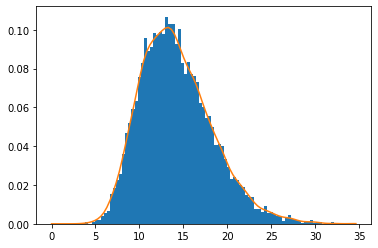

Histogram for F Test feature  1


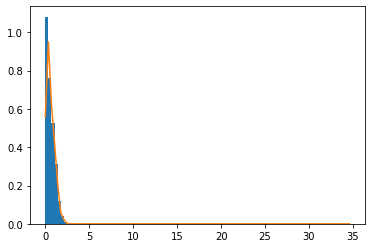

Histogram for F Test feature  2


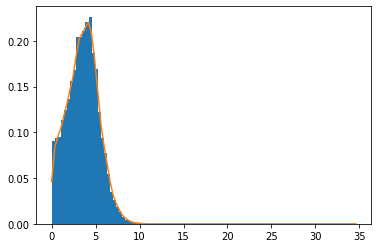

Histogram for F Test feature  3


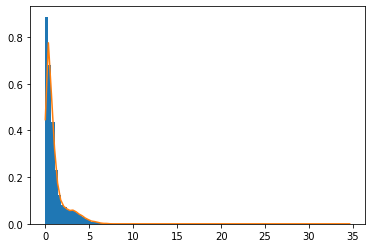

Histogram for F Test feature  4


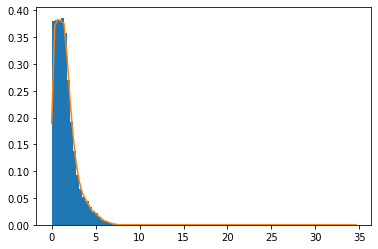

Histogram for F Test feature  5


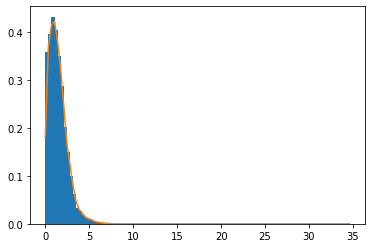

Histogram for F Test feature  6


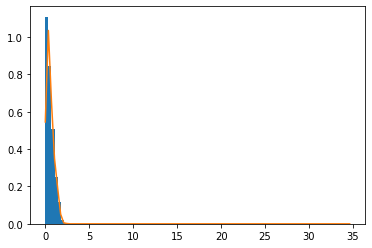

Histogram for F Test feature  7


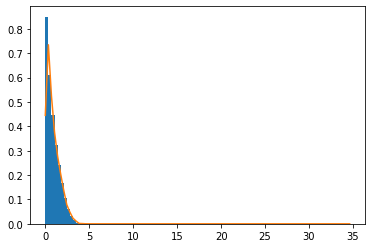

Histogram for F Test feature  8


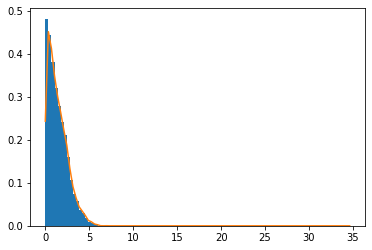

Histogram for F Test feature  9


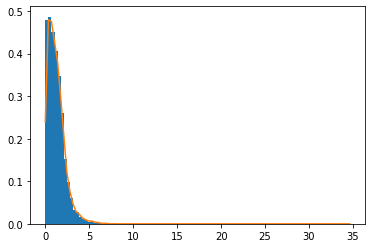

In [18]:
# the difference between F_test_green and F_test_red
delta_matrix = np.absolute(F_test_green.detach().numpy() - F_test_red.detach().numpy())

print("Printing the delta matrix")
delta_matrix_df = pd.DataFrame(delta_matrix)
display(delta_matrix_df.head())

# Plotting the histograms for each feature in the delta matrix # 100 bins
for i in range(len(delta_matrix_df.columns)): 
    print("Histogram for F Test feature ", i)    
    feature = delta_matrix_df.iloc[:,i].values
    density = stats.gaussian_kde(feature)
#     n, x, _ = plt.hist(feature, bins=np.linspace(np.amin(delta_matrix_df.iloc[:,i]), np.amax(delta_matrix_df.iloc[:,i]), 100), 
#                        histtype='bar', density=True)  
    n, x, _ = plt.hist(feature, bins=np.linspace(0, np.amax(delta_matrix_df.iloc[:,0]), 100), 
                       histtype='bar', density=True)  
    plt.plot(x, density(x))
    plt.show()


# Prediction Accuracies on extracted image features Z ( features obtained from the feature extractor)

In [19]:
# Trained on original extracted image features Z, tested on contrasted extracted image features Z
from sklearn.linear_model import LogisticRegression

import torch
from sklearn import preprocessing



train_data_path = train_extracted_features_df
test_data_path = test_extracted_features_df


def read_data(path):
    data_df = path.to_numpy()

    targets = data_df[:, -1] 
    X = data_df[:, :-1] 

    # Standardize the data
    sscaler = preprocessing.StandardScaler()
    sscaler.fit(X)
    X = sscaler.transform(X)


    X_torch = torch.from_numpy(X)
    targets_torch = torch.from_numpy(targets)
    return X_torch, targets_torch



_, targets_torch_train = read_data(train_data_path)
_, targets_torch_test = read_data(test_data_path)


targets_train = targets_torch_train.reshape(-1,1).numpy()
targets_test = targets_torch_test.reshape(-1,1).numpy()




# targets_train = np.array(test_dataset.targets)
# targets_test = np.array(test_dataset.targets)


logistic_regression_model = LogisticRegression(random_state=0).fit(Z_envs_1_and_2, targets_train)

print('LR Accuracy within training data - Z envs 1 and 2 features: ',logistic_regression_model.score(Z_envs_1_and_2, targets_train))
print('LR Accuracy on test data - Z env 3 features: ', logistic_regression_model.score(Z_env3, targets_test))



/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LR Accuracy within training data - Z envs 1 and 2 features:  0.977575
LR Accuracy on test data - Z env 3 features:  0.8318


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Predicting label when trained on all F_envs_1_and_2 and tested on all F_env3 features including color - Environment Shift Present - Logistic Regression

In [20]:
# Using sklearn Logistic Regression
from sklearn.linear_model import LogisticRegression

import torch
from sklearn import preprocessing



train_data_path = train_extracted_features_df
test_data_path = test_extracted_features_df


def read_data(path):
    data_df = path.to_numpy()

    targets = data_df[:, -1] 
    X = data_df[:, :-1] 

    # Standardize the data
    sscaler = preprocessing.StandardScaler()
    sscaler.fit(X)
    X = sscaler.transform(X)


    X_torch = torch.from_numpy(X)
    targets_torch = torch.from_numpy(targets)
    return X_torch, targets_torch



_, targets_torch_train = read_data(train_data_path)
_, targets_torch_test = read_data(test_data_path)


X_torch_train = F_envs_1_and_2
X_torch_test = F_env3
X_torch_test_within = F_envs_1_and_2

targets_torch_train = targets_torch_train.reshape(-1,1)
targets_torch_test = targets_torch_test.reshape(-1,1)
targets_torch_test_within = targets_torch_train.reshape(-1,1)


print("Printing the shape of the input!")
print(X_torch_train.shape)

print("Printing the shape of the target!")
print(targets_torch_train.shape)


logistic_regression_model = LogisticRegression(random_state=0).fit(X_torch_train.detach().numpy(), targets_torch_train.numpy())

print('Logistic Regression Accuracy within training data: ',logistic_regression_model.score(X_torch_test_within.detach().numpy(), targets_torch_test_within.numpy()))
print('Logistic Regression Accuracy on test data: ', logistic_regression_model.score(X_torch_test.detach().numpy(), targets_torch_test.numpy()))




/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Printing the shape of the input!
torch.Size([40000, 10])
Printing the shape of the target!
torch.Size([40000, 1])
Logistic Regression Accuracy within training data:  0.9754
Logistic Regression Accuracy on test data:  0.81435


# Predicting label when trained on all F_envs_1_and_2 and tested on all F_env3 features except color - Environment Shift Present - Logistic Regression

In [21]:
# Using sklearn Logistic Regression
from sklearn.linear_model import LogisticRegression

import torch
from sklearn import preprocessing



train_data_path = train_extracted_features_df
test_data_path = test_extracted_features_df


def read_data(path):
    data_df = path.to_numpy()

    targets = data_df[:, -1] 
    X = data_df[:, :-1] 

    # Standardize the data
    sscaler = preprocessing.StandardScaler()
    sscaler.fit(X)
    X = sscaler.transform(X)


    X_torch = torch.from_numpy(X)
    targets_torch = torch.from_numpy(targets)
    return X_torch, targets_torch



_, targets_torch_train = read_data(train_data_path)
_, targets_torch_test = read_data(test_data_path)


# X_torch_train = F_envs_1_and_2[:,1:]
# X_torch_test = F_env3[:,1:]
# X_torch_test_within = F_envs_1_and_2[:,1:]

targets_torch_train = targets_torch_train.reshape(-1,1)
targets_torch_test = targets_torch_test.reshape(-1,1)
targets_torch_test_within = targets_torch_train.reshape(-1,1)


# print("Printing the shape of the input!")
# print(X_torch_train.shape)

# print("Printing the shape of the target!")
# print(targets_torch_train.shape)

for i in range(F_envs_1_and_2.detach().numpy().shape[1]):
    print("Accuracy for without feature ",i)
    
    X_torch_train = F_envs_1_and_2.detach().numpy().copy()
    X_torch_test = F_env3.detach().numpy().copy()
    X_torch_test_within = F_envs_1_and_2.detach().numpy().copy()
    
    X_torch_train = np.delete(X_torch_train, i, 1)
    X_torch_test = np.delete(X_torch_test, i, 1)
    X_torch_test_within = np.delete(X_torch_test_within, i, 1)


    logistic_regression_model = LogisticRegression(random_state=0).fit(X_torch_train, targets_torch_train.numpy())

    print('Logistic Regression Accuracy within training data: ',logistic_regression_model.score(X_torch_test_within, targets_torch_test_within.numpy()))
    print('Logistic Regression Accuracy on test data: ', logistic_regression_model.score(X_torch_test, targets_torch_test.numpy()))




Accuracy for without feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.95705
Logistic Regression Accuracy on test data:  0.88055
Accuracy for without feature  1


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.97535
Logistic Regression Accuracy on test data:  0.81325
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.97535
Logistic Regression Accuracy on test data:  0.81425
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.952775
Logistic Regression Accuracy on test data:  0.5307
Accuracy for without feature  4
Logistic Regression Accuracy within training data:  0.9623
Logistic Regression Accuracy on test data:  0.66435
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.975625
Logistic Regression Accuracy on test data:  0.8094
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.95155
Logistic Regression Accuracy on test data:  0.53825
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.974775
Logistic Regression Accuracy on test data:  0.80905
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.975025
Logistic Regression Accuracy on test data:  0.81075
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.975475
Logistic Regression Accuracy on test data:  0.81495


# Predicting label using all F_train and F_test features including color - No Environment Shift (Logistic Regression)

In [22]:
# Using sklearn Logistic Regression
from sklearn.linear_model import LogisticRegression

import torch
from sklearn import preprocessing


X_torch_train = F
X_torch_test = F_test
X_torch_test_within = F

targets_torch_train = torch.from_numpy(label_train)
targets_torch_test = torch.from_numpy(label_test)
targets_torch_test_within = torch.from_numpy(label_train)


targets_torch_train = targets_torch_train.reshape(-1,1)
targets_torch_test = targets_torch_test.reshape(-1,1)
targets_torch_test_within = targets_torch_test_within.reshape(-1,1)


print("Printing the shape of the input!")
print(X_torch_train.shape)

print("Printing the shape of the target!")
print(targets_torch_train.shape)


logistic_regression_model = LogisticRegression(random_state=0).fit(X_torch_train.detach().numpy(), targets_torch_train.numpy())

print('Logistic Regression Accuracy within training data: ',logistic_regression_model.score(X_torch_test_within.detach().numpy(), targets_torch_test_within.numpy()))
print('Logistic Regression Accuracy on test data: ', logistic_regression_model.score(X_torch_test.detach().numpy(), targets_torch_test.numpy()))



Printing the shape of the input!
torch.Size([96000, 10])
Printing the shape of the target!
torch.Size([96000, 1])


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9465416666666666
Logistic Regression Accuracy on test data:  0.94025



# Predicting Label Using all F_train and F_test Features Except Color - No Environment Shift (Logistic Regression)

In [23]:
# Using sklearn Logistic Regression
from sklearn.linear_model import LogisticRegression

import torch
from sklearn import preprocessing


X_torch_train = F[:,1:]
X_torch_test = F_test[:,1:]
X_torch_test_within = F[:,1:]

targets_torch_train = torch.from_numpy(label_train)
targets_torch_test = torch.from_numpy(label_test)
targets_torch_test_within = torch.from_numpy(label_train)


targets_torch_train = targets_torch_train.reshape(-1,1)
targets_torch_test = targets_torch_test.reshape(-1,1)
targets_torch_test_within = targets_torch_test_within.reshape(-1,1)


print("Printing the shape of the input!")
print(X_torch_train.shape)

print("Printing the shape of the target!")
print(targets_torch_train.shape)


logistic_regression_model = LogisticRegression(random_state=0).fit(X_torch_train.detach().numpy(), targets_torch_train.numpy())

print('Logistic Regression Accuracy within training data: ',logistic_regression_model.score(X_torch_test_within.detach().numpy(), targets_torch_test_within.numpy()))
print('Logistic Regression Accuracy on test data: ', logistic_regression_model.score(X_torch_test.detach().numpy(), targets_torch_test.numpy()))


Printing the shape of the input!
torch.Size([96000, 9])
Printing the shape of the target!
torch.Size([96000, 1])


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9448333333333333
Logistic Regression Accuracy on test data:  0.9395


<br>

# Getting Results for Different values of Lamda





Results for lamda  100000



array([-2.41404025e-10,  2.68980948e+02,  3.86625390e+02,  5.23014322e+02,
        5.70238216e+02,  8.74753103e+02,  1.11927059e+03,  1.51496881e+03,
        1.93418740e+03,  2.03638634e+03,  2.45149527e+03,  2.50741469e+03,
        2.89194025e+03,  3.12864943e+03,  3.52150893e+03,  3.66715753e+03,
        3.92607199e+03,  4.70904915e+03,  4.86912226e+03,  5.24164279e+03,
        5.61674515e+03,  6.41331575e+03,  6.51303937e+03,  7.50354729e+03,
        7.99804765e+03,  8.55859573e+03,  9.57036263e+03,  1.09345508e+04,
        1.09791690e+04,  1.30525737e+04,  1.51094053e+04,  1.65228692e+04,
        1.73591072e+04,  1.91693814e+04,  2.08652889e+04,  2.26082880e+04,
        2.51913434e+04,  2.73508800e+04,  3.30001926e+04,  3.68646298e+04,
        3.89925193e+04,  3.98549658e+04,  6.06689365e+04,  7.76886568e+04,
        1.24273980e+05,  1.58315933e+05,  1.79060744e+05,  2.87290165e+05,
        3.25723619e+05,  2.38760213e+07])

array([[-0.13611737,  0.02192648,  0.01078059, ...,  0.01337794,
        -0.00940483,  0.18764232],
       [-0.10290048,  0.0124076 , -0.00086632, ...,  0.26912426,
         0.28144391,  0.14425744],
       [-0.09914154,  0.1051144 ,  0.02687542, ..., -0.04444291,
         0.09462159,  0.09077572],
       ...,
       [-0.27322376, -0.02425594,  0.03359892, ...,  0.00506551,
        -0.01933852,  0.27509259],
       [ 0.1421295 ,  0.01782705, -0.00064391, ..., -0.23021656,
         0.03464304,  0.13426329],
       [ 0.05337996, -0.00040828, -0.00242343, ..., -0.0048315 ,
         0.08089728,  0.06626703]])

Printing least k eigenvalues before removing the zero eigenvalue
[   0.          268.98094808  386.62539024  523.01432247  570.23821635
  874.75310265 1119.27059198 1514.96880597 1934.1874003  2036.38634194]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[ 268.98094808  386.62539024  523.01432247  570.23821635  874.75310265
 1119.27059198 1514.96880597 1934.1874003  2036.38634194]
Printing non zero indeces of the least k-1 eigenvalues
[1 2 3 4 5 6 7 8 9]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9
0,13.997089,0.149328,0.008958,0.330542,0.006367,0.012809,0.035679,0.612962,0.596806,0.796464
1,10.772082,0.247268,0.252166,0.068414,0.376191,0.106896,0.376287,0.147056,0.405986,0.010783
2,20.465802,0.058340,0.126189,0.314241,0.144584,0.527114,0.312980,1.046834,0.556475,1.499681
3,24.265408,0.123519,0.120479,0.007644,0.090439,0.243046,0.672700,1.197176,0.614769,0.378978
4,18.719481,0.186141,0.070238,0.862100,0.175206,0.102160,0.168949,0.269698,0.002778,0.207248


Histogram for F Test feature  0


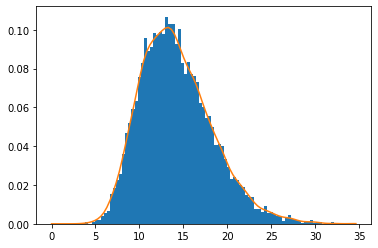

Histogram for F Test feature  1


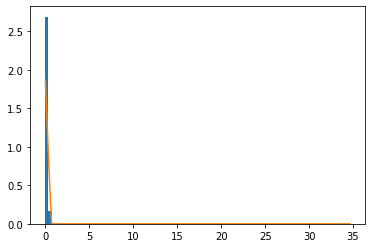

Histogram for F Test feature  2


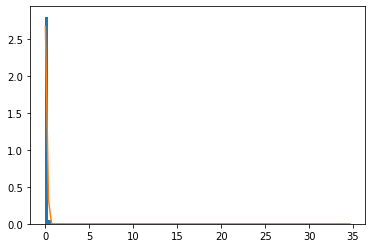

Histogram for F Test feature  3


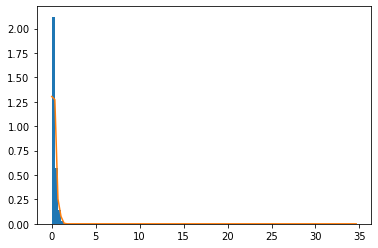

Histogram for F Test feature  4


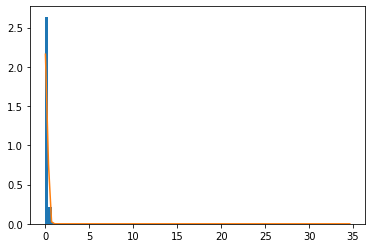

Histogram for F Test feature  5


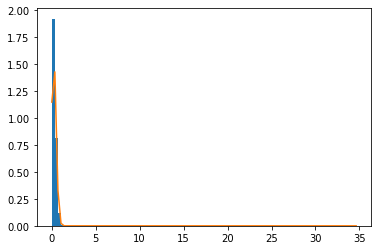

Histogram for F Test feature  6


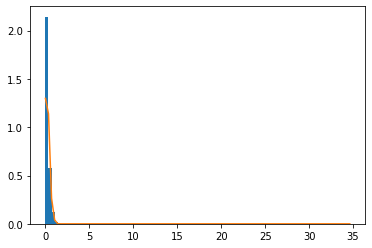

Histogram for F Test feature  7


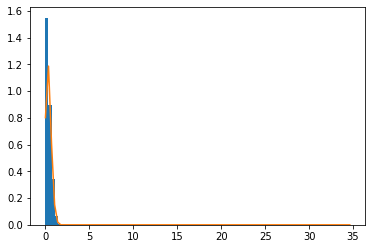

Histogram for F Test feature  8


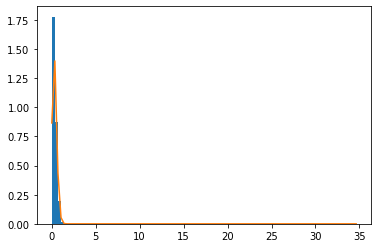

Histogram for F Test feature  9


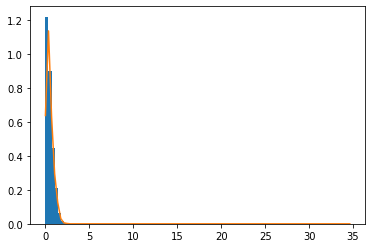

Printing the shape of the input!
torch.Size([40000, 10])
Printing the shape of the target!
torch.Size([40000, 1])


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d arr

LR Accuracy within training data - All features :  0.929075
LR Accuracy on test data - All features:  0.2337
Accuracy for without feature  0
Logistic Regression Accuracy within training data:  0.871975
Logistic Regression Accuracy on test data:  0.47345
Accuracy for without feature  1


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9286
Logistic Regression Accuracy on test data:  0.23365
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d arr

Logistic Regression Accuracy within training data:  0.928925
Logistic Regression Accuracy on test data:  0.23505
Accuracy for without feature  3
Logistic Regression Accuracy within training data:  0.926125
Logistic Regression Accuracy on test data:  0.1892
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.92835
Logistic Regression Accuracy on test data:  0.2184
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.925625
Logistic Regression Accuracy on test data:  0.13865
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.928475
Logistic Regression Accuracy on test data:  0.22905
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.92875
Logistic Regression Accuracy on test data:  0.23145
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d arr

Logistic Regression Accuracy within training data:  0.9287
Logistic Regression Accuracy on test data:  0.2321
Accuracy for without feature  9
Logistic Regression Accuracy within training data:  0.930075
Logistic Regression Accuracy on test data:  0.2218




Results for lamda  10



array([-4.34832706e+00, -3.03589534e+00, -1.02276717e+00, -4.68362345e-01,
       -3.26805121e-01, -6.75752148e-02, -1.25811830e-02, -7.24527943e-14,
        2.41090940e-02,  3.44429077e-02,  4.60888964e-02,  5.15947119e-02,
        8.89885630e-02,  1.04470524e-01,  1.39390929e-01,  1.71300481e-01,
        2.19951773e-01,  2.39259710e-01,  2.48315427e-01,  2.86209389e-01,
        3.35871964e-01,  3.73550156e-01,  4.01841868e-01,  4.53291043e-01,
        5.25060034e-01,  6.47985687e-01,  6.94632906e-01,  7.64620327e-01,
        9.11819127e-01,  1.04635975e+00,  1.15873846e+00,  1.33828317e+00,
        1.41366507e+00,  1.52028992e+00,  1.79569623e+00,  1.92357315e+00,
        2.17279599e+00,  2.43242622e+00,  2.97327905e+00,  3.11742488e+00,
        3.52062156e+00,  3.70970657e+00,  5.36101818e+00,  6.66600600e+00,
        1.11560024e+01,  1.51665963e+01,  1.71633647e+01,  2.78854335e+01,
        3.18509695e+01,  2.28894737e+03])

array([[-0.00849653,  0.03557131, -0.15400126, ...,  0.01278879,
        -0.0105946 ,  0.18791848],
       [ 0.08189361,  0.21363668, -0.0335564 , ...,  0.24942777,
         0.29970413,  0.14364722],
       [ 0.31705495, -0.00090055, -0.17268246, ..., -0.0540093 ,
         0.1006672 ,  0.08823953],
       ...,
       [-0.23475975,  0.00307978,  0.1243661 , ...,  0.0077183 ,
        -0.02312381,  0.27776554],
       [ 0.14000613,  0.04009521,  0.00865104, ..., -0.23253969,
         0.01766978,  0.13297438],
       [ 0.09058129, -0.05419033, -0.1291038 , ..., -0.01387241,
         0.0794592 ,  0.06494362]])

Printing least k eigenvalues before removing the zero eigenvalue
[-4.34832706 -3.03589534 -1.02276717 -0.46836234 -0.32680512 -0.06757521
 -0.01258118  0.          0.02410909  0.03444291]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-4.34832706 -3.03589534 -1.02276717 -0.46836234 -0.32680512 -0.06757521
 -0.01258118  0.02410909  0.03444291]
Printing non zero indeces of the least k-1 eigenvalues
[0 1 2 3 4 5 6 8 9]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9
0,13.997089,0.866122,4.318474,3.197917,1.236515,0.202324,1.156666,1.160419,0.131386,0.058075
1,10.772082,0.232561,3.365723,1.041509,1.025723,2.377150,0.685884,0.274789,0.373868,0.139304
2,20.465802,0.079963,4.577508,0.747860,0.506553,0.659060,2.851858,0.360774,0.249111,0.277175
3,24.265408,0.826485,7.106227,2.011658,0.206329,0.679590,0.186661,2.403482,0.512546,0.048387
4,18.719481,2.981560,7.179816,4.053287,0.032824,1.762653,0.931815,0.542974,0.123738,0.028537


Histogram for F Test feature  0


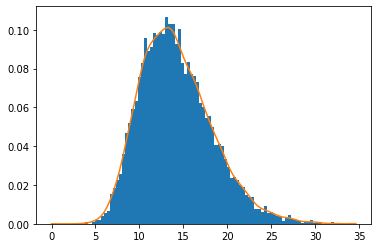

Histogram for F Test feature  1


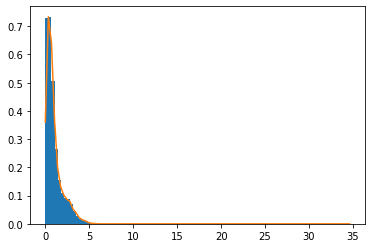

Histogram for F Test feature  2


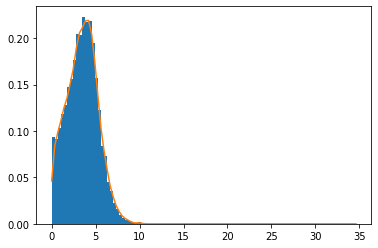

Histogram for F Test feature  3


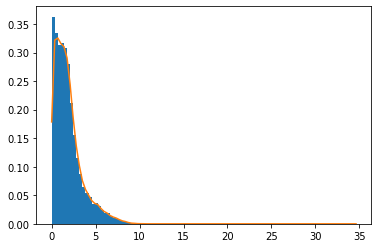

Histogram for F Test feature  4


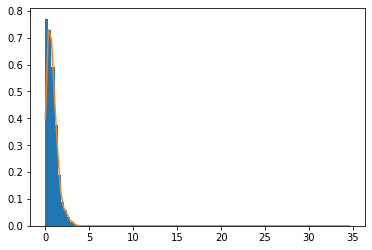

Histogram for F Test feature  5


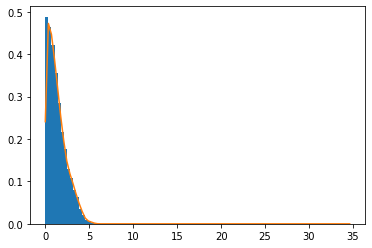

Histogram for F Test feature  6


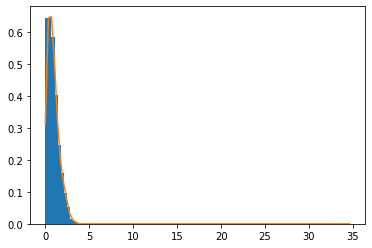

Histogram for F Test feature  7


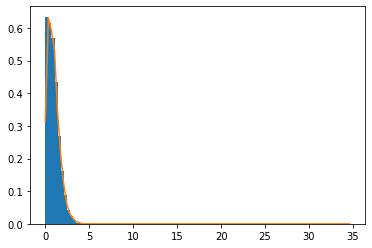

Histogram for F Test feature  8


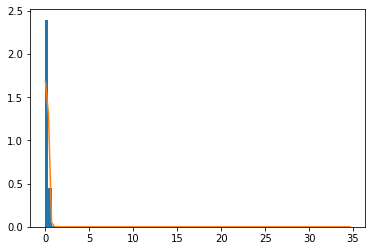

Histogram for F Test feature  9


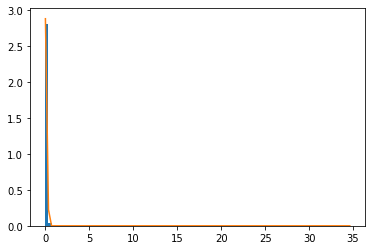

Printing the shape of the input!
torch.Size([40000, 10])
Printing the shape of the target!
torch.Size([40000, 1])


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LR Accuracy within training data - All features :  0.945725
LR Accuracy on test data - All features:  0.46455
Accuracy for without feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9245
Logistic Regression Accuracy on test data:  0.6084
Accuracy for without feature  1
Logistic Regression Accuracy within training data:  0.94515
Logistic Regression Accuracy on test data:  0.46345
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.94535
Logistic Regression Accuracy on test data:  0.46005
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.94575
Logistic Regression Accuracy on test data:  0.46235
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.928925
Logistic Regression Accuracy on test data:  0.2151
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.941875
Logistic Regression Accuracy on test data:  0.4057
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9426
Logistic Regression Accuracy on test data:  0.43485
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.944025
Logistic Regression Accuracy on test data:  0.4439
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9432
Logistic Regression Accuracy on test data:  0.4301
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9342
Logistic Regression Accuracy on test data:  0.30605




Results for lamda  9



array([-4.51595419e+00, -3.11400044e+00, -1.10887260e+00, -5.30745545e-01,
       -3.88930701e-01, -9.48230337e-02, -5.18462495e-02, -6.97380879e-14,
        1.91663185e-02,  2.89978194e-02,  3.62907801e-02,  4.38069984e-02,
        6.80574077e-02,  8.71337001e-02,  1.08563520e-01,  1.42401108e-01,
        1.88974776e-01,  2.06009237e-01,  2.10299247e-01,  2.47190275e-01,
        2.90570878e-01,  3.26869294e-01,  3.54377130e-01,  3.94704542e-01,
        4.51267009e-01,  5.71779373e-01,  6.10049616e-01,  6.74253686e-01,
        8.05702150e-01,  9.11097122e-01,  1.02832507e+00,  1.18754543e+00,
        1.25283824e+00,  1.35093229e+00,  1.59885084e+00,  1.71208092e+00,
        1.92066830e+00,  2.16615090e+00,  2.64920928e+00,  2.75967099e+00,
        3.14281653e+00,  3.31983866e+00,  4.76503638e+00,  5.90089664e+00,
        9.92123426e+00,  1.35954124e+01,  1.53804349e+01,  2.50112358e+01,
        2.85981495e+01,  2.05021300e+03])

array([[-0.00984934,  0.03880831, -0.15262377, ...,  0.01274396,
        -0.01074956,  0.18794921],
       [ 0.07999616,  0.21616386, -0.03079988, ...,  0.24725572,
         0.30159294,  0.14357545],
       [ 0.30788446,  0.00030835, -0.16059372, ..., -0.05514624,
         0.10128076,  0.08794438],
       ...,
       [-0.23553964,  0.00089235,  0.12095691, ...,  0.00803455,
        -0.02353132,  0.27807417],
       [ 0.14129024,  0.04208776,  0.00931032, ..., -0.23270087,
         0.01582509,  0.13282383],
       [ 0.09438475, -0.05249813, -0.13291552, ..., -0.01484523,
         0.07925078,  0.0647895 ]])

Printing least k eigenvalues before removing the zero eigenvalue
[-4.51595419 -3.11400044 -1.1088726  -0.53074555 -0.3889307  -0.09482303
 -0.05184625  0.          0.01916632  0.02899782]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-4.51595419 -3.11400044 -1.1088726  -0.53074555 -0.3889307  -0.09482303
 -0.05184625  0.01916632  0.02899782]
Printing non zero indeces of the least k-1 eigenvalues
[0 1 2 3 4 5 6 8 9]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9
0,13.997089,0.798655,4.327746,3.211453,1.300334,0.123730,1.062972,1.437777,0.206803,0.112907
1,10.772082,0.237521,3.375432,1.085943,0.866224,2.466310,0.664245,0.219572,0.413460,0.129426
2,20.465802,0.137947,4.583782,0.776588,0.564766,0.591556,2.949524,0.262054,0.260335,0.263517
3,24.265408,0.919654,7.131281,1.998258,0.105616,0.747196,0.106267,2.581433,0.417323,0.089131
4,18.719481,3.007558,7.149417,4.124923,0.109127,1.794688,0.882408,0.703165,0.174263,0.059530


Histogram for F Test feature  0


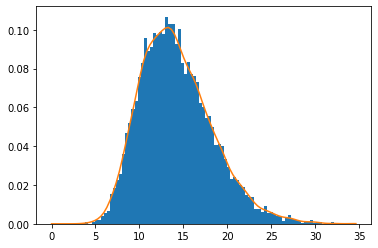

Histogram for F Test feature  1


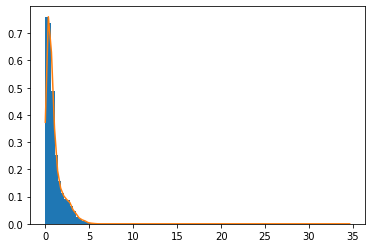

Histogram for F Test feature  2


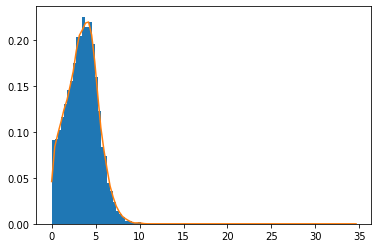

Histogram for F Test feature  3


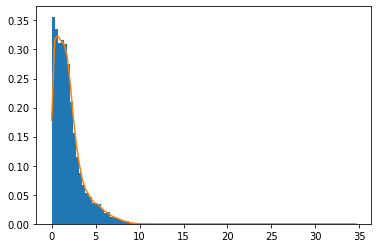

Histogram for F Test feature  4


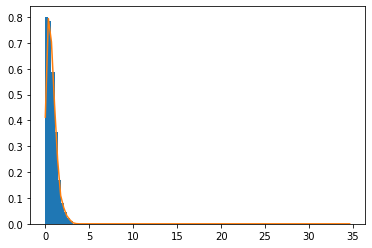

Histogram for F Test feature  5


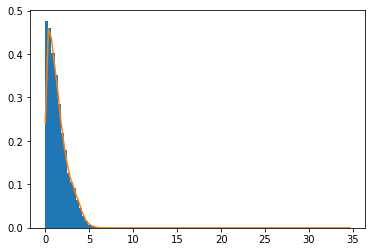

Histogram for F Test feature  6


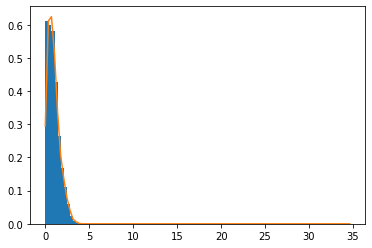

Histogram for F Test feature  7


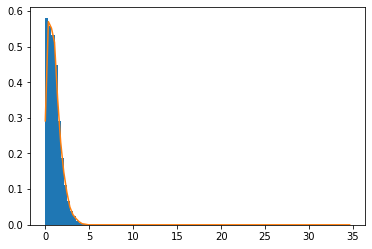

Histogram for F Test feature  8


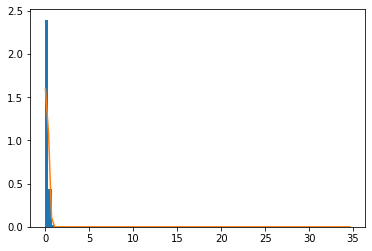

Histogram for F Test feature  9


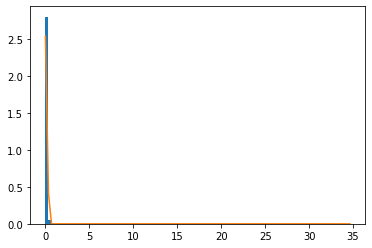

Printing the shape of the input!
torch.Size([40000, 10])
Printing the shape of the target!
torch.Size([40000, 1])


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LR Accuracy within training data - All features :  0.95085
LR Accuracy on test data - All features:  0.5354
Accuracy for without feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9349
Logistic Regression Accuracy on test data:  0.67535
Accuracy for without feature  1


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.949225
Logistic Regression Accuracy on test data:  0.5254
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.949975
Logistic Regression Accuracy on test data:  0.5258
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.949725
Logistic Regression Accuracy on test data:  0.5224
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.931975
Logistic Regression Accuracy on test data:  0.27475
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.948675
Logistic Regression Accuracy on test data:  0.4886
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.946425
Logistic Regression Accuracy on test data:  0.49385
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.951975
Logistic Regression Accuracy on test data:  0.5371
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.949675
Logistic Regression Accuracy on test data:  0.51295
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.936225
Logistic Regression Accuracy on test data:  0.33425




Results for lamda  8



array([-4.69827323e+00, -3.19376185e+00, -1.19816172e+00, -5.99804879e-01,
       -4.53221998e-01, -1.26280785e-01, -9.96328108e-02, -3.39709294e-14,
        1.27396152e-02,  2.00267307e-02,  2.65213288e-02,  3.70097403e-02,
        4.41715647e-02,  7.01240454e-02,  8.15668744e-02,  1.14887584e-01,
        1.52101998e-01,  1.69343535e-01,  1.80638201e-01,  2.09114368e-01,
        2.48715593e-01,  2.81007798e-01,  3.07697350e-01,  3.37337372e-01,
        3.79517801e-01,  4.96005226e-01,  5.26574591e-01,  5.85027139e-01,
        6.99630818e-01,  7.78710885e-01,  8.99177364e-01,  1.03702712e+00,
        1.09255788e+00,  1.18301789e+00,  1.40133901e+00,  1.50153882e+00,
        1.66760620e+00,  1.90130127e+00,  2.32552942e+00,  2.40613025e+00,
        2.76634767e+00,  2.93024431e+00,  4.17147093e+00,  5.13766042e+00,
        8.68892615e+00,  1.20264310e+01,  1.35988884e+01,  2.21367223e+01,
        2.53464021e+01,  1.81148568e+03])

array([[-0.0114746 ,  0.04245429, -0.15132249, ...,  0.01269452,
        -0.01094876,  0.1879876 ],
       [ 0.07829147,  0.21880354, -0.02804309, ...,  0.24455637,
         0.30390804,  0.14348456],
       [ 0.29852474,  0.00079218, -0.14879092, ..., -0.05658405,
         0.10203172,  0.0875715 ],
       ...,
       [-0.23614505, -0.00105692,  0.1173539 , ...,  0.00843552,
        -0.02403613,  0.27846334],
       [ 0.14233669,  0.04389898,  0.01043958, ..., -0.23287591,
         0.01353894,  0.13263347],
       [ 0.09819221, -0.05066885, -0.1368492 , ..., -0.01604966,
         0.07897771,  0.06459478]])

Printing least k eigenvalues before removing the zero eigenvalue
[-4.69827323 -3.19376185 -1.19816172 -0.59980488 -0.453222   -0.12628078
 -0.09963281  0.          0.01273962  0.02002673]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-4.69827323 -3.19376185 -1.19816172 -0.59980488 -0.453222   -0.12628078
 -0.09963281  0.01273962  0.02002673]
Printing non zero indeces of the least k-1 eigenvalues
[0 1 2 3 4 5 6 8 9]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9
0,13.997089,0.733732,4.333077,3.222253,1.370450,0.027983,0.715345,1.801813,0.250371,0.301428
1,10.772082,0.237583,3.386851,1.131569,0.664334,2.549830,0.628259,0.062448,0.509536,0.017957
2,20.465802,0.193321,4.588861,0.805222,0.619904,0.506551,3.018935,0.258790,0.332349,0.258122
3,24.265408,1.003676,7.157244,1.984131,0.011896,0.799604,0.302404,2.651088,0.413183,0.261520
4,18.719481,3.022431,7.123251,4.191674,0.280286,1.813166,0.710286,0.943678,0.229149,0.174967


Histogram for F Test feature  0


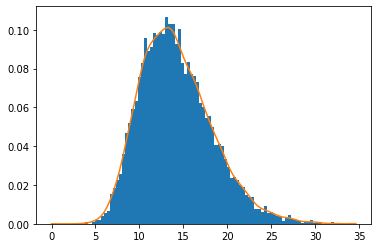

Histogram for F Test feature  1


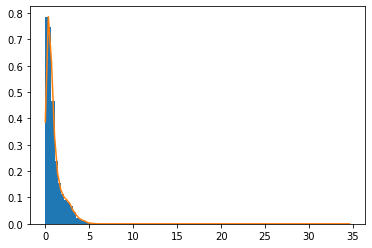

Histogram for F Test feature  2


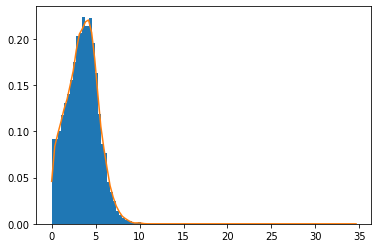

Histogram for F Test feature  3


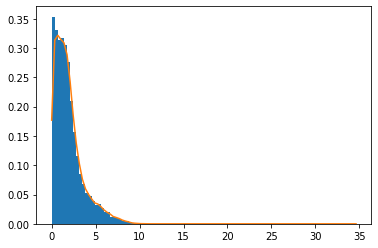

Histogram for F Test feature  4


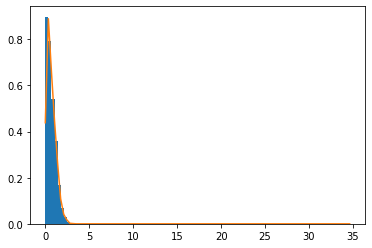

Histogram for F Test feature  5


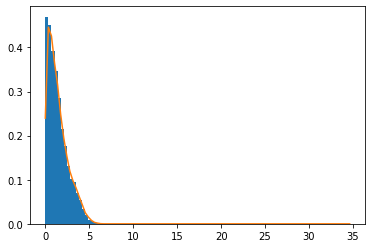

Histogram for F Test feature  6


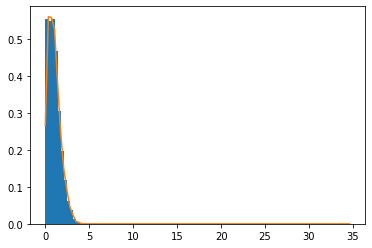

Histogram for F Test feature  7


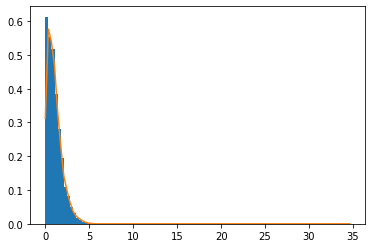

Histogram for F Test feature  8


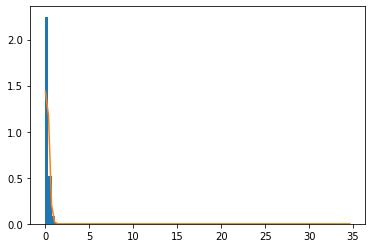

Histogram for F Test feature  9


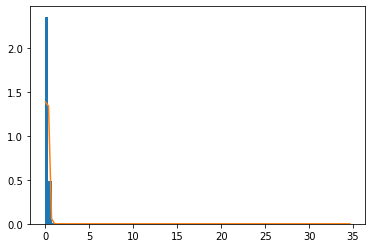

Printing the shape of the input!
torch.Size([40000, 10])
Printing the shape of the target!
torch.Size([40000, 1])


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LR Accuracy within training data - All features :  0.9525
LR Accuracy on test data - All features:  0.57535
Accuracy for without feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.934375
Logistic Regression Accuracy on test data:  0.6975
Accuracy for without feature  1


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.950825
Logistic Regression Accuracy on test data:  0.56545
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.952625
Logistic Regression Accuracy on test data:  0.5761
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9519
Logistic Regression Accuracy on test data:  0.56875
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9385
Logistic Regression Accuracy on test data:  0.3512
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.951025
Logistic Regression Accuracy on test data:  0.545
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.950725
Logistic Regression Accuracy on test data:  0.5545
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.953
Logistic Regression Accuracy on test data:  0.57355
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.952575
Logistic Regression Accuracy on test data:  0.5576
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.939825
Logistic Regression Accuracy on test data:  0.41875




Results for lamda  7



array([-4.89938694e+00, -3.27552123e+00, -1.29108828e+00, -6.77642030e-01,
       -5.19124300e-01, -1.70436131e-01, -1.47934123e-01, -5.48473274e-03,
       -5.34892626e-14,  3.98411969e-03,  1.56208991e-02,  2.60441812e-02,
        3.03730881e-02,  5.30222349e-02,  5.72127372e-02,  8.98941668e-02,
        1.12995753e-01,  1.35230702e-01,  1.52258065e-01,  1.73293326e-01,
        2.09587064e-01,  2.35835363e-01,  2.61571549e-01,  2.80137535e-01,
        3.11833833e-01,  4.20270806e-01,  4.44616191e-01,  4.97277287e-01,
        5.92384782e-01,  6.51071993e-01,  7.70926346e-01,  8.86767350e-01,
        9.33061257e-01,  1.01668031e+00,  1.20277407e+00,  1.29204952e+00,
        1.41417537e+00,  1.63842143e+00,  2.00241609e+00,  2.05821695e+00,
        2.39130564e+00,  2.54095573e+00,  3.58120384e+00,  4.37683413e+00,
        7.46027020e+00,  1.04602997e+01,  1.18191516e+01,  1.92617661e+01,
        2.20961666e+01,  1.57276861e+03])

array([[ 0.01345039,  0.04657864, -0.15017943, ..., -0.01264201,
         0.01121338,  0.18803694],
       [-0.07680202,  0.22160916, -0.02534959, ..., -0.24111718,
        -0.30680716,  0.14336574],
       [-0.2889907 ,  0.00049176, -0.13730157, ...,  0.05845756,
        -0.10297164,  0.08708557],
       ...,
       [ 0.23652877, -0.00272839,  0.11354012, ..., -0.0089599 ,
         0.02467731,  0.2789693 ],
       [-0.14309796,  0.04547078,  0.01210301, ...,  0.23305867,
        -0.01063573,  0.13238511],
       [-0.10200767, -0.04868761, -0.14087478, ...,  0.01757805,
        -0.07860699,  0.06434097]])

Printing least k eigenvalues before removing the zero eigenvalue
[-4.89938694e+00 -3.27552123e+00 -1.29108828e+00 -6.77642030e-01
 -5.19124300e-01 -1.70436131e-01 -1.47934123e-01 -5.48473274e-03
  0.00000000e+00  3.98411969e-03]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-4.89938694e+00 -3.27552123e+00 -1.29108828e+00 -6.77642030e-01
 -5.19124300e-01 -1.70436131e-01 -1.47934123e-01 -5.48473274e-03
  3.98411969e-03]
Printing non zero indeces of the least k-1 eigenvalues
[0 1 2 3 4 5 6 7 9]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9
0,13.997089,0.671097,4.334099,3.230695,1.445807,0.081122,0.539633,1.993236,0.202937,0.793030
1,10.772082,0.232452,3.400266,1.178239,0.434954,2.615423,0.468992,0.273644,0.409512,0.556209
2,20.465802,0.246478,4.592639,0.834518,0.667268,0.410139,2.424365,1.903725,0.048030,0.823993
3,24.265408,1.077828,7.184732,1.969808,0.138487,0.831092,1.646458,2.118973,0.063216,0.783984
4,18.719481,3.025538,7.101848,4.252959,0.469598,1.813810,0.019779,1.224445,0.121772,0.621100


Histogram for F Test feature  0


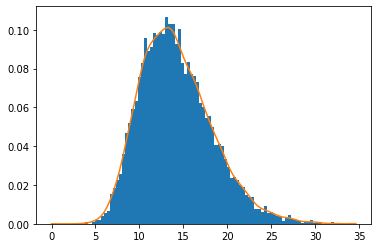

Histogram for F Test feature  1


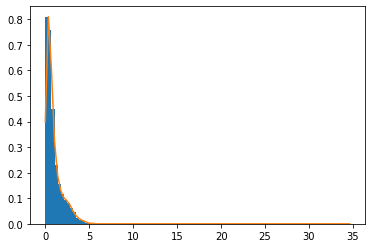

Histogram for F Test feature  2


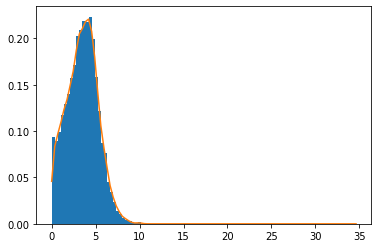

Histogram for F Test feature  3


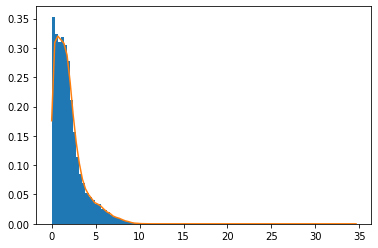

Histogram for F Test feature  4


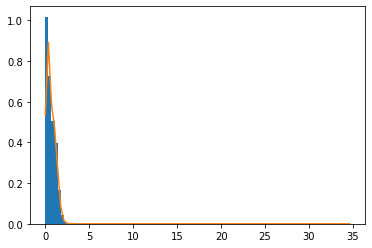

Histogram for F Test feature  5


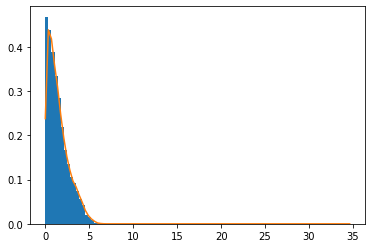

Histogram for F Test feature  6


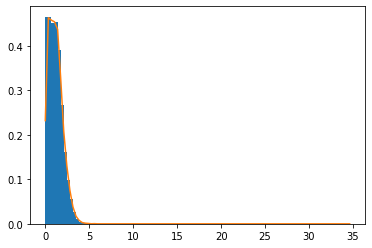

Histogram for F Test feature  7


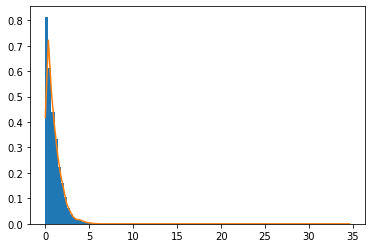

Histogram for F Test feature  8


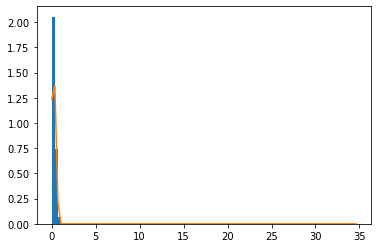

Histogram for F Test feature  9


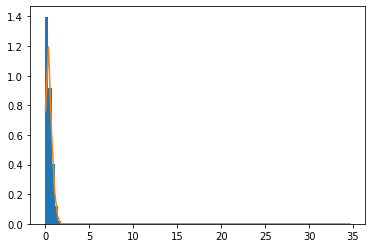

Printing the shape of the input!
torch.Size([40000, 10])
Printing the shape of the target!
torch.Size([40000, 1])


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LR Accuracy within training data - All features :  0.956
LR Accuracy on test data - All features:  0.60965
Accuracy for without feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9355
Logistic Regression Accuracy on test data:  0.7159
Accuracy for without feature  1


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.95455
Logistic Regression Accuracy on test data:  0.60565
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9562
Logistic Regression Accuracy on test data:  0.6114
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.956175
Logistic Regression Accuracy on test data:  0.60835
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9385
Logistic Regression Accuracy on test data:  0.3466
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.953575
Logistic Regression Accuracy on test data:  0.5849
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.95655
Logistic Regression Accuracy on test data:  0.6147
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.955025
Logistic Regression Accuracy on test data:  0.59835
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9339
Logistic Regression Accuracy on test data:  0.2899
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.95465
Logistic Regression Accuracy on test data:  0.60875




Results for lamda  6



array([-5.12595120e+00, -3.35972710e+00, -1.38832948e+00, -7.66821192e-01,
       -5.86347003e-01, -2.36148855e-01, -1.88365094e-01, -5.34293912e-02,
       -2.06185729e-02,  3.19791602e-14,  3.28508157e-03,  1.93445704e-02,
        2.33059264e-02,  3.49104943e-02,  3.74883834e-02,  6.83528685e-02,
        8.06620661e-02,  9.99255085e-02,  1.24528659e-01,  1.40295266e-01,
        1.72239961e-01,  1.91234255e-01,  2.15272630e-01,  2.22551007e-01,
        2.50875462e-01,  3.43939207e-01,  3.64881398e-01,  4.11416965e-01,
        4.81429528e-01,  5.31681228e-01,  6.43276822e-01,  7.36936672e-01,
        7.74654030e-01,  8.52037452e-01,  1.00270807e+00,  1.08315778e+00,
        1.16266140e+00,  1.37817445e+00,  1.68045535e+00,  1.71734876e+00,
        2.01777162e+00,  2.15198816e+00,  2.99557216e+00,  3.61926941e+00,
        6.23729535e+00,  8.89793617e+00,  1.00418597e+01,  1.63861665e+01,
        1.88481564e+01,  1.33406726e+03])

array([[-0.01587998,  0.05126911, -0.14929734, ..., -0.01259183,
         0.01158004,  0.18810264],
       [ 0.07555857,  0.22465432, -0.02281077, ..., -0.23659905,
        -0.3105327 ,  0.14320379],
       [ 0.27930981, -0.0006753 , -0.12616573, ...,  0.0609941 ,
        -0.10418131,  0.086426  ],
       ...,
       [-0.2366209 , -0.00406703,  0.10949438, ..., -0.00967348,
         0.02551786,  0.27965387],
       [ 0.14350932,  0.04672117,  0.01436679, ...,  0.23323063,
        -0.00683613,  0.13204752],
       [ 0.10584358, -0.04653349, -0.14492781, ...,  0.01957808,
        -0.07808037,  0.06399637]])

Printing least k eigenvalues before removing the zero eigenvalue
[-5.1259512  -3.3597271  -1.38832948 -0.76682119 -0.586347   -0.23614886
 -0.18836509 -0.05342939 -0.02061857  0.        ]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-5.1259512  -3.3597271  -1.38832948 -0.76682119 -0.586347   -0.23614886
 -0.18836509 -0.05342939 -0.02061857]
Printing non zero indeces of the least k-1 eigenvalues
[0 1 2 3 4 5 6 7 8]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9
0,13.997089,0.610257,4.330299,3.236990,1.527482,0.194330,1.293196,1.724321,0.281377,0.832361
1,10.772082,0.221746,3.415973,1.225707,0.205128,2.654999,0.279750,0.330550,0.370048,0.864546
2,20.465802,0.298021,4.594918,0.865261,0.704790,0.312147,1.692693,2.616945,0.141012,1.113419
3,24.265408,1.141407,7.214457,1.955918,0.260453,0.840384,2.157032,1.547357,0.552630,1.079520
4,18.719481,3.015947,7.085735,4.308015,0.658263,1.798173,0.423840,1.186164,0.349411,0.680408


Histogram for F Test feature  0


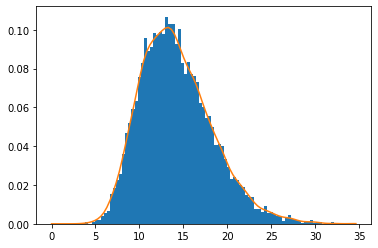

Histogram for F Test feature  1


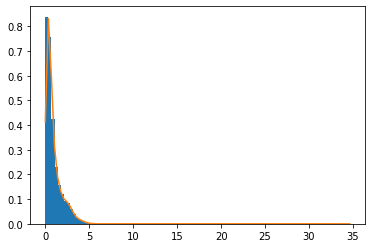

Histogram for F Test feature  2


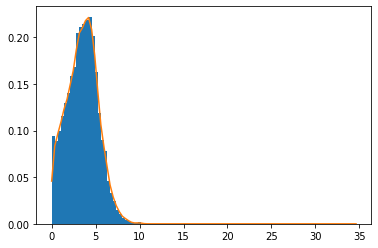

Histogram for F Test feature  3


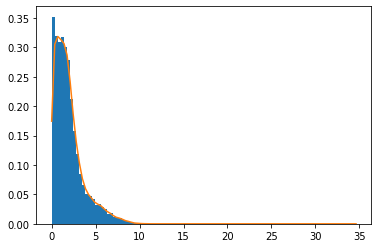

Histogram for F Test feature  4


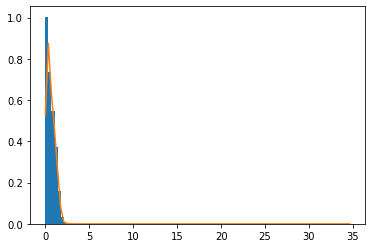

Histogram for F Test feature  5


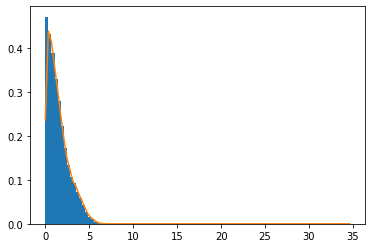

Histogram for F Test feature  6


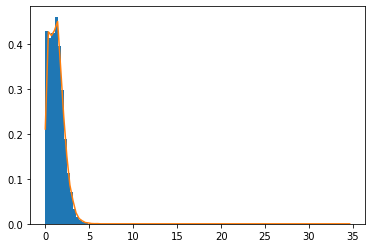

Histogram for F Test feature  7


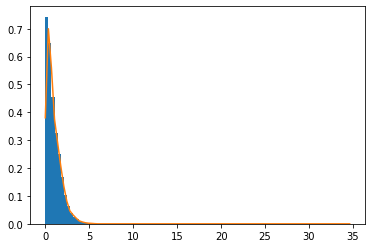

Histogram for F Test feature  8


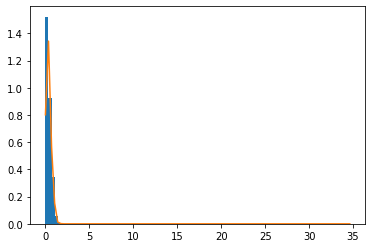

Histogram for F Test feature  9


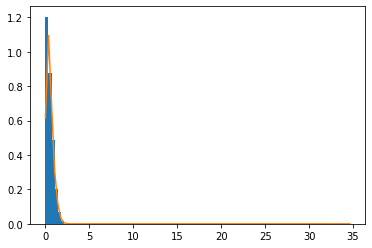

Printing the shape of the input!
torch.Size([40000, 10])
Printing the shape of the target!
torch.Size([40000, 1])


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LR Accuracy within training data - All features :  0.958125
LR Accuracy on test data - All features:  0.6374
Accuracy for without feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.940125
Logistic Regression Accuracy on test data:  0.74165
Accuracy for without feature  1
Logistic Regression Accuracy within training data:  0.9574
Logistic Regression Accuracy on test data:  0.63455
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.958125
Logistic Regression Accuracy on test data:  0.63775
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9584
Logistic Regression Accuracy on test data:  0.6363
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.94085
Logistic Regression Accuracy on test data:  0.3787
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.957675
Logistic Regression Accuracy on test data:  0.62615
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9588
Logistic Regression Accuracy on test data:  0.64635
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.958375
Logistic Regression Accuracy on test data:  0.6374
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.933025
Logistic Regression Accuracy on test data:  0.29245
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.95865
Logistic Regression Accuracy on test data:  0.6277




Results for lamda  5



array([-5.38975167e+00, -3.44698693e+00, -1.49093318e+00, -8.70607533e-01,
       -6.55251928e-01, -3.15003883e-01, -2.31874081e-01, -1.30949979e-01,
       -5.41538851e-02, -1.89788431e-02, -2.64464196e-14,  1.41055334e-02,
        1.57853376e-02,  2.00315501e-02,  2.39115347e-02,  4.99856044e-02,
        5.54823189e-02,  6.46825349e-02,  9.70247193e-02,  1.09564567e-01,
        1.35892562e-01,  1.47109762e-01,  1.62723032e-01,  1.72444022e-01,
        1.96840646e-01,  2.66844308e-01,  2.87608794e-01,  3.27840512e-01,
        3.67059666e-01,  4.22663581e-01,  5.15905214e-01,  5.88028975e-01,
        6.17612554e-01,  6.89187611e-01,  8.00959637e-01,  8.71671793e-01,
        9.20256294e-01,  1.12128480e+00,  1.36131599e+00,  1.38415509e+00,
        1.64577248e+00,  1.76327609e+00,  2.41666605e+00,  2.86656655e+00,
        5.02368084e+00,  7.34067483e+00,  8.26801867e+00,  1.35095929e+01,
        1.56036069e+01,  1.09539184e+03])

array([[ 0.01888963, -0.056639  ,  0.14879664, ..., -0.0125606 ,
         0.01211731,  0.18819438],
       [-0.07461128, -0.22804591,  0.0205681 , ..., -0.23043291,
        -0.31547216,  0.14297003],
       [-0.26954395,  0.00282753,  0.11545612, ...,  0.064607  ,
        -0.10579506,  0.08547956],
       ...,
       [ 0.23630765,  0.00499273, -0.10519415, ..., -0.0106971 ,
         0.02666584,  0.28063181],
       [-0.14348454, -0.04752731, -0.01729428, ...,  0.23334059,
        -0.00167205,  0.1315621 ],
       [-0.10972914,  0.04417693,  0.14887519, ...,  0.02230004,
        -0.07728669,  0.06350171]])

Printing least k eigenvalues before removing the zero eigenvalue
[-5.38975167 -3.44698693 -1.49093318 -0.87060753 -0.65525193 -0.31500388
 -0.23187408 -0.13094998 -0.05415389 -0.01897884]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-5.38975167 -3.44698693 -1.49093318 -0.87060753 -0.65525193 -0.31500388
 -0.23187408 -0.13094998 -0.05415389]
Printing non zero indeces of the least k-1 eigenvalues
[0 1 2 3 4 5 6 7 8]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9
0,13.997089,0.550372,4.320964,3.240836,1.619987,0.302108,1.547199,1.547135,0.135732,0.880433
1,10.772082,0.204924,3.434272,1.273516,0.001717,2.669236,0.206893,0.193295,0.571295,1.088794
2,20.465802,0.348802,4.595373,0.898140,0.737242,0.223040,1.442332,2.764758,0.112055,1.320497
3,24.265408,1.193787,7.247283,1.943227,0.362588,0.831194,2.178916,1.388142,0.835538,1.502804
4,18.719481,2.992170,7.075412,4.355918,0.828639,1.774037,0.570794,1.167018,0.256940,0.767087


Histogram for F Test feature  0


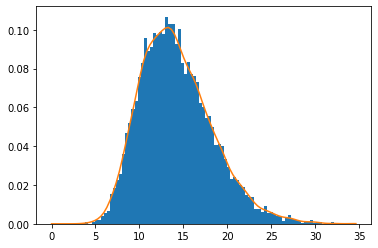

Histogram for F Test feature  1


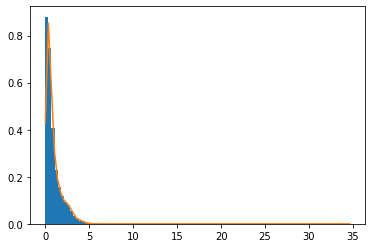

Histogram for F Test feature  2


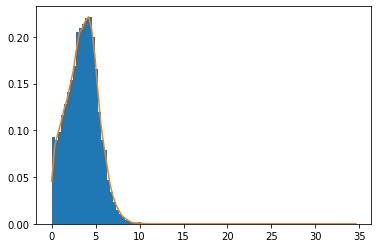

Histogram for F Test feature  3


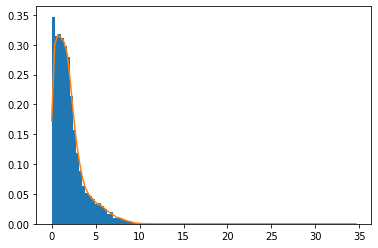

Histogram for F Test feature  4


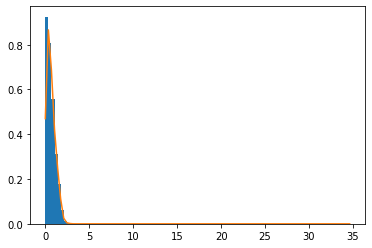

Histogram for F Test feature  5


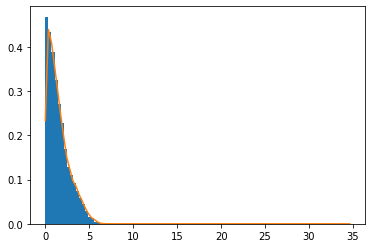

Histogram for F Test feature  6


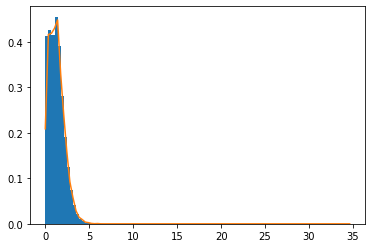

Histogram for F Test feature  7


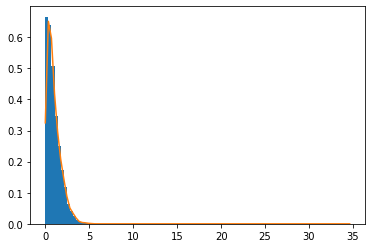

Histogram for F Test feature  8


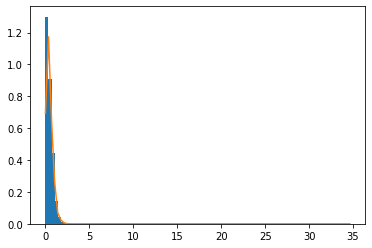

Histogram for F Test feature  9


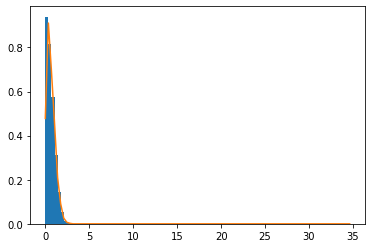

Printing the shape of the input!
torch.Size([40000, 10])
Printing the shape of the target!
torch.Size([40000, 1])


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LR Accuracy within training data - All features :  0.95945
LR Accuracy on test data - All features:  0.64475
Accuracy for without feature  0
Logistic Regression Accuracy within training data:  0.939225
Logistic Regression Accuracy on test data:  0.74445
Accuracy for without feature  1


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.95805
Logistic Regression Accuracy on test data:  0.64275
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.959725
Logistic Regression Accuracy on test data:  0.64645
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.959325
Logistic Regression Accuracy on test data:  0.64315
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.943675
Logistic Regression Accuracy on test data:  0.39905
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.959
Logistic Regression Accuracy on test data:  0.6419
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.959925
Logistic Regression Accuracy on test data:  0.64985
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.958825
Logistic Regression Accuracy on test data:  0.6431
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.93575
Logistic Regression Accuracy on test data:  0.3342
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9594
Logistic Regression Accuracy on test data:  0.6402




Results for lamda  4



array([-5.71436844e+00, -3.53815812e+00, -1.60063051e+00, -9.94047186e-01,
       -7.27244005e-01, -4.07644749e-01, -2.94990013e-01, -2.32578939e-01,
       -9.70095702e-02, -5.71305439e-02,  2.63166469e-15,  1.76355339e-03,
        8.62030215e-03,  1.00262273e-02,  1.50641802e-02,  2.65526220e-02,
        3.55426225e-02,  4.01292085e-02,  6.89793140e-02,  7.97145201e-02,
        9.93399559e-02,  1.03635906e-01,  1.10747709e-01,  1.27792784e-01,
        1.47480668e-01,  1.89942086e-01,  2.11246053e-01,  2.46491272e-01,
        2.58923596e-01,  3.20968697e-01,  3.88241581e-01,  4.41167165e-01,
        4.62000883e-01,  5.28210730e-01,  5.98970335e-01,  6.51342542e-01,
        6.99582468e-01,  8.68493176e-01,  1.04807199e+00,  1.05786912e+00,
        1.27508468e+00,  1.37442084e+00,  1.84781535e+00,  2.12268719e+00,
        3.82661667e+00,  5.79049613e+00,  6.49937515e+00,  1.06314832e+01,
        1.23648449e+01,  8.56763864e+02])

array([[-0.02258978, -0.06283862, -0.1487888 , ..., -0.01260079,
         0.01296792,  0.18833116],
       [ 0.07406103, -0.2319514 , -0.01886308, ..., -0.22161204,
        -0.32226858,  0.14260326],
       [ 0.25985113,  0.00613975, -0.10533503, ...,  0.07012712,
        -0.1080547 ,  0.0840073 ],
       ...,
       [-0.23537707,  0.00538397,  0.10062598, ..., -0.01227613,
         0.02832287,  0.28214283],
       [ 0.14292301, -0.04769266,  0.02092958, ...,  0.23324376,
         0.00568895,  0.13080468],
       [ 0.11373373,  0.04157494, -0.15243178, ...,  0.0261997 ,
        -0.0759912 ,  0.06273183]])

Printing least k eigenvalues before removing the zero eigenvalue
[-5.71436844 -3.53815812 -1.60063051 -0.99404719 -0.72724401 -0.40764475
 -0.29499001 -0.23257894 -0.09700957 -0.05713054]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-5.71436844 -3.53815812 -1.60063051 -0.99404719 -0.72724401 -0.40764475
 -0.29499001 -0.23257894 -0.09700957]
Printing non zero indeces of the least k-1 eigenvalues
[0 1 2 3 4 5 6 7 8]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9
0,13.997089,0.490025,4.305123,3.240417,1.730207,0.402562,1.665938,1.012631,1.044438,0.892606
1,10.772082,0.181120,3.455431,1.320729,0.160570,2.663227,0.238616,0.265891,0.721512,1.206984
2,20.465802,0.399882,4.593510,0.933257,0.777986,0.150950,1.269730,2.515552,1.255108,1.454355
3,24.265408,1.234617,7.284322,1.932656,0.431338,0.806499,2.106513,0.864160,1.491497,1.901955
4,18.719481,2.951598,7.071286,4.395724,0.971692,1.748844,0.688055,1.102361,0.262732,0.934053


Histogram for F Test feature  0


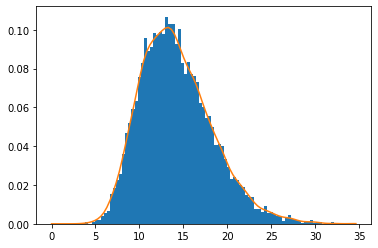

Histogram for F Test feature  1


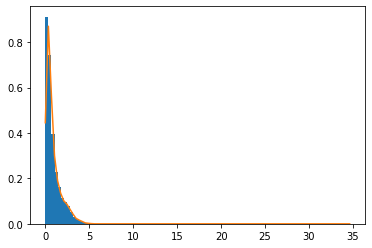

Histogram for F Test feature  2


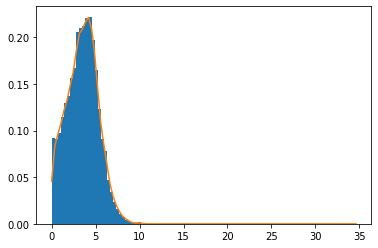

Histogram for F Test feature  3


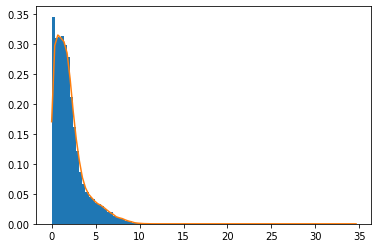

Histogram for F Test feature  4


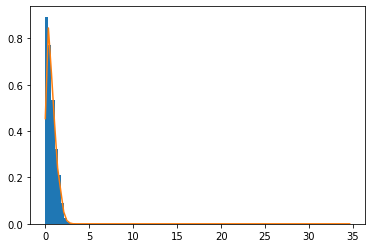

Histogram for F Test feature  5


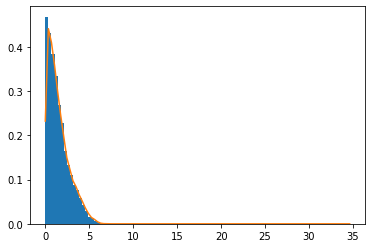

Histogram for F Test feature  6


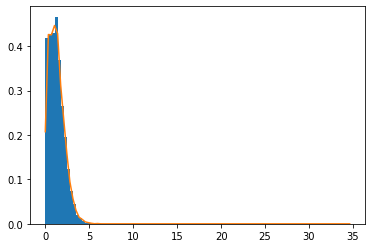

Histogram for F Test feature  7


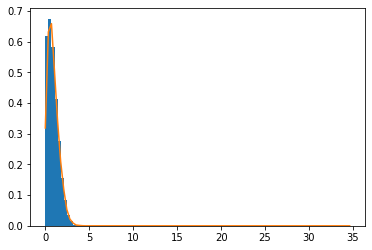

Histogram for F Test feature  8


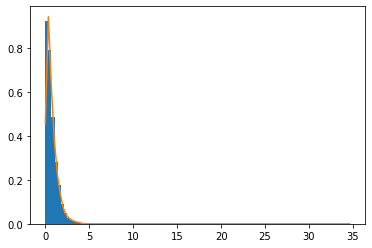

Histogram for F Test feature  9


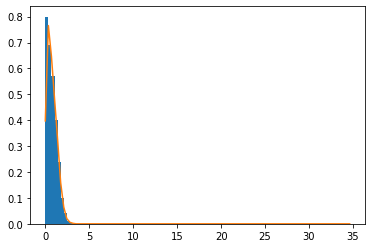

Printing the shape of the input!
torch.Size([40000, 10])
Printing the shape of the target!
torch.Size([40000, 1])


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LR Accuracy within training data - All features :  0.958975
LR Accuracy on test data - All features:  0.63945
Accuracy for without feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.931925
Logistic Regression Accuracy on test data:  0.73725
Accuracy for without feature  1
Logistic Regression Accuracy within training data:  0.95735
Logistic Regression Accuracy on test data:  0.63365
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.959075
Logistic Regression Accuracy on test data:  0.64595
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.958925
Logistic Regression Accuracy on test data:  0.6381
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.94495
Logistic Regression Accuracy on test data:  0.41445
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.95895
Logistic Regression Accuracy on test data:  0.63985
Accuracy for without feature  6
Logistic Regression Accuracy within training data:  0.959325
Logistic Regression Accuracy on test data:  0.63995
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.949075
Logistic Regression Accuracy on test data:  0.5419
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9438
Logistic Regression Accuracy on test data:  0.46
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.95905
Logistic Regression Accuracy on test data:  0.64175




Results for lamda  3



array([-6.15662072e+00, -3.63452250e+00, -1.72063934e+00, -1.14682583e+00,
       -8.05995249e-01, -5.30999932e-01, -4.32232742e-01, -3.07171710e-01,
       -1.52111614e-01, -1.19869742e-01, -3.09630629e-02, -1.96601822e-14,
        5.91352950e-04,  4.45507739e-03,  7.86482075e-03,  9.88729256e-03,
        2.05273581e-02,  2.08378906e-02,  3.78603938e-02,  4.88502113e-02,
        5.84431649e-02,  6.33562745e-02,  6.86912003e-02,  8.48382199e-02,
        1.00467873e-01,  1.14260687e-01,  1.36229102e-01,  1.64594566e-01,
        1.72341840e-01,  2.22949569e-01,  2.58942498e-01,  2.98315863e-01,
        3.07958349e-01,  3.69029775e-01,  4.03176834e-01,  4.32388083e-01,
        4.95396357e-01,  6.20652833e-01,  7.37260802e-01,  7.44167901e-01,
        9.04117226e-01,  9.83590126e-01,  1.29378548e+00,  1.40212683e+00,
        2.66130747e+00,  4.25029329e+00,  4.73946853e+00,  7.75092113e+00,
        9.13676584e+00,  6.18237654e+02])

array([[-0.02686284, -0.07007639, -0.14926457, ..., -0.01290233,
         0.01447562,  0.18855551],
       [ 0.07417082, -0.23666326, -0.01817199, ..., -0.20829806,
        -0.33200484,  0.14194535],
       [ 0.25068586,  0.01087706, -0.09624644, ...,  0.07948201,
        -0.11145165,  0.08140381],
       ...,
       [-0.2333391 ,  0.00504769,  0.09582717, ..., -0.01498164,
         0.03091126,  0.28478462],
       [ 0.14178723, -0.04687605,  0.0252332 , ...,  0.23249166,
         0.01681528,  0.12945843],
       [ 0.11804678,  0.03866048, -0.15492087, ...,  0.03218573,
        -0.07362771,  0.06136917]])

Printing least k eigenvalues before removing the zero eigenvalue
[-6.15662072 -3.6345225  -1.72063934 -1.14682583 -0.80599525 -0.53099993
 -0.43223274 -0.30717171 -0.15211161 -0.11986974]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-6.15662072 -3.6345225  -1.72063934 -1.14682583 -0.80599525 -0.53099993
 -0.43223274 -0.30717171 -0.15211161]
Printing non zero indeces of the least k-1 eigenvalues
[0 1 2 3 4 5 6 7 8]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9
0,13.997089,0.426711,4.281511,3.228905,1.866954,0.514613,1.562370,0.435159,1.541497,0.800673
1,10.772082,0.148687,3.479613,1.365246,0.278870,2.630050,0.557140,0.704163,0.422861,1.136276
2,20.465802,0.452035,4.588633,0.968272,0.850710,0.105179,0.879731,1.683365,2.336353,1.306471
3,24.265408,1.264542,7.327118,1.925094,0.449615,0.750561,1.886417,0.567441,1.961196,2.147268
4,18.719481,2.889040,7.073470,4.426999,1.087309,1.714060,0.916846,0.556037,0.800360,1.276995


Histogram for F Test feature  0


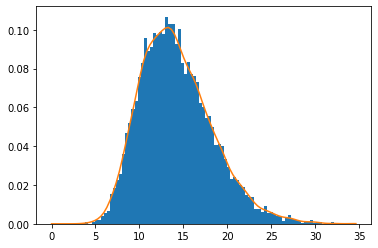

Histogram for F Test feature  1


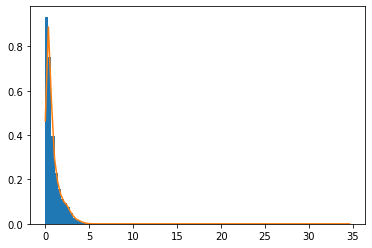

Histogram for F Test feature  2


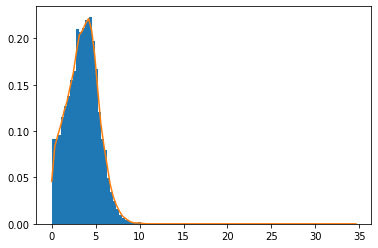

Histogram for F Test feature  3


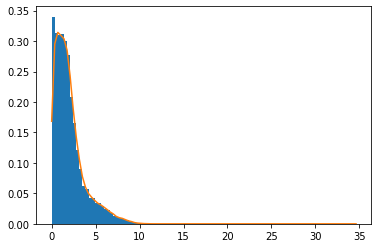

Histogram for F Test feature  4


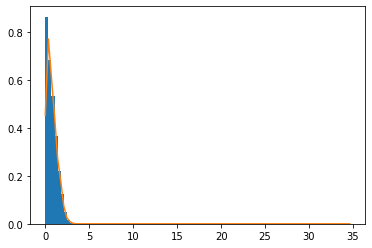

Histogram for F Test feature  5


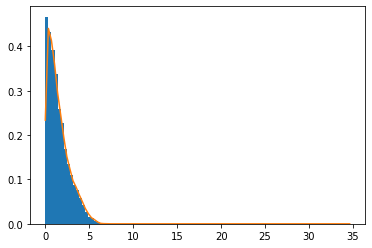

Histogram for F Test feature  6


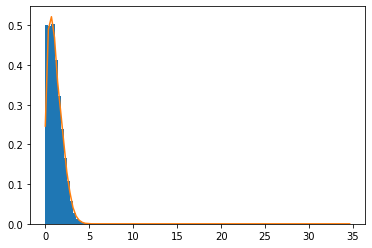

Histogram for F Test feature  7


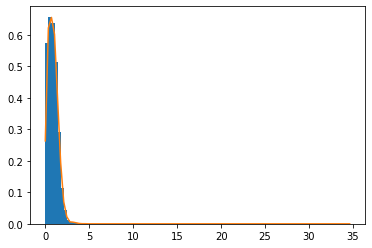

Histogram for F Test feature  8


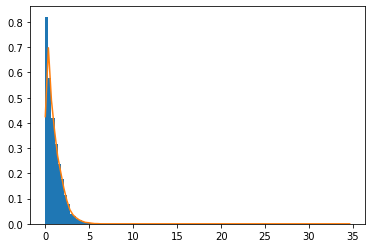

Histogram for F Test feature  9


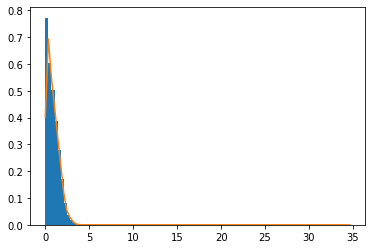

Printing the shape of the input!
torch.Size([40000, 10])
Printing the shape of the target!
torch.Size([40000, 1])


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LR Accuracy within training data - All features :  0.961825
LR Accuracy on test data - All features:  0.66665
Accuracy for without feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9162
Logistic Regression Accuracy on test data:  0.76485
Accuracy for without feature  1


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.960075
Logistic Regression Accuracy on test data:  0.66095
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.962825
Logistic Regression Accuracy on test data:  0.68105
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.96205
Logistic Regression Accuracy on test data:  0.6671
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.946375
Logistic Regression Accuracy on test data:  0.4402
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.962025
Logistic Regression Accuracy on test data:  0.66755
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9618
Logistic Regression Accuracy on test data:  0.6669
Accuracy for without feature  7
Logistic Regression Accuracy within training data:  0.9326
Logistic Regression Accuracy on test data:  0.28405
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9611
Logistic Regression Accuracy on test data:  0.65325
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.958525
Logistic Regression Accuracy on test data:  0.63805




Results for lamda  2



array([-6.90579191e+00, -3.73817349e+00, -1.85845471e+00, -1.35068904e+00,
       -9.08492340e-01, -7.43173385e-01, -5.91781572e-01, -3.68626665e-01,
       -2.73435910e-01, -1.96270193e-01, -7.27266432e-02, -3.40909282e-02,
       -8.83140925e-03, -5.57010853e-03, -3.07202445e-03, -3.11030470e-15,
        1.66400338e-03,  4.50357062e-03,  1.10408787e-02,  1.66495387e-02,
        2.14102173e-02,  2.63772483e-02,  3.52738699e-02,  4.37927984e-02,
        4.76205250e-02,  5.75054016e-02,  6.98942781e-02,  8.88259298e-02,
        9.82128306e-02,  1.19581472e-01,  1.32549554e-01,  1.58561340e-01,
        1.62864028e-01,  2.09090656e-01,  2.21487085e-01,  2.31424905e-01,
        2.97297978e-01,  3.78911790e-01,  4.25061102e-01,  4.50726644e-01,
        5.21730163e-01,  5.86683389e-01,  7.46890660e-01,  7.84313266e-01,
        1.56134923e+00,  2.72300744e+00,  2.99804579e+00,  4.86729568e+00,
        5.93138045e+00,  3.80001186e+02])

array([[ 0.03014965,  0.07866638, -0.14967156, ..., -0.01438934,
        -0.01766768,  0.18897841],
       [-0.07591019,  0.24278045, -0.01965901, ..., -0.18761583,
         0.34632687,  0.14042671],
       [-0.24362976, -0.01745897, -0.08976753, ...,  0.09832279,
         0.11723071,  0.07556326],
       ...,
       [ 0.22851403, -0.00365513,  0.0910827 , ..., -0.02043157,
        -0.03548981,  0.2905725 ],
       [-0.14063971,  0.0444131 ,  0.02974897, ...,  0.22941292,
        -0.03467628,  0.12640691],
       [-0.12333738, -0.0353132 , -0.15438555, ...,  0.04229839,
         0.06856143,  0.05830669]])

Printing least k eigenvalues before removing the zero eigenvalue
[-6.90579191 -3.73817349 -1.85845471 -1.35068904 -0.90849234 -0.74317338
 -0.59178157 -0.36862667 -0.27343591 -0.19627019]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-6.90579191 -3.73817349 -1.85845471 -1.35068904 -0.90849234 -0.74317338
 -0.59178157 -0.36862667 -0.27343591]
Printing non zero indeces of the least k-1 eigenvalues
[0 1 2 3 4 5 6 7 8]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9
0,13.997089,0.355242,4.248673,3.178642,2.046588,0.762280,0.854064,1.329522,1.558430,0.446905
1,10.772082,0.103595,3.506672,1.401731,0.348396,2.402285,1.372905,0.451869,0.224480,0.436159
2,20.465802,0.502540,4.579893,0.989086,0.999437,0.129688,0.338778,1.518173,2.412910,0.154525
3,24.265408,1.288289,7.378064,1.919366,0.372471,0.493911,1.375048,1.460549,2.165598,1.133024
4,18.719481,2.791840,7.081216,4.450738,1.188826,1.507378,1.287646,0.028443,0.843618,1.298145


Histogram for F Test feature  0


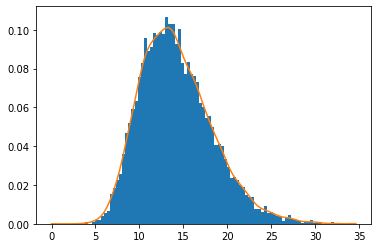

Histogram for F Test feature  1


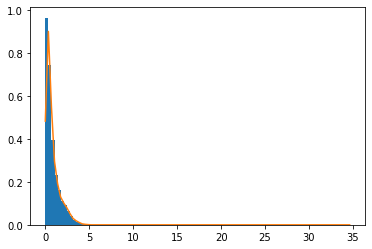

Histogram for F Test feature  2


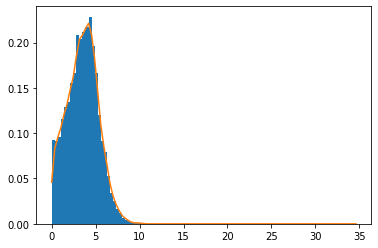

Histogram for F Test feature  3


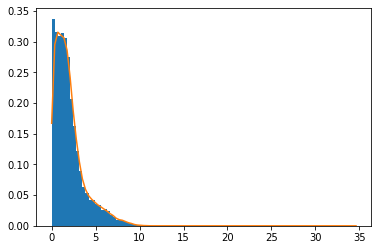

Histogram for F Test feature  4


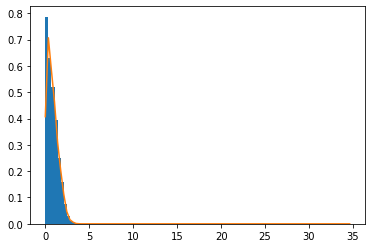

Histogram for F Test feature  5


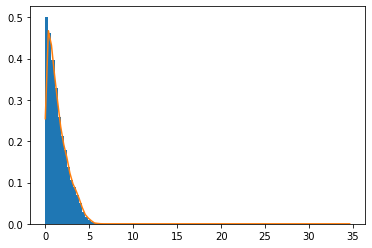

Histogram for F Test feature  6


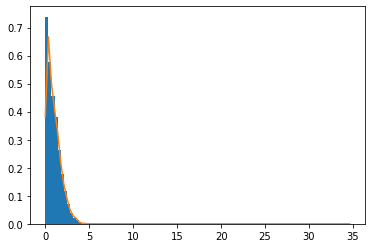

Histogram for F Test feature  7


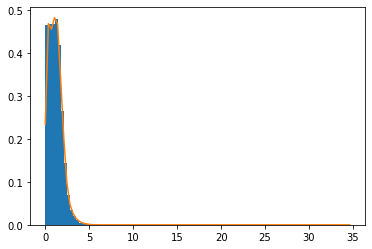

Histogram for F Test feature  8


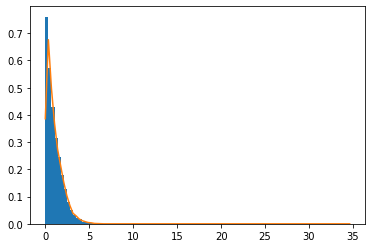

Histogram for F Test feature  9


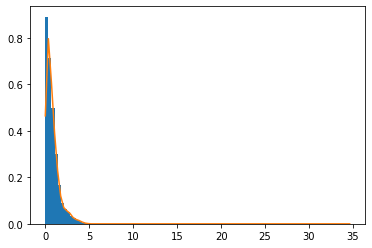

Printing the shape of the input!
torch.Size([40000, 10])
Printing the shape of the target!
torch.Size([40000, 1])


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LR Accuracy within training data - All features :  0.971325
LR Accuracy on test data - All features:  0.7666
Accuracy for without feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.931025
Logistic Regression Accuracy on test data:  0.83395
Accuracy for without feature  1
Logistic Regression Accuracy within training data:  0.9691
Logistic Regression Accuracy on test data:  0.7549
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.971225
Logistic Regression Accuracy on test data:  0.76885
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.971325
Logistic Regression Accuracy on test data:  0.76595
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.955575
Logistic Regression Accuracy on test data:  0.5848
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.97105
Logistic Regression Accuracy on test data:  0.7619
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9627
Logistic Regression Accuracy on test data:  0.6886
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.945075
Logistic Regression Accuracy on test data:  0.49005
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.97115
Logistic Regression Accuracy on test data:  0.76495
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.961625
Logistic Regression Accuracy on test data:  0.6676




Results for lamda  1



array([-9.31097265e+00, -3.85312109e+00, -2.04278810e+00, -1.66358097e+00,
       -1.19509256e+00, -9.55655017e-01, -8.26157836e-01, -5.40534387e-01,
       -4.38817028e-01, -2.79385323e-01, -1.71555423e-01, -1.28720553e-01,
       -7.27539020e-02, -5.33717287e-02, -4.05455591e-02, -2.06531534e-02,
       -1.77833490e-02, -1.08909860e-02, -5.14776047e-03, -1.37880358e-03,
       -4.18214684e-15,  9.89985564e-04,  1.48300493e-03,  3.39117078e-03,
        8.13144125e-03,  9.01554082e-03,  1.14748411e-02,  2.10318256e-02,
        2.33169055e-02,  2.48485092e-02,  2.99401068e-02,  3.40222919e-02,
        4.23818127e-02,  5.33369658e-02,  6.25898545e-02,  7.60686629e-02,
        1.02040391e-01,  1.38509587e-01,  1.39394539e-01,  1.65156169e-01,
        1.74901208e-01,  2.13503329e-01,  2.89422537e-01,  3.11031252e-01,
        5.93272135e-01,  1.19253135e+00,  1.32358648e+00,  1.99826685e+00,
        2.78592861e+00,  1.43418984e+02])

array([[-0.01749992,  0.08918147, -0.14815048, ...,  0.02721306,
         0.02689941,  0.18958715],
       [ 0.08643503,  0.25186989, -0.02664017, ...,  0.16762932,
        -0.36598557,  0.13345034],
       [ 0.2468837 , -0.02661811, -0.09482258, ..., -0.15537168,
        -0.13038005,  0.05109586],
       ...,
       [-0.20647301, -0.0005543 ,  0.08806575, ...,  0.03493044,
         0.0457737 ,  0.31282069],
       [ 0.14637072,  0.03874563,  0.03057068, ..., -0.21236222,
         0.06257937,  0.11317093],
       [ 0.13349898, -0.03125132, -0.14239954, ..., -0.06197207,
        -0.0545978 ,  0.04539814]])

Printing least k eigenvalues before removing the zero eigenvalue
[-9.31097265 -3.85312109 -2.0427881  -1.66358097 -1.19509256 -0.95565502
 -0.82615784 -0.54053439 -0.43881703 -0.27938532]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-9.31097265 -3.85312109 -2.0427881  -1.66358097 -1.19509256 -0.95565502
 -0.82615784 -0.54053439 -0.43881703]
Printing non zero indeces of the least k-1 eigenvalues
[0 1 2 3 4 5 6 7 8]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9
0,13.997089,0.256668,4.205794,2.917301,2.344603,1.280994,0.184981,1.223985,1.048530,1.543760
1,10.772082,0.032629,3.535544,1.411985,0.303028,1.079078,2.518861,0.443237,0.510107,0.087846
2,20.465802,0.513928,4.566826,0.886914,1.339001,0.217524,0.094765,0.863039,1.190332,2.371505
3,24.265408,1.337774,7.441542,1.880217,0.002792,0.344338,0.981530,1.712440,0.186343,2.434526
4,18.719481,2.615432,7.091116,4.449788,1.423410,0.271992,1.907589,0.468728,0.773130,0.698105


Histogram for F Test feature  0


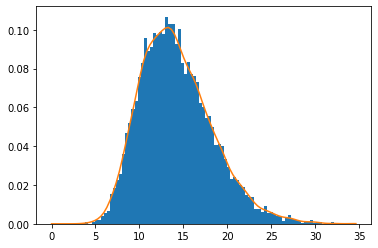

Histogram for F Test feature  1


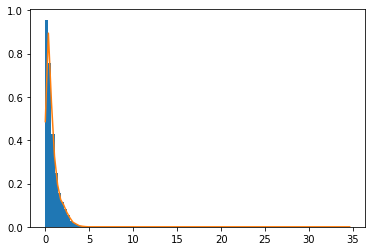

Histogram for F Test feature  2


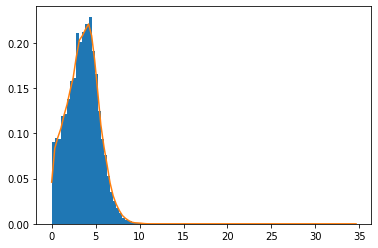

Histogram for F Test feature  3


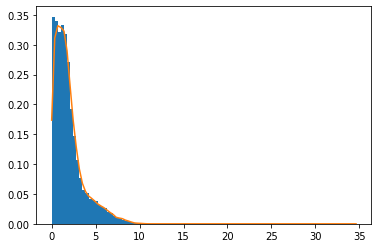

Histogram for F Test feature  4


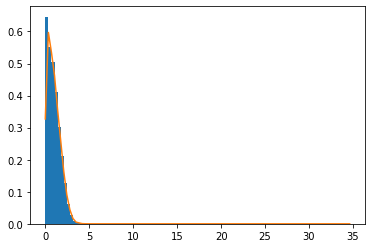

Histogram for F Test feature  5


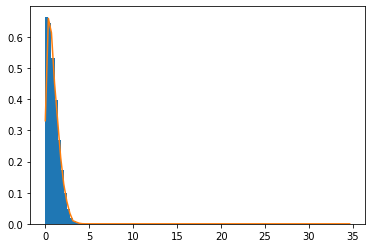

Histogram for F Test feature  6


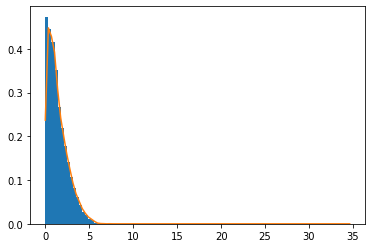

Histogram for F Test feature  7


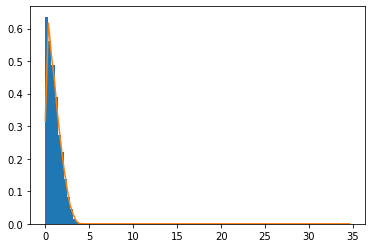

Histogram for F Test feature  8


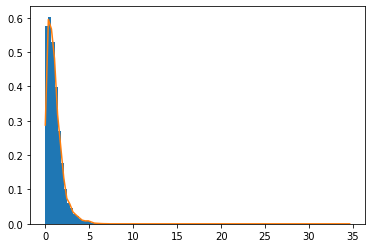

Histogram for F Test feature  9


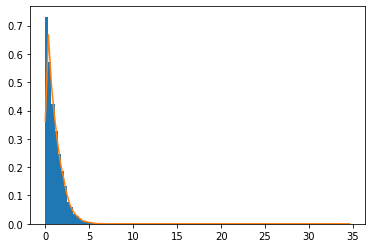

Printing the shape of the input!
torch.Size([40000, 10])
Printing the shape of the target!
torch.Size([40000, 1])


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LR Accuracy within training data - All features :  0.974125
LR Accuracy on test data - All features:  0.79795
Accuracy for without feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.947275
Logistic Regression Accuracy on test data:  0.862
Accuracy for without feature  1


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.971875
Logistic Regression Accuracy on test data:  0.78715
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9739
Logistic Regression Accuracy on test data:  0.79825
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9718
Logistic Regression Accuracy on test data:  0.7847
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.954775
Logistic Regression Accuracy on test data:  0.58365
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.971175
Logistic Regression Accuracy on test data:  0.77465
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.969
Logistic Regression Accuracy on test data:  0.75715
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9486
Logistic Regression Accuracy on test data:  0.5244
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.972425
Logistic Regression Accuracy on test data:  0.78395
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.973475
Logistic Regression Accuracy on test data:  0.79695




Results for lamda  0.1



array([-8.19831597e+01, -3.97490877e+00, -2.61663532e+00, -2.16580743e+00,
       -1.72203765e+00, -1.36064258e+00, -1.06745617e+00, -8.90551624e-01,
       -7.46297669e-01, -5.39277050e-01, -4.37124993e-01, -3.94149347e-01,
       -2.65468584e-01, -2.14884827e-01, -2.04354631e-01, -1.48203655e-01,
       -1.30600787e-01, -1.20126269e-01, -1.09926887e-01, -1.07415025e-01,
       -9.69981204e-02, -7.88085045e-02, -7.40410337e-02, -6.57525181e-02,
       -5.09703760e-02, -3.27577774e-02, -2.78828738e-02, -2.65420571e-02,
       -2.58411167e-02, -2.25791487e-02, -1.68799434e-02, -1.62793401e-02,
       -1.30290185e-02, -1.21863984e-02, -1.13963834e-02, -8.76793940e-03,
       -6.62363548e-03, -3.52762682e-03, -3.22401680e-03, -2.45319070e-03,
       -1.35602668e-03, -8.70136382e-04, -5.63963923e-05, -1.70919344e-15,
        5.42815109e-03,  1.66763915e-02,  2.87902202e-02,  7.30941396e-02,
        1.72880792e-01,  1.30258304e+00])

array([[-0.17062601,  0.10169183,  0.17966397, ...,  0.13509898,
        -0.06360849,  0.00676854],
       [-0.15563994,  0.26743766, -0.00695518, ...,  0.2238926 ,
         0.37999687,  0.00277215],
       [-0.15938279, -0.03852258,  0.10374925, ..., -0.34142485,
         0.1514014 , -0.25692221],
       ...,
       [-0.18623635,  0.00536271, -0.02212848, ...,  0.05822681,
        -0.07520994,  0.36076434],
       [-0.16538001,  0.02681776, -0.00848712, ...,  0.02439807,
        -0.03748079, -0.10655267],
       [-0.10138592, -0.02619245,  0.03995867, ...,  0.03629362,
         0.00102073, -0.10471585]])

Printing least k eigenvalues before removing the zero eigenvalue
[-81.98315971  -3.97490877  -2.61663532  -2.16580743  -1.72203765
  -1.36064258  -1.06745617  -0.89055162  -0.74629767  -0.53927705]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-81.98315971  -3.97490877  -2.61663532  -2.16580743  -1.72203765
  -1.36064258  -1.06745617  -0.89055162  -0.74629767]
Printing non zero indeces of the least k-1 eigenvalues
[0 1 2 3 4 5 6 7 8]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9
0,13.997089,0.046569,4.161450,0.957696,2.871998,2.596896,0.668227,0.319096,1.041196,1.407528
1,10.772082,0.071119,3.558880,1.043477,0.394190,0.956384,0.564780,2.664544,0.274774,0.682566
2,20.465802,0.116608,4.553925,0.546512,1.741288,0.497165,0.364993,0.472264,1.293268,1.617519
3,24.265408,0.953226,7.516872,0.684650,1.457147,0.047143,0.385683,1.968451,0.627267,0.704835
4,18.719481,1.437887,7.092315,3.625233,3.266072,1.157412,0.508621,1.959895,0.651317,0.418739


Histogram for F Test feature  0


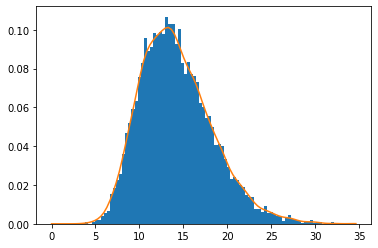

Histogram for F Test feature  1


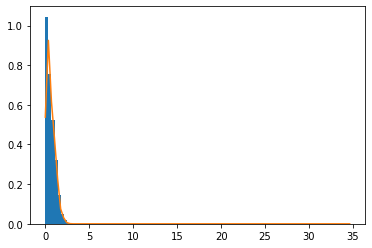

Histogram for F Test feature  2


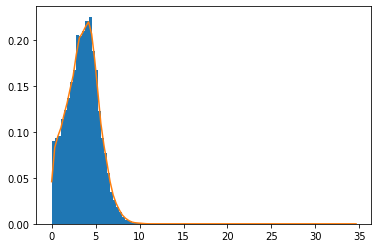

Histogram for F Test feature  3


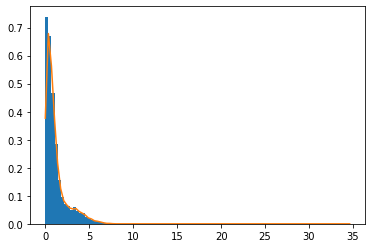

Histogram for F Test feature  4


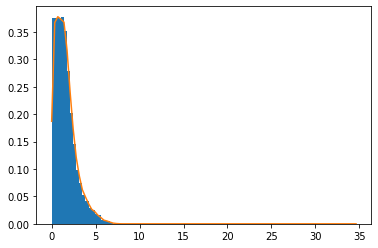

Histogram for F Test feature  5


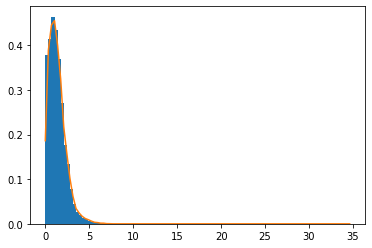

Histogram for F Test feature  6


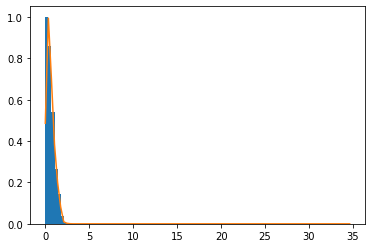

Histogram for F Test feature  7


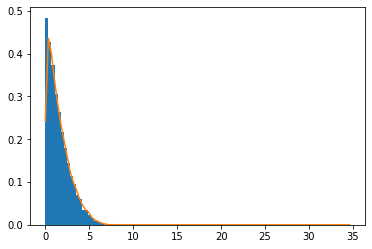

Histogram for F Test feature  8


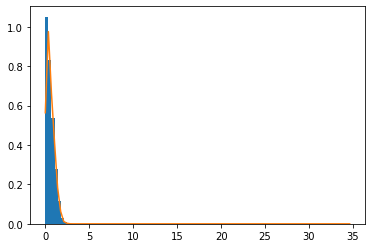

Histogram for F Test feature  9


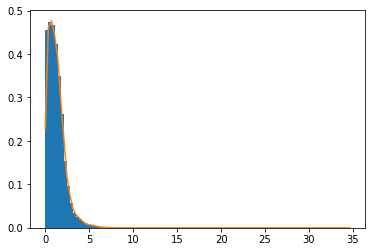

Printing the shape of the input!
torch.Size([40000, 10])
Printing the shape of the target!
torch.Size([40000, 1])


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LR Accuracy within training data - All features :  0.9751
LR Accuracy on test data - All features:  0.81235
Accuracy for without feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9565
Logistic Regression Accuracy on test data:  0.87975
Accuracy for without feature  1
Logistic Regression Accuracy within training data:  0.97505
Logistic Regression Accuracy on test data:  0.81
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9751
Logistic Regression Accuracy on test data:  0.81235
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9545
Logistic Regression Accuracy on test data:  0.5597
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.959025
Logistic Regression Accuracy on test data:  0.62825
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.974825
Logistic Regression Accuracy on test data:  0.8076
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.95005
Logistic Regression Accuracy on test data:  0.5222
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.975025
Logistic Regression Accuracy on test data:  0.81205
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9744
Logistic Regression Accuracy on test data:  0.80835
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.97515
Logistic Regression Accuracy on test data:  0.81255




Results for lamda  0.01



array([-1.02021117e+02, -3.98889001e+00, -2.81260479e+00, -2.22386262e+00,
       -1.77716112e+00, -1.44412693e+00, -1.12053870e+00, -1.08254154e+00,
       -7.71923123e-01, -5.87132620e-01, -4.87775535e-01, -4.52743964e-01,
       -3.00672302e-01, -2.57854162e-01, -2.37845906e-01, -1.74687993e-01,
       -1.58706473e-01, -1.56763902e-01, -1.35499456e-01, -1.22031227e-01,
       -1.12942870e-01, -1.02198020e-01, -9.02500883e-02, -8.58817420e-02,
       -6.80502089e-02, -5.36054854e-02, -4.66872663e-02, -4.51146528e-02,
       -3.70141828e-02, -3.26486123e-02, -2.95943206e-02, -2.51330762e-02,
       -2.35001138e-02, -2.06311281e-02, -1.92509659e-02, -1.81297951e-02,
       -1.57050702e-02, -1.40068008e-02, -1.26060701e-02, -1.09851971e-02,
       -8.99792370e-03, -7.11420473e-03, -5.80943026e-03, -4.74324665e-03,
       -3.95081123e-03, -3.02230595e-03, -2.13697211e-03, -1.44498889e-03,
        1.42144242e-15,  3.54302581e-02])

array([[-0.17537351,  0.10329897,  0.18746286, ...,  0.0187336 ,
        -0.13611737,  0.04581528],
       [-0.15439072,  0.26994292, -0.02157806, ...,  0.04330497,
        -0.10290048, -0.02170464],
       [-0.14667524, -0.04006822,  0.07067533, ...,  0.00732053,
        -0.09914154,  0.43192637],
       ...,
       [-0.20546542,  0.00635501,  0.01886238, ...,  0.06638132,
        -0.27322376, -0.3393643 ],
       [-0.16024385,  0.02483235, -0.01633161, ..., -0.00478916,
         0.1421295 ,  0.12200473],
       [-0.09499623, -0.02553965,  0.01210815, ..., -0.01584057,
         0.05337996,  0.05595015]])

Printing least k eigenvalues before removing the zero eigenvalue
[-102.02111672   -3.98889001   -2.81260479   -2.22386262   -1.77716112
   -1.44412693   -1.1205387    -1.08254154   -0.77192312   -0.58713262]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-102.02111672   -3.98889001   -2.81260479   -2.22386262   -1.77716112
   -1.44412693   -1.1205387    -1.08254154   -0.77192312]
Printing non zero indeces of the least k-1 eigenvalues
[0 1 2 3 4 5 6 7 8]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9
0,13.997089,0.059184,4.156983,0.737175,2.753689,2.792874,0.557405,0.556640,0.910888,1.346153
1,10.772082,0.077568,3.560524,0.894868,0.437657,0.978183,0.470146,1.902339,1.944744,0.720444
2,20.465802,0.149831,4.553119,0.751651,1.666742,0.627659,0.393983,1.149787,0.339278,1.651629
3,24.265408,0.890620,7.525760,0.348649,1.535842,0.050764,0.358937,1.693084,1.280438,0.680526
4,18.719481,1.331399,7.091744,3.533552,3.403310,1.379302,0.474662,0.779263,1.896236,0.307932


Histogram for F Test feature  0


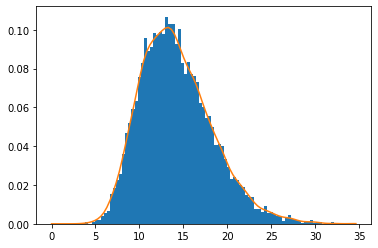

Histogram for F Test feature  1


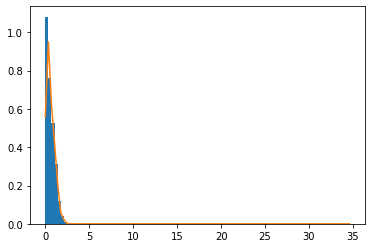

Histogram for F Test feature  2


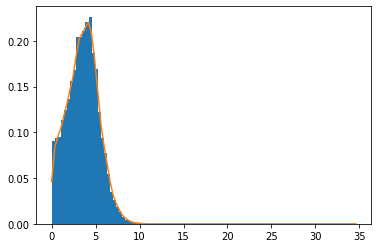

Histogram for F Test feature  3


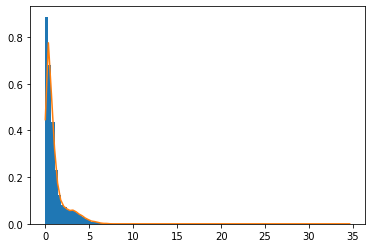

Histogram for F Test feature  4


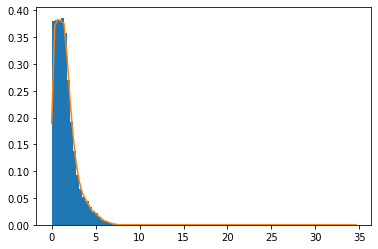

Histogram for F Test feature  5


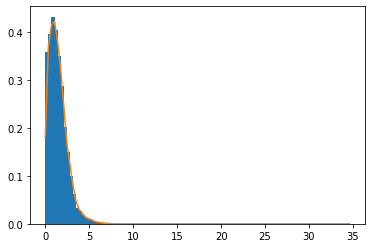

Histogram for F Test feature  6


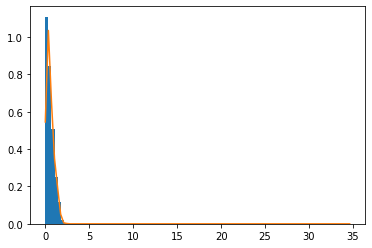

Histogram for F Test feature  7


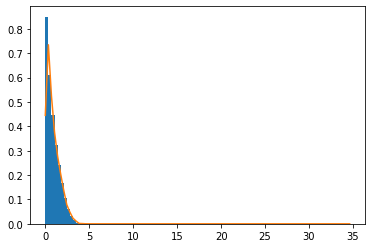

Histogram for F Test feature  8


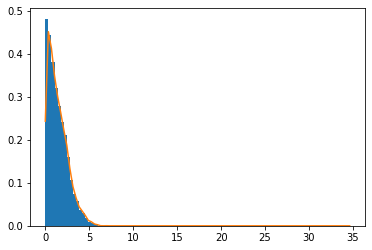

Histogram for F Test feature  9


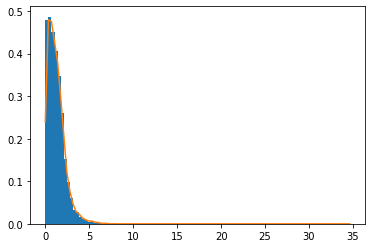

Printing the shape of the input!
torch.Size([40000, 10])
Printing the shape of the target!
torch.Size([40000, 1])


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LR Accuracy within training data - All features :  0.9754
LR Accuracy on test data - All features:  0.81435
Accuracy for without feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.95705
Logistic Regression Accuracy on test data:  0.88055
Accuracy for without feature  1


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.97535
Logistic Regression Accuracy on test data:  0.81325
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.97535
Logistic Regression Accuracy on test data:  0.81425
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.952775
Logistic Regression Accuracy on test data:  0.5307
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9623
Logistic Regression Accuracy on test data:  0.66435
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.975625
Logistic Regression Accuracy on test data:  0.8094
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.95155
Logistic Regression Accuracy on test data:  0.53825
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.974775
Logistic Regression Accuracy on test data:  0.80905
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.975025
Logistic Regression Accuracy on test data:  0.81075
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.975475
Logistic Regression Accuracy on test data:  0.81495




Results for lamda  0.001



array([-1.04055775e+02, -3.99031629e+00, -2.83525633e+00, -2.22972616e+00,
       -1.78258855e+00, -1.45380841e+00, -1.13863626e+00, -1.09109243e+00,
       -7.75328645e-01, -5.95006715e-01, -4.93797021e-01, -4.57249124e-01,
       -3.04879090e-01, -2.67828166e-01, -2.42225023e-01, -1.82230888e-01,
       -1.66759326e-01, -1.59353662e-01, -1.39291724e-01, -1.23888358e-01,
       -1.14809953e-01, -1.07402451e-01, -9.29415045e-02, -8.85494033e-02,
       -8.26936443e-02, -6.08640252e-02, -5.46561214e-02, -4.81484873e-02,
       -3.84859010e-02, -3.69461750e-02, -3.35708516e-02, -3.11488870e-02,
       -2.65974773e-02, -2.36501443e-02, -2.10284859e-02, -1.91471067e-02,
       -1.87822627e-02, -1.57783483e-02, -1.37630385e-02, -1.34607036e-02,
       -1.14390506e-02, -9.17539399e-03, -7.43157849e-03, -6.50137317e-03,
       -5.39496759e-03, -3.92674367e-03, -3.21835542e-03, -2.22080126e-03,
       -1.61396274e-03,  4.83483666e-16])

array([[-0.17572514,  0.1034673 ,  0.18807383, ..., -0.01494526,
        -0.01915632,  0.13611737],
       [-0.15426825,  0.27020975, -0.02300858, ...,  0.00707593,
        -0.02189574,  0.10290048],
       [-0.1456341 , -0.04022917,  0.06666488, ..., -0.02645527,
         0.01363813,  0.09914154],
       ...,
       [-0.206976  ,  0.00646298,  0.02345943, ..., -0.08909256,
        -0.06549629,  0.27322376],
       [-0.15980837,  0.02462029, -0.01737534, ...,  0.00488134,
         0.00883834, -0.1421295 ],
       [-0.09447001, -0.0254726 ,  0.00922575, ...,  0.00287384,
         0.01482583, -0.05337996]])

Printing least k eigenvalues before removing the zero eigenvalue
[-104.05577546   -3.99031629   -2.83525633   -2.22972616   -1.78258855
   -1.45380841   -1.13863626   -1.09109243   -0.77532864   -0.59500671]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-104.05577546   -3.99031629   -2.83525633   -2.22972616   -1.78258855
   -1.45380841   -1.13863626   -1.09109243   -0.77532864]
Printing non zero indeces of the least k-1 eigenvalues
[0 1 2 3 4 5 6 7 8]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9
0,13.997089,0.060178,4.156534,0.719431,2.738819,2.812211,0.540148,0.723074,0.789635,1.329835
1,10.772082,0.078082,3.560675,0.878772,0.439720,0.980599,0.463627,1.487543,2.282559,0.726324
2,20.465802,0.152459,4.553056,0.768676,1.658264,0.640782,0.392240,1.183413,0.100787,1.655484
3,24.265408,0.885474,7.526666,0.315179,1.540696,0.060869,0.352451,1.401164,1.609835,0.677631
4,18.719481,1.322717,7.091702,3.526330,3.411929,1.401771,0.473534,0.398206,2.003895,0.284259


Histogram for F Test feature  0


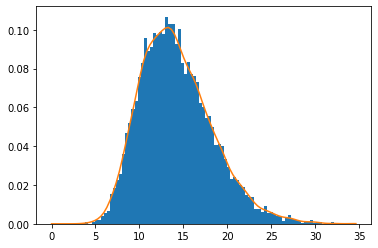

Histogram for F Test feature  1


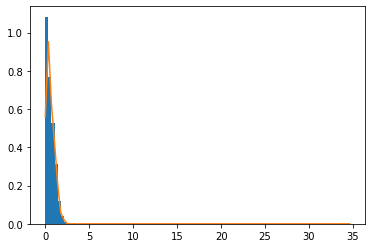

Histogram for F Test feature  2


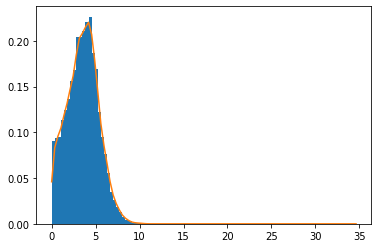

Histogram for F Test feature  3


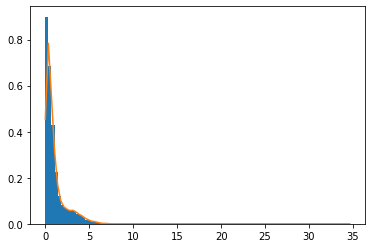

Histogram for F Test feature  4


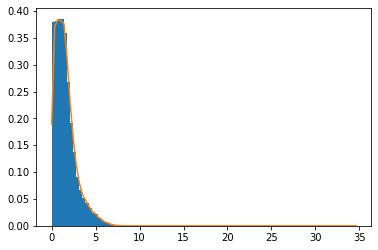

Histogram for F Test feature  5


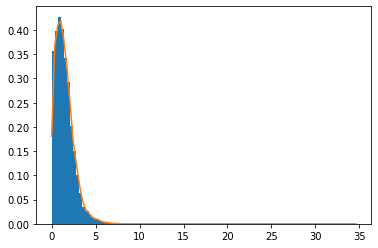

Histogram for F Test feature  6


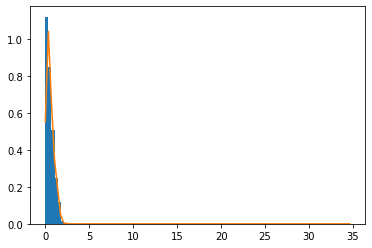

Histogram for F Test feature  7


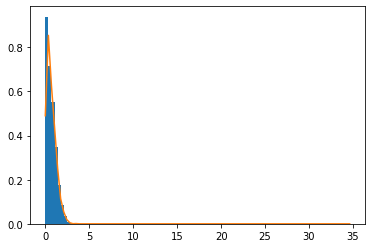

Histogram for F Test feature  8


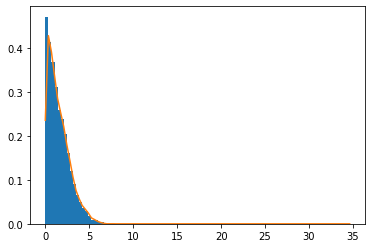

Histogram for F Test feature  9


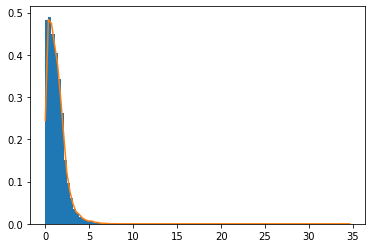

Printing the shape of the input!
torch.Size([40000, 10])
Printing the shape of the target!
torch.Size([40000, 1])


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LR Accuracy within training data - All features :  0.97545
LR Accuracy on test data - All features:  0.8145
Accuracy for without feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9572
Logistic Regression Accuracy on test data:  0.8805
Accuracy for without feature  1
Logistic Regression Accuracy within training data:  0.975375
Logistic Regression Accuracy on test data:  0.81325
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.975425
Logistic Regression Accuracy on test data:  0.81455
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.952425
Logistic Regression Accuracy on test data:  0.5291
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9624
Logistic Regression Accuracy on test data:  0.6672
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9757
Logistic Regression Accuracy on test data:  0.80925
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.951375
Logistic Regression Accuracy on test data:  0.5416
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.974625
Logistic Regression Accuracy on test data:  0.80695
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.97515
Logistic Regression Accuracy on test data:  0.8115
Accuracy for without feature  9
Logistic Regression Accuracy within training data:  0.975575
Logistic Regression Accuracy on test data:  0.81505




Results for lamda  0.0001



/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([-1.04259488e+02, -3.99045921e+00, -2.83755171e+00, -2.23031340e+00,
       -1.78313041e+00, -1.45479536e+00, -1.14060519e+00, -1.09181492e+00,
       -7.75686793e-01, -5.95838709e-01, -4.94411027e-01, -4.57696233e-01,
       -3.05350121e-01, -2.69092524e-01, -2.42739599e-01, -1.83352425e-01,
       -1.67641218e-01, -1.59598380e-01, -1.39753923e-01, -1.24139181e-01,
       -1.15033122e-01, -1.08317835e-01, -9.36089215e-02, -8.88311054e-02,
       -8.48658816e-02, -6.16496357e-02, -5.52323236e-02, -4.83351998e-02,
       -3.88638922e-02, -3.78302070e-02, -3.40295023e-02, -3.17593197e-02,
       -2.67696862e-02, -2.39037621e-02, -2.11625562e-02, -1.92562553e-02,
       -1.91660478e-02, -1.60879871e-02, -1.40385596e-02, -1.35281562e-02,
       -1.19581715e-02, -9.40926377e-03, -7.83752967e-03, -6.60035462e-03,
       -5.47942894e-03, -4.08353780e-03, -3.24787327e-03, -2.23011422e-03,
       -1.62879290e-03, -6.05386909e-16])

array([[-0.17575936,  0.10348422,  0.18813249, ..., -0.01490406,
        -0.01911497,  0.13611737],
       [-0.15425607,  0.2702366 , -0.02315082, ...,  0.00687141,
        -0.02085487,  0.10290048],
       [-0.14553192, -0.04024533,  0.06625811, ..., -0.02312652,
         0.00981744,  0.09914154],
       ...,
       [-0.20712375,  0.00647387,  0.02392258, ..., -0.08806826,
        -0.06550064,  0.27322376],
       [-0.15976551,  0.02459894, -0.01748177, ...,  0.00535927,
         0.00834146, -0.1421295 ],
       [-0.09441835, -0.02546588,  0.00893726, ...,  0.00261591,
         0.01494213, -0.05337996]])

Printing least k eigenvalues before removing the zero eigenvalue
[-104.25948751   -3.99045921   -2.83755171   -2.2303134    -1.78313041
   -1.45479536   -1.14060519   -1.09181492   -0.77568679   -0.59583871]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-104.25948751   -3.99045921   -2.83755171   -2.2303134    -1.78313041
   -1.45479536   -1.14060519   -1.09181492   -0.77568679]
Printing non zero indeces of the least k-1 eigenvalues
[0 1 2 3 4 5 6 7 8]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9
0,13.997089,0.060276,4.156489,0.717698,2.737305,2.814140,0.538326,0.734844,0.779201,1.327988
1,10.772082,0.078133,3.560690,0.877153,0.439904,0.980843,0.463011,1.453217,2.305022,0.726957
2,20.465802,0.152717,4.553050,0.770339,1.657409,0.642094,0.391989,1.183813,0.082249,1.655838
3,24.265408,0.884969,7.526757,0.311842,1.541153,0.061882,0.351748,1.375809,1.633187,0.677345
4,18.719481,1.321865,7.091699,3.525617,3.412741,1.404019,0.473446,0.368464,2.008743,0.281619


Histogram for F Test feature  0


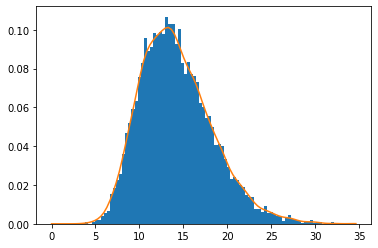

Histogram for F Test feature  1


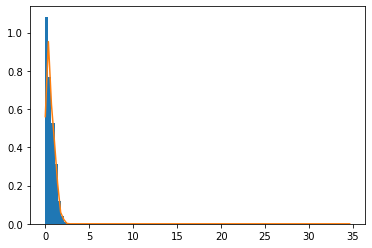

Histogram for F Test feature  2


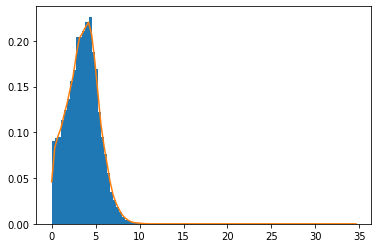

Histogram for F Test feature  3


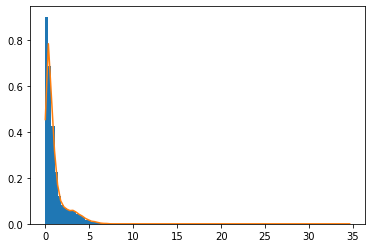

Histogram for F Test feature  4


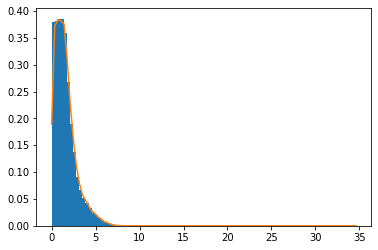

Histogram for F Test feature  5


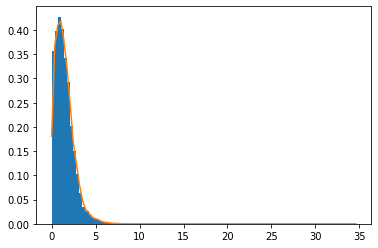

Histogram for F Test feature  6


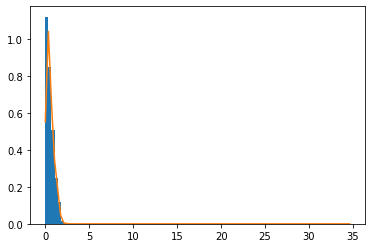

Histogram for F Test feature  7


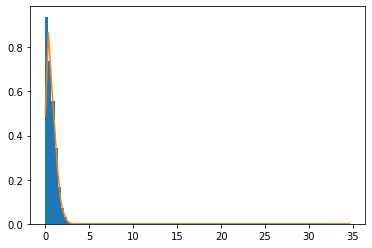

Histogram for F Test feature  8


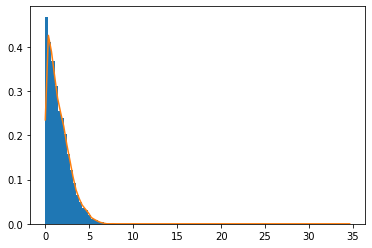

Histogram for F Test feature  9


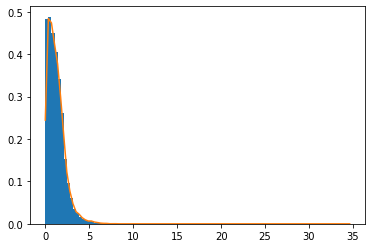

Printing the shape of the input!
torch.Size([40000, 10])
Printing the shape of the target!
torch.Size([40000, 1])


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LR Accuracy within training data - All features :  0.97545
LR Accuracy on test data - All features:  0.8145
Accuracy for without feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9572
Logistic Regression Accuracy on test data:  0.8805
Accuracy for without feature  1
Logistic Regression Accuracy within training data:  0.97535
Logistic Regression Accuracy on test data:  0.81325
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9754
Logistic Regression Accuracy on test data:  0.8146
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9524
Logistic Regression Accuracy on test data:  0.52885
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.962425
Logistic Regression Accuracy on test data:  0.6677
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.975625
Logistic Regression Accuracy on test data:  0.80935
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9514
Logistic Regression Accuracy on test data:  0.54185
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9746
Logistic Regression Accuracy on test data:  0.8068
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.975175
Logistic Regression Accuracy on test data:  0.81165
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.975575
Logistic Regression Accuracy on test data:  0.815




Results for lamda  1e-05



array([-1.04279861e+02, -3.99047351e+00, -2.83778155e+00, -2.23037214e+00,
       -1.78318458e+00, -1.45489425e+00, -1.14080330e+00, -1.09188624e+00,
       -7.75722803e-01, -5.95922375e-01, -4.94472586e-01, -4.57740926e-01,
       -3.05398018e-01, -2.69222648e-01, -2.42792025e-01, -1.83470039e-01,
       -1.67729642e-01, -1.59622790e-01, -1.39801519e-01, -1.24165711e-01,
       -1.15056552e-01, -1.08417328e-01, -9.36877923e-02, -8.88595059e-02,
       -8.50705749e-02, -6.17253508e-02, -5.52874571e-02, -4.83542378e-02,
       -3.89254283e-02, -3.79032656e-02, -3.40794711e-02, -3.18074342e-02,
       -2.67870696e-02, -2.39290957e-02, -2.11763138e-02, -1.92762989e-02,
       -1.91948409e-02, -1.61196575e-02, -1.40646482e-02, -1.35348981e-02,
       -1.20069163e-02, -9.43054572e-03, -7.87075151e-03, -6.60789691e-03,
       -5.48659591e-03, -4.09534316e-03, -3.25042911e-03, -2.23101471e-03,
       -1.63019659e-03,  3.59248562e-16])

array([[-0.17576277,  0.10348591,  0.18813833, ..., -0.01490063,
        -0.01910925,  0.13611737],
       [-0.15425486,  0.27023929, -0.02316503, ...,  0.00685052,
        -0.02075665,  0.10290048],
       [-0.14552172, -0.04024695,  0.06621738, ..., -0.02288489,
         0.00954181,  0.09914154],
       ...,
       [-0.20713849,  0.00647497,  0.02396893, ..., -0.08798942,
        -0.06548733,  0.27322376],
       [-0.15976124,  0.0245968 , -0.01749244, ...,  0.00539352,
         0.00830788, -0.1421295 ],
       [-0.09441319, -0.02546521,  0.00890841, ...,  0.00259557,
         0.01494971, -0.05337996]])

Printing least k eigenvalues before removing the zero eigenvalue
[-104.27986112   -3.99047351   -2.83778155   -2.23037214   -1.78318458
   -1.45489425   -1.1408033    -1.09188624   -0.7757228    -0.59592238]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-104.27986112   -3.99047351   -2.83778155   -2.23037214   -1.78318458
   -1.45489425   -1.1408033    -1.09188624   -0.7757228 ]
Printing non zero indeces of the least k-1 eigenvalues
[0 1 2 3 4 5 6 7 8]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9
0,13.997089,0.060285,4.156484,0.717525,2.737153,2.814333,0.538143,0.735981,0.778178,1.327801
1,10.772082,0.078138,3.560692,0.876991,0.439922,0.980868,0.462950,1.449861,2.307180,0.727021
2,20.465802,0.152742,4.553050,0.770505,1.657323,0.642225,0.391963,1.183835,0.080445,1.655874
3,24.265408,0.884919,7.526766,0.311509,1.541199,0.061983,0.351677,1.373320,1.635445,0.677317
4,18.719481,1.321780,7.091698,3.525545,3.412822,1.404244,0.473437,0.365570,2.009187,0.281352


Histogram for F Test feature  0


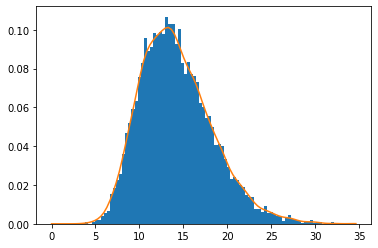

Histogram for F Test feature  1


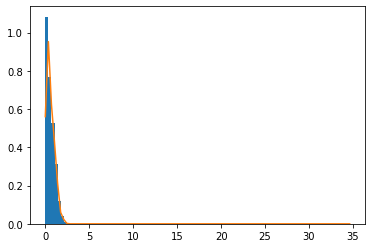

Histogram for F Test feature  2


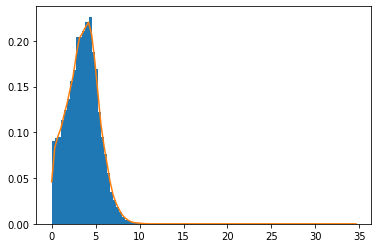

Histogram for F Test feature  3


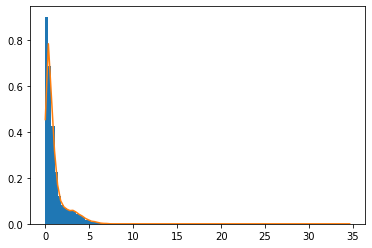

Histogram for F Test feature  4


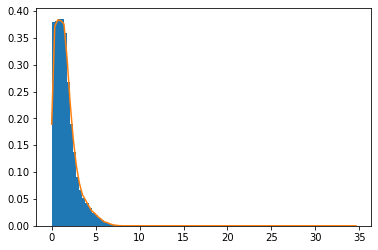

Histogram for F Test feature  5


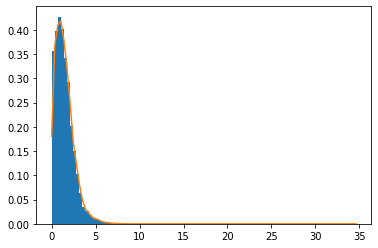

Histogram for F Test feature  6


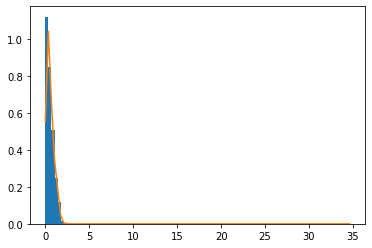

Histogram for F Test feature  7


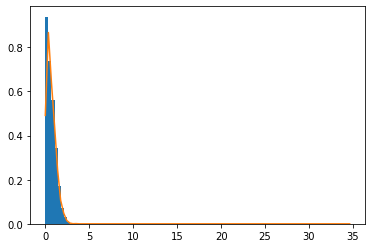

Histogram for F Test feature  8


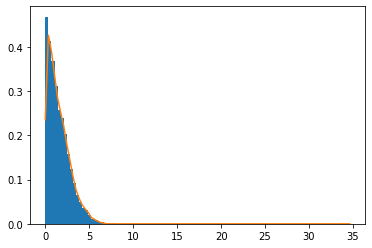

Histogram for F Test feature  9


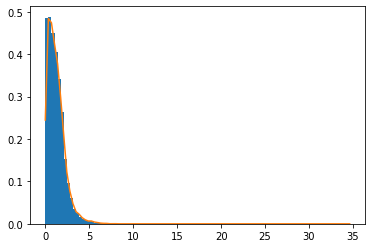

Printing the shape of the input!
torch.Size([40000, 10])
Printing the shape of the target!
torch.Size([40000, 1])


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LR Accuracy within training data - All features :  0.97545
LR Accuracy on test data - All features:  0.8145
Accuracy for without feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9572
Logistic Regression Accuracy on test data:  0.8805
Accuracy for without feature  1


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.97535
Logistic Regression Accuracy on test data:  0.81325
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9754
Logistic Regression Accuracy on test data:  0.8146
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9524
Logistic Regression Accuracy on test data:  0.52885
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.962425
Logistic Regression Accuracy on test data:  0.6677
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.975625
Logistic Regression Accuracy on test data:  0.80935
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.951425
Logistic Regression Accuracy on test data:  0.54195
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.974575
Logistic Regression Accuracy on test data:  0.8068
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.975175
Logistic Regression Accuracy on test data:  0.8116
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.975575
Logistic Regression Accuracy on test data:  0.815




Results for lamda  1e-06



array([-1.04281899e+02, -3.99047494e+00, -2.83780454e+00, -2.23037801e+00,
       -1.78319000e+00, -1.45490414e+00, -1.14082312e+00, -1.09189336e+00,
       -7.75726406e-01, -5.95930746e-01, -4.94478743e-01, -4.57745395e-01,
       -3.05402816e-01, -2.69235698e-01, -2.42797277e-01, -1.83481857e-01,
       -1.67738486e-01, -1.59625231e-01, -1.39806294e-01, -1.24168381e-01,
       -1.15058908e-01, -1.08427361e-01, -9.36958151e-02, -8.88623485e-02,
       -8.50908794e-02, -6.17328940e-02, -5.52929482e-02, -4.83561458e-02,
       -3.89319237e-02, -3.79103045e-02, -3.40844967e-02, -3.18121285e-02,
       -2.67888100e-02, -2.39316288e-02, -2.11776936e-02, -1.92786019e-02,
       -1.91974132e-02, -1.61228279e-02, -1.40672406e-02, -1.35355729e-02,
       -1.20117501e-02, -9.43265309e-03, -7.87400846e-03, -6.60863684e-03,
       -5.48730352e-03, -4.09649634e-03, -3.25068227e-03, -2.23110454e-03,
       -1.63033634e-03,  4.14553585e-16])

array([[-0.17576311,  0.10348608,  0.18813891, ..., -0.01490029,
        -0.01910867,  0.13611737],
       [-0.15425473,  0.27023956, -0.02316645, ...,  0.00684843,
        -0.02074688,  0.10290048],
       [-0.1455207 , -0.04024711,  0.0662133 , ..., -0.02286134,
         0.009515  ,  0.09914154],
       ...,
       [-0.20713996,  0.00647507,  0.02397357, ..., -0.08798169,
        -0.0654859 ,  0.27322376],
       [-0.15976081,  0.02459659, -0.0174935 , ...,  0.00539685,
         0.00830463, -0.1421295 ],
       [-0.09441267, -0.02546514,  0.00890552, ...,  0.00259358,
         0.01495044, -0.05337996]])

Printing least k eigenvalues before removing the zero eigenvalue
[-104.28189851   -3.99047494   -2.83780454   -2.23037801   -1.78319
   -1.45490414   -1.14082312   -1.09189336   -0.77572641   -0.59593075]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-104.28189851   -3.99047494   -2.83780454   -2.23037801   -1.78319
   -1.45490414   -1.14082312   -1.09189336   -0.77572641]
Printing non zero indeces of the least k-1 eigenvalues
[0 1 2 3 4 5 6 7 8]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9
0,13.997089,0.060286,4.156484,0.717508,2.737138,2.814352,0.538125,0.736095,0.778076,1.327782
1,10.772082,0.078138,3.560692,0.876974,0.439924,0.980870,0.462943,1.449526,2.307395,0.727027
2,20.465802,0.152745,4.553050,0.770522,1.657314,0.642238,0.391961,1.183837,0.080265,1.655877
3,24.265408,0.884914,7.526767,0.311475,1.541203,0.061993,0.351670,1.373071,1.635670,0.677314
4,18.719481,1.321771,7.091698,3.525538,3.412830,1.404266,0.473436,0.365281,2.009231,0.281325


Histogram for F Test feature  0


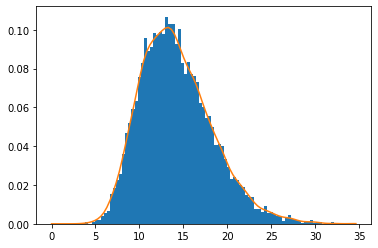

Histogram for F Test feature  1


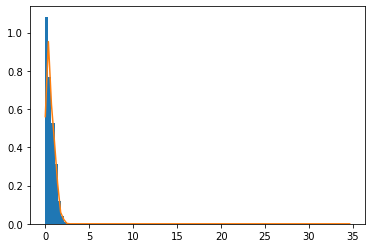

Histogram for F Test feature  2


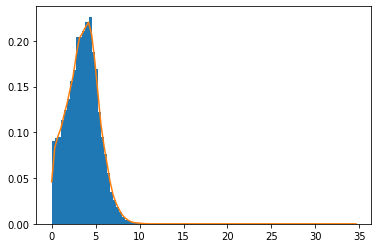

Histogram for F Test feature  3


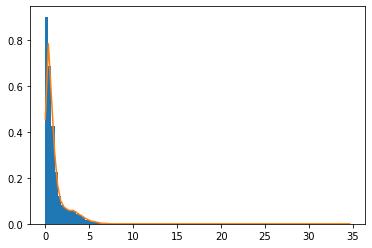

Histogram for F Test feature  4


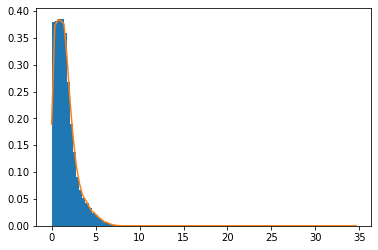

Histogram for F Test feature  5


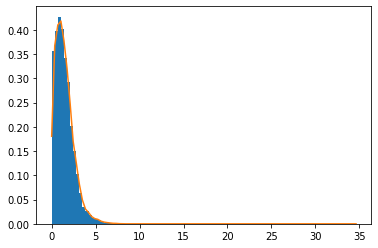

Histogram for F Test feature  6


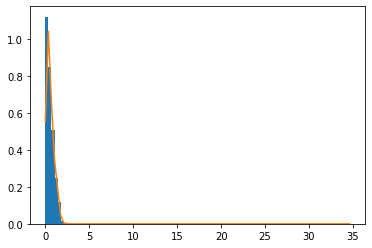

Histogram for F Test feature  7


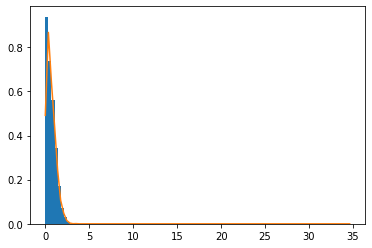

Histogram for F Test feature  8


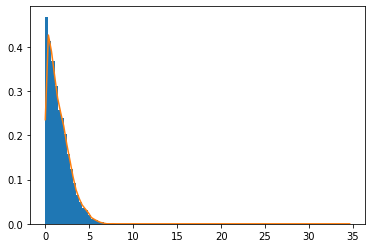

Histogram for F Test feature  9


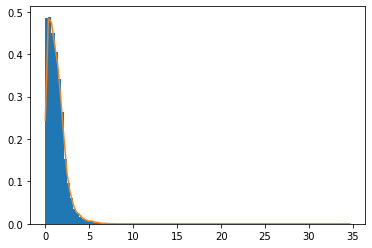

Printing the shape of the input!
torch.Size([40000, 10])
Printing the shape of the target!
torch.Size([40000, 1])


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LR Accuracy within training data - All features :  0.97545
LR Accuracy on test data - All features:  0.8145
Accuracy for without feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9572
Logistic Regression Accuracy on test data:  0.8805
Accuracy for without feature  1


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.97535
Logistic Regression Accuracy on test data:  0.81325
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9754
Logistic Regression Accuracy on test data:  0.8146
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9524
Logistic Regression Accuracy on test data:  0.52885
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.962425
Logistic Regression Accuracy on test data:  0.6677
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.975625
Logistic Regression Accuracy on test data:  0.80935
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.951425
Logistic Regression Accuracy on test data:  0.54195
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.974575
Logistic Regression Accuracy on test data:  0.80685
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.975175
Logistic Regression Accuracy on test data:  0.8116
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.975575
Logistic Regression Accuracy on test data:  0.815




Results for lamda  1e-07



array([-1.04282102e+02, -3.99047508e+00, -2.83780683e+00, -2.23037860e+00,
       -1.78319054e+00, -1.45490513e+00, -1.14082510e+00, -1.09189407e+00,
       -7.75726766e-01, -5.95931584e-01, -4.94479359e-01, -4.57745842e-01,
       -3.05403296e-01, -2.69237004e-01, -2.42797803e-01, -1.83483040e-01,
       -1.67739370e-01, -1.59625475e-01, -1.39806771e-01, -1.24168648e-01,
       -1.15059144e-01, -1.08428365e-01, -9.36966188e-02, -8.88626328e-02,
       -8.50929081e-02, -6.17336480e-02, -5.52934971e-02, -4.83563367e-02,
       -3.89325767e-02, -3.79110056e-02, -3.40849996e-02, -3.18125968e-02,
       -2.67889840e-02, -2.39318822e-02, -2.11778317e-02, -1.92788354e-02,
       -1.91976671e-02, -1.61231450e-02, -1.40674997e-02, -1.35356404e-02,
       -1.20122330e-02, -9.43286362e-03, -7.87433351e-03, -6.60871069e-03,
       -5.48737419e-03, -4.09661139e-03, -3.25070757e-03, -2.23111352e-03,
       -1.63035031e-03, -1.08053581e-16])

array([[-0.17576315,  0.1034861 ,  0.18813897, ..., -0.01490026,
        -0.01910861,  0.13611737],
       [-0.15425472,  0.27023959, -0.0231666 , ...,  0.00684823,
        -0.02074591,  0.10290048],
       [-0.1455206 , -0.04024713,  0.0662129 , ..., -0.022859  ,
         0.00951232,  0.09914154],
       ...,
       [-0.20714011,  0.00647509,  0.02397403, ..., -0.08798092,
        -0.06548576,  0.27322376],
       [-0.15976076,  0.02459657, -0.01749361, ...,  0.00539718,
         0.00830431, -0.1421295 ],
       [-0.09441262, -0.02546513,  0.00890524, ...,  0.00259338,
         0.01495051, -0.05337996]])

Printing least k eigenvalues before removing the zero eigenvalue
[-104.28210225   -3.99047508   -2.83780683   -2.2303786    -1.78319054
   -1.45490513   -1.1408251    -1.09189407   -0.77572677   -0.59593158]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-104.28210225   -3.99047508   -2.83780683   -2.2303786    -1.78319054
   -1.45490513   -1.1408251    -1.09189407   -0.77572677]
Printing non zero indeces of the least k-1 eigenvalues
[0 1 2 3 4 5 6 7 8]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9
0,13.997089,0.060286,4.156484,0.717506,2.737137,2.814354,0.538123,0.736106,0.778066,1.327780
1,10.772082,0.078138,3.560692,0.876973,0.439924,0.980870,0.462943,1.449492,2.307417,0.727028
2,20.465802,0.152745,4.553050,0.770523,1.657314,0.642239,0.391960,1.183837,0.080247,1.655877
3,24.265408,0.884913,7.526767,0.311472,1.541204,0.061994,0.351669,1.373046,1.635693,0.677314
4,18.719481,1.321771,7.091698,3.525537,3.412831,1.404268,0.473436,0.365252,2.009236,0.281322


Histogram for F Test feature  0


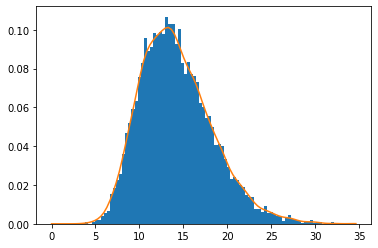

Histogram for F Test feature  1


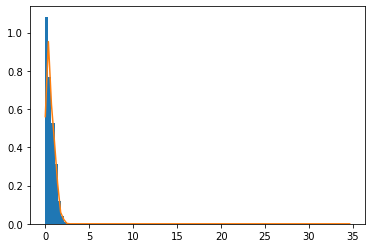

Histogram for F Test feature  2


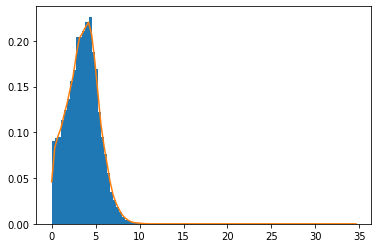

Histogram for F Test feature  3


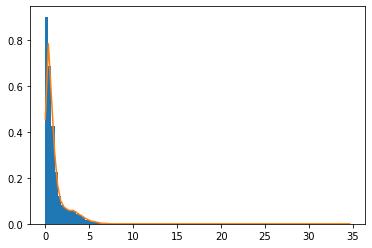

Histogram for F Test feature  4


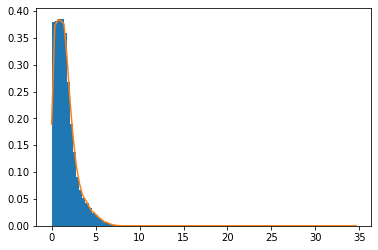

Histogram for F Test feature  5


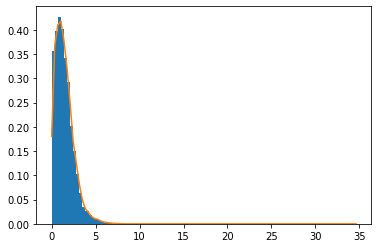

Histogram for F Test feature  6


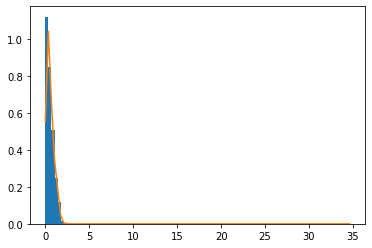

Histogram for F Test feature  7


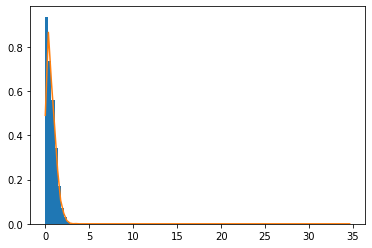

Histogram for F Test feature  8


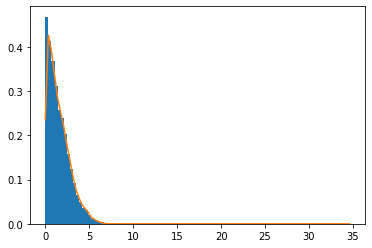

Histogram for F Test feature  9


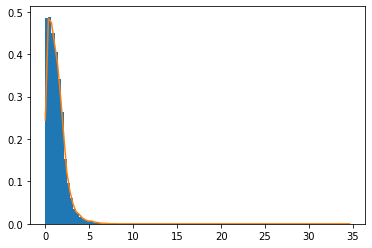

Printing the shape of the input!
torch.Size([40000, 10])
Printing the shape of the target!
torch.Size([40000, 1])


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LR Accuracy within training data - All features :  0.97545
LR Accuracy on test data - All features:  0.8145
Accuracy for without feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9572
Logistic Regression Accuracy on test data:  0.8805
Accuracy for without feature  1
Logistic Regression Accuracy within training data:  0.97535


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy on test data:  0.81325
Accuracy for without feature  2
Logistic Regression Accuracy within training data:  0.9754
Logistic Regression Accuracy on test data:  0.8146
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9524
Logistic Regression Accuracy on test data:  0.52885
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.962425
Logistic Regression Accuracy on test data:  0.6678
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.975625
Logistic Regression Accuracy on test data:  0.80935
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.951425
Logistic Regression Accuracy on test data:  0.54195
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.974575
Logistic Regression Accuracy on test data:  0.80685
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.975175
Logistic Regression Accuracy on test data:  0.8116
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.975575
Logistic Regression Accuracy on test data:  0.815




Results for lamda  1e-08



array([-1.04282123e+02, -3.99047510e+00, -2.83780706e+00, -2.23037866e+00,
       -1.78319060e+00, -1.45490523e+00, -1.14082530e+00, -1.09189414e+00,
       -7.75726802e-01, -5.95931667e-01, -4.94479420e-01, -4.57745886e-01,
       -3.05403344e-01, -2.69237134e-01, -2.42797855e-01, -1.83483158e-01,
       -1.67739459e-01, -1.59625499e-01, -1.39806819e-01, -1.24168674e-01,
       -1.15059167e-01, -1.08428465e-01, -9.36966992e-02, -8.88626612e-02,
       -8.50931110e-02, -6.17337234e-02, -5.52935519e-02, -4.83563558e-02,
       -3.89326420e-02, -3.79110757e-02, -3.40850499e-02, -3.18126436e-02,
       -2.67890014e-02, -2.39319075e-02, -2.11778455e-02, -1.92788587e-02,
       -1.91976925e-02, -1.61231767e-02, -1.40675256e-02, -1.35356472e-02,
       -1.20122813e-02, -9.43288467e-03, -7.87436601e-03, -6.60871808e-03,
       -5.48738126e-03, -4.09662289e-03, -3.25071010e-03, -2.23111442e-03,
       -1.63035171e-03, -4.40376656e-17])

array([[-0.17576315,  0.1034861 ,  0.18813898, ..., -0.01490025,
        -0.0191086 ,  0.13611737],
       [-0.15425472,  0.27023959, -0.02316661, ...,  0.00684821,
        -0.02074581,  0.10290048],
       [-0.14552059, -0.04024713,  0.06621285, ..., -0.02285876,
         0.00951206,  0.09914154],
       ...,
       [-0.20714012,  0.00647509,  0.02397408, ..., -0.08798085,
        -0.06548574,  0.27322376],
       [-0.15976076,  0.02459657, -0.01749362, ...,  0.00539722,
         0.00830428, -0.1421295 ],
       [-0.09441262, -0.02546513,  0.00890521, ...,  0.00259336,
         0.01495052, -0.05337996]])

Printing least k eigenvalues before removing the zero eigenvalue
[-104.28212262   -3.9904751    -2.83780706   -2.23037866   -1.7831906
   -1.45490523   -1.1408253    -1.09189414   -0.7757268    -0.59593167]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-104.28212262   -3.9904751    -2.83780706   -2.23037866   -1.7831906
   -1.45490523   -1.1408253    -1.09189414   -0.7757268 ]
Printing non zero indeces of the least k-1 eigenvalues
[0 1 2 3 4 5 6 7 8]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9
0,13.997089,0.060287,4.156484,0.717506,2.737137,2.814354,0.538123,0.736107,0.778065,1.327780
1,10.772082,0.078138,3.560692,0.876973,0.439924,0.980870,0.462943,1.449489,2.307419,0.727028
2,20.465802,0.152745,4.553050,0.770524,1.657313,0.642239,0.391960,1.183837,0.080245,1.655877
3,24.265408,0.884913,7.526767,0.311472,1.541204,0.061994,0.351669,1.373044,1.635695,0.677314
4,18.719481,1.321770,7.091698,3.525537,3.412831,1.404269,0.473436,0.365249,2.009236,0.281322


Histogram for F Test feature  0


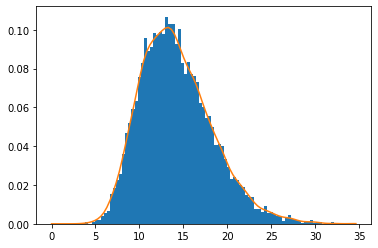

Histogram for F Test feature  1


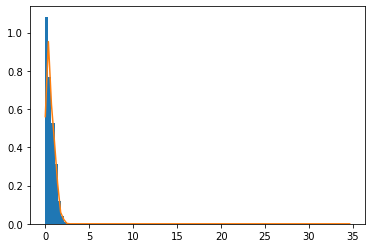

Histogram for F Test feature  2


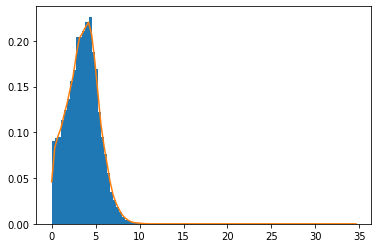

Histogram for F Test feature  3


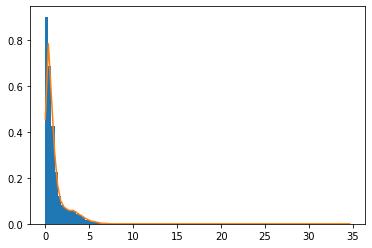

Histogram for F Test feature  4


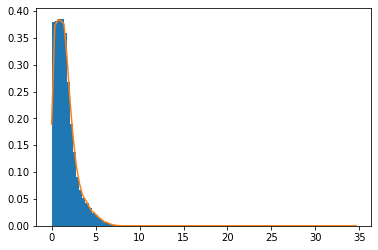

Histogram for F Test feature  5


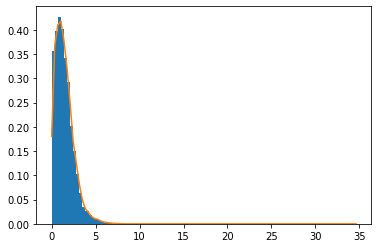

Histogram for F Test feature  6


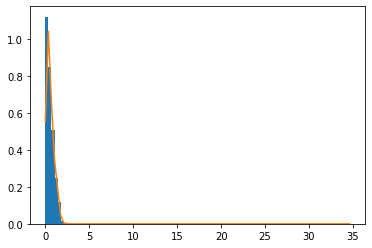

Histogram for F Test feature  7


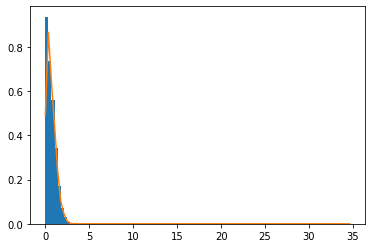

Histogram for F Test feature  8


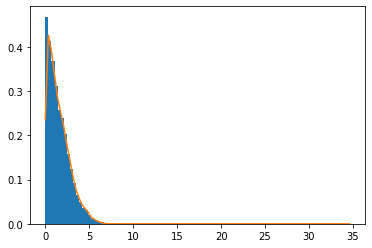

Histogram for F Test feature  9


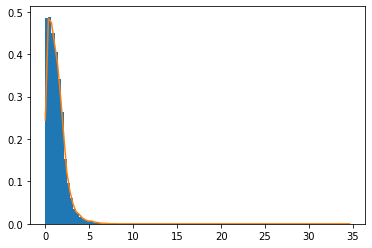

Printing the shape of the input!
torch.Size([40000, 10])
Printing the shape of the target!
torch.Size([40000, 1])


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LR Accuracy within training data - All features :  0.97545
LR Accuracy on test data - All features:  0.8145
Accuracy for without feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9572
Logistic Regression Accuracy on test data:  0.8805
Accuracy for without feature  1


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.97535
Logistic Regression Accuracy on test data:  0.81325
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9754
Logistic Regression Accuracy on test data:  0.8146
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9524
Logistic Regression Accuracy on test data:  0.52885
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.962425
Logistic Regression Accuracy on test data:  0.6677
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.975625
Logistic Regression Accuracy on test data:  0.80935
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.951425
Logistic Regression Accuracy on test data:  0.54195
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.974575
Logistic Regression Accuracy on test data:  0.80685
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.975175
Logistic Regression Accuracy on test data:  0.8116
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.975575
Logistic Regression Accuracy on test data:  0.815




Results for lamda  1e-09



array([-1.04282125e+02, -3.99047510e+00, -2.83780709e+00, -2.23037866e+00,
       -1.78319060e+00, -1.45490524e+00, -1.14082532e+00, -1.09189415e+00,
       -7.75726806e-01, -5.95931676e-01, -4.94479427e-01, -4.57745891e-01,
       -3.05403349e-01, -2.69237147e-01, -2.42797861e-01, -1.83483170e-01,
       -1.67739468e-01, -1.59625501e-01, -1.39806824e-01, -1.24168677e-01,
       -1.15059170e-01, -1.08428475e-01, -9.36967072e-02, -8.88626641e-02,
       -8.50931313e-02, -6.17337310e-02, -5.52935574e-02, -4.83563577e-02,
       -3.89326486e-02, -3.79110827e-02, -3.40850549e-02, -3.18126483e-02,
       -2.67890032e-02, -2.39319100e-02, -2.11778469e-02, -1.92788611e-02,
       -1.91976950e-02, -1.61231798e-02, -1.40675282e-02, -1.35356478e-02,
       -1.20122861e-02, -9.43288678e-03, -7.87436926e-03, -6.60871882e-03,
       -5.48738196e-03, -4.09662404e-03, -3.25071035e-03, -2.23111451e-03,
       -1.63035185e-03, -3.44851145e-15])

array([[-0.17576315,  0.1034861 ,  0.18813898, ..., -0.01490025,
        -0.0191086 ,  0.13611737],
       [-0.15425472,  0.27023959, -0.02316661, ...,  0.0068482 ,
        -0.0207458 ,  0.10290048],
       [-0.14552059, -0.04024713,  0.06621285, ..., -0.02285874,
         0.00951203,  0.09914154],
       ...,
       [-0.20714013,  0.00647509,  0.02397408, ..., -0.08798084,
        -0.06548574,  0.27322376],
       [-0.15976076,  0.02459657, -0.01749362, ...,  0.00539722,
         0.00830427, -0.1421295 ],
       [-0.09441262, -0.02546513,  0.0089052 , ...,  0.00259335,
         0.01495052, -0.05337996]])

Printing least k eigenvalues before removing the zero eigenvalue
[-104.28212466   -3.9904751    -2.83780709   -2.23037866   -1.7831906
   -1.45490524   -1.14082532   -1.09189415   -0.77572681   -0.59593168]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-104.28212466   -3.9904751    -2.83780709   -2.23037866   -1.7831906
   -1.45490524   -1.14082532   -1.09189415   -0.77572681]
Printing non zero indeces of the least k-1 eigenvalues
[0 1 2 3 4 5 6 7 8]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9
0,13.997089,0.060287,4.156484,0.717506,2.737137,2.814354,0.538123,0.736107,0.778065,1.327780
1,10.772082,0.078138,3.560692,0.876973,0.439924,0.980870,0.462943,1.449489,2.307419,0.727028
2,20.465802,0.152745,4.553050,0.770524,1.657313,0.642239,0.391960,1.183837,0.080245,1.655877
3,24.265408,0.884913,7.526767,0.311472,1.541204,0.061994,0.351669,1.373044,1.635695,0.677314
4,18.719481,1.321770,7.091698,3.525537,3.412831,1.404269,0.473436,0.365249,2.009236,0.281322


Histogram for F Test feature  0


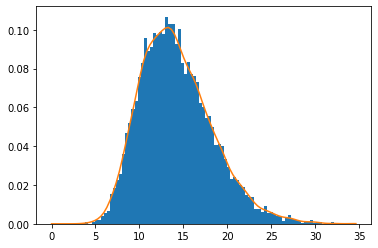

Histogram for F Test feature  1


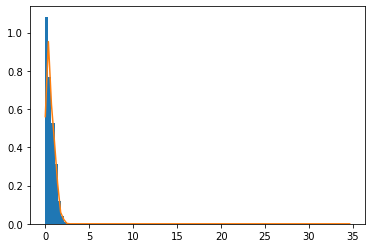

Histogram for F Test feature  2


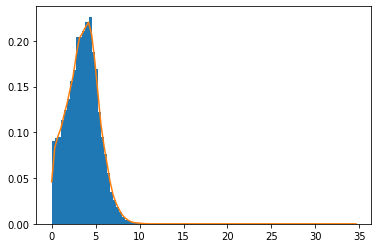

Histogram for F Test feature  3


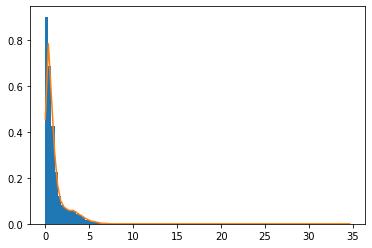

Histogram for F Test feature  4


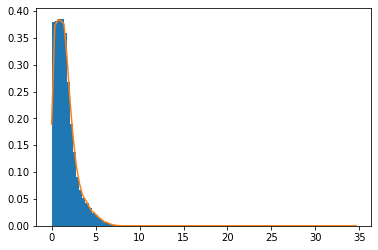

Histogram for F Test feature  5


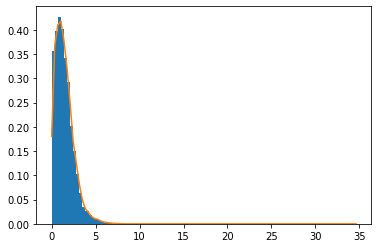

Histogram for F Test feature  6


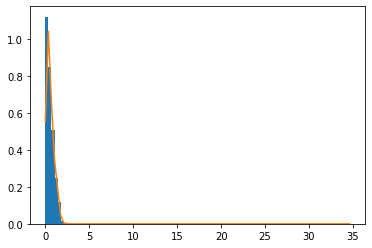

Histogram for F Test feature  7


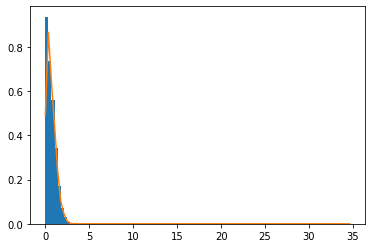

Histogram for F Test feature  8


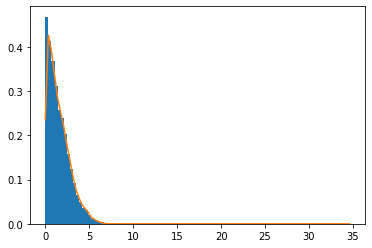

Histogram for F Test feature  9


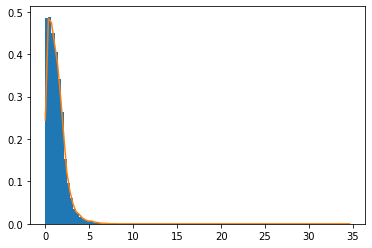

Printing the shape of the input!
torch.Size([40000, 10])
Printing the shape of the target!
torch.Size([40000, 1])


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LR Accuracy within training data - All features :  0.97545
LR Accuracy on test data - All features:  0.8145
Accuracy for without feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9572
Logistic Regression Accuracy on test data:  0.8805
Accuracy for without feature  1


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.97535
Logistic Regression Accuracy on test data:  0.81325
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9754
Logistic Regression Accuracy on test data:  0.8146
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9524
Logistic Regression Accuracy on test data:  0.52885
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.962425
Logistic Regression Accuracy on test data:  0.6677
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.975625
Logistic Regression Accuracy on test data:  0.80935
Accuracy for without feature  6
Logistic Regression Accuracy within training data:  0.951425
Logistic Regression Accuracy on test data:  0.54195
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.974575
Logistic Regression Accuracy on test data:  0.80685
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.975175
Logistic Regression Accuracy on test data:  0.8116
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.975575
Logistic Regression Accuracy on test data:  0.815




Results for lamda  1e-10



array([-1.04282125e+02, -3.99047510e+00, -2.83780709e+00, -2.23037866e+00,
       -1.78319060e+00, -1.45490524e+00, -1.14082532e+00, -1.09189415e+00,
       -7.75726806e-01, -5.95931677e-01, -4.94479427e-01, -4.57745891e-01,
       -3.05403350e-01, -2.69237148e-01, -2.42797861e-01, -1.83483171e-01,
       -1.67739469e-01, -1.59625502e-01, -1.39806824e-01, -1.24168677e-01,
       -1.15059170e-01, -1.08428476e-01, -9.36967080e-02, -8.88626644e-02,
       -8.50931333e-02, -6.17337317e-02, -5.52935580e-02, -4.83563579e-02,
       -3.89326492e-02, -3.79110834e-02, -3.40850554e-02, -3.18126487e-02,
       -2.67890034e-02, -2.39319103e-02, -2.11778470e-02, -1.92788613e-02,
       -1.91976953e-02, -1.61231802e-02, -1.40675285e-02, -1.35356479e-02,
       -1.20122866e-02, -9.43288699e-03, -7.87436959e-03, -6.60871889e-03,
       -5.48738203e-03, -4.09662416e-03, -3.25071037e-03, -2.23111451e-03,
       -1.63035186e-03,  2.12886114e-16])

array([[-0.17576315,  0.1034861 ,  0.18813898, ..., -0.01490025,
        -0.0191086 ,  0.13611737],
       [-0.15425472,  0.27023959, -0.02316661, ...,  0.0068482 ,
        -0.0207458 ,  0.10290048],
       [-0.14552059, -0.04024713,  0.06621285, ..., -0.02285873,
         0.00951203,  0.09914154],
       ...,
       [-0.20714013,  0.00647509,  0.02397408, ..., -0.08798084,
        -0.06548574,  0.27322376],
       [-0.15976076,  0.02459657, -0.01749362, ...,  0.00539722,
         0.00830427, -0.1421295 ],
       [-0.09441262, -0.02546513,  0.0089052 , ...,  0.00259335,
         0.01495052, -0.05337996]])

Printing least k eigenvalues before removing the zero eigenvalue
[-104.28212486   -3.9904751    -2.83780709   -2.23037866   -1.7831906
   -1.45490524   -1.14082532   -1.09189415   -0.77572681   -0.59593168]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-104.28212486   -3.9904751    -2.83780709   -2.23037866   -1.7831906
   -1.45490524   -1.14082532   -1.09189415   -0.77572681]
Printing non zero indeces of the least k-1 eigenvalues
[0 1 2 3 4 5 6 7 8]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9
0,13.997089,0.060287,4.156484,0.717506,2.737137,2.814354,0.538123,0.736107,0.778065,1.327780
1,10.772082,0.078138,3.560692,0.876973,0.439924,0.980870,0.462943,1.449489,2.307419,0.727028
2,20.465802,0.152745,4.553050,0.770524,1.657313,0.642239,0.391960,1.183837,0.080245,1.655877
3,24.265408,0.884913,7.526767,0.311472,1.541204,0.061994,0.351669,1.373044,1.635695,0.677314
4,18.719481,1.321770,7.091698,3.525537,3.412831,1.404269,0.473436,0.365249,2.009236,0.281322


Histogram for F Test feature  0


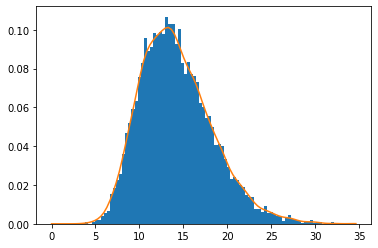

Histogram for F Test feature  1


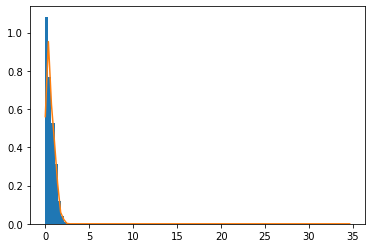

Histogram for F Test feature  2


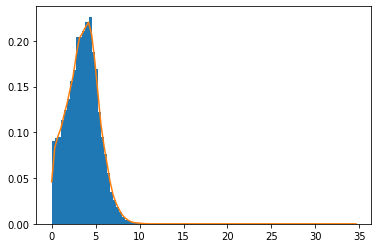

Histogram for F Test feature  3


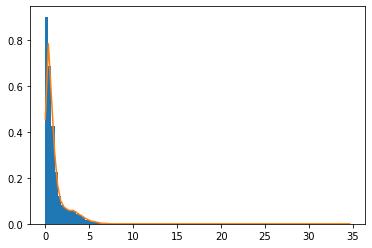

Histogram for F Test feature  4


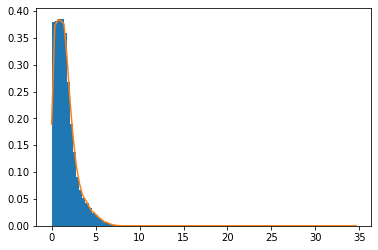

Histogram for F Test feature  5


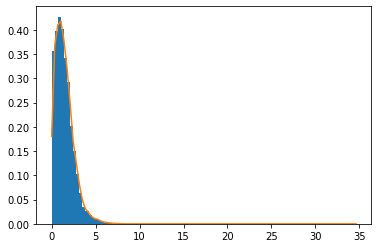

Histogram for F Test feature  6


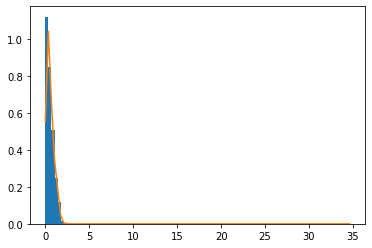

Histogram for F Test feature  7


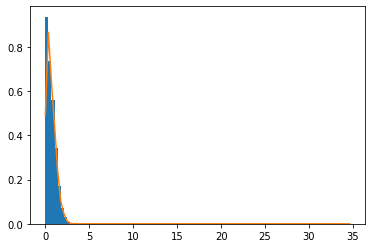

Histogram for F Test feature  8


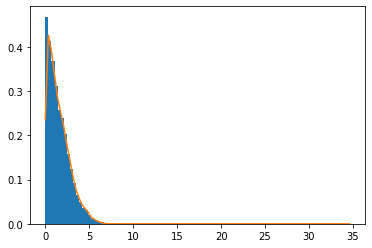

Histogram for F Test feature  9


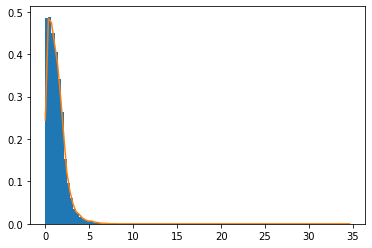

Printing the shape of the input!
torch.Size([40000, 10])
Printing the shape of the target!
torch.Size([40000, 1])


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LR Accuracy within training data - All features :  0.97545
LR Accuracy on test data - All features:  0.8145
Accuracy for without feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9572
Logistic Regression Accuracy on test data:  0.8805
Accuracy for without feature  1
Logistic Regression Accuracy within training data:  0.97535
Logistic Regression Accuracy on test data:  0.81325
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9754
Logistic Regression Accuracy on test data:  0.8146
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9524
Logistic Regression Accuracy on test data:  0.52885
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.962425
Logistic Regression Accuracy on test data:  0.6677
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.975625
Logistic Regression Accuracy on test data:  0.80935
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.951425
Logistic Regression Accuracy on test data:  0.54195
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.974575
Logistic Regression Accuracy on test data:  0.80685
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.975175
Logistic Regression Accuracy on test data:  0.8116
Accuracy for without feature  9
Logistic Regression Accuracy within training data:  0.975575
Logistic Regression Accuracy on test data:  0.815


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [24]:
# Computing M
lamdas = [100000,10,9,8,7,6,5,4,3,2,1,0.1,0.01,0.001,0.0001,0.00001,0.000001,0.0000001,0.00000001,0.000000001,0.0000000001]

for lamda in lamdas:
    print()
    print()
    print()
    print()
    print("Results for lamda ", lamda)
    print()
    k = int(Z.shape[1]*0.2) # 20% of original number of features
    n = Z.shape[0]
    delta_Z_matrix = np.absolute((Z[:int(len(color)/2),:] - Z[int(len(color)/2):,:]))
    M = - Z.T @ Z/n + lamda * delta_Z_matrix.T @ delta_Z_matrix / (n // 2 ) 


    # Computing the term on which we perform SVD
    alpha_alpha_T = color_coefficients @ color_coefficients.T
    d = alpha_alpha_T.shape[0]
    I = np.identity(d)
    I_minus_alpa_alpha_T = I-alpha_alpha_T
    term_for_SVD = (I_minus_alpa_alpha_T @ M) @ I_minus_alpa_alpha_T


    # Performing SVD to get eigenvectors and eigenvalues
    from numpy import linalg as LA
    eigenvalues, eigenvectors = LA.eigh(term_for_SVD)
    display(eigenvalues)
    display(eigenvectors)

    # Forming L from eigenvectors and alpha
    L_1 = color_coefficients
    least_k_eigen_values = eigenvalues[:k]
    least_k_eigen_values[np.absolute(least_k_eigen_values)<0.000001]=0

    print("Printing least k eigenvalues before removing the zero eigenvalue")
    print(least_k_eigen_values)

    non_zero_indeces = None
    if 0 in least_k_eigen_values:
        non_zero_indeces = np.nonzero(least_k_eigen_values)[0]
        least_k_eigen_values_without_0 = least_k_eigen_values[non_zero_indeces]
        print("Printing least k-1 eigenvalues after removing the zero eigenvalue")
        print(least_k_eigen_values_without_0)

    else:
        non_zero_indeces = np.nonzero(least_k_eigen_values[:k-1])[0]
        least_k_eigen_values_without_0 = least_k_eigen_values[:k-1]
        print("Printing least k-1 eigenvalues after removing the zero eigenvalue")
        print(least_k_eigen_values_without_0)

    print("Printing non zero indeces of the least k-1 eigenvalues") 
    print(non_zero_indeces) #

    L_2 = eigenvectors[:,non_zero_indeces]

    # print(L_2.shape)

    L = np.concatenate((L_1, L_2), axis=1)

    # print(L.shape)




    # Obtaining F_test values from extracted image features using numpy's linalg.lstsq function.
    F = torch.from_numpy(np.linalg.lstsq(L, Z.transpose(), rcond=None)[0].transpose())
    F_test = torch.from_numpy(np.linalg.lstsq(L, Z_test.transpose(), rcond=None)[0].transpose())
    F_test_green = torch.from_numpy(np.linalg.lstsq(L, Z_test_green.transpose(), rcond=None)[0].transpose())
    F_test_red = torch.from_numpy(np.linalg.lstsq(L, Z_test_red.transpose(), rcond=None)[0].transpose())

    F_envs_1_and_2 = torch.from_numpy(np.linalg.lstsq(L, Z_envs_1_and_2.transpose(), rcond=None)[0].transpose())
    F_env3 = torch.from_numpy(np.linalg.lstsq(L, Z_env3.transpose(), rcond=None)[0].transpose())


    # Plot histograms

    # the difference between F_test_green and F_test_red
    delta_matrix = np.absolute(F_test_green.detach().numpy() - F_test_red.detach().numpy())

    print("Printing the delta matrix")
    delta_matrix_df = pd.DataFrame(delta_matrix)
    display(delta_matrix_df.head())

    # Plotting the histograms for each feature in the delta matrix # 100 bins
    for i in range(len(delta_matrix_df.columns)): 
        print("Histogram for F Test feature ", i)    
        feature = delta_matrix_df.iloc[:,i].values
        density = stats.gaussian_kde(feature)
        n, x, _ = plt.hist(feature, bins=np.linspace(0, np.amax(delta_matrix_df.iloc[:,0]), 100), 
                           histtype='bar', density=True)  
        plt.plot(x, density(x))
        plt.show()
        
                
    
    
    
    # Predicting label when trained on all F_envs_1_and_2 and tested on all F_env3 features including 
    # color - Environment Shift Present - Logistic Regression
    # Using sklearn Logistic Regression
    from sklearn.linear_model import LogisticRegression

    import torch
    from sklearn import preprocessing



    train_data_path = train_extracted_features_df
    test_data_path = test_extracted_features_df


    def read_data(path):
        data_df = path.to_numpy()

        targets = data_df[:, -1] 
        X = data_df[:, :-1] 

        # Standardize the data
        sscaler = preprocessing.StandardScaler()
        sscaler.fit(X)
        X = sscaler.transform(X)


        X_torch = torch.from_numpy(X)
        targets_torch = torch.from_numpy(targets)
        return X_torch, targets_torch



    _, targets_torch_train = read_data(train_data_path)
    _, targets_torch_test = read_data(test_data_path)


    X_torch_train = F_envs_1_and_2
    X_torch_test = F_env3
    X_torch_test_within = F_envs_1_and_2

    targets_torch_train = targets_torch_train.reshape(-1,1)
    targets_torch_test = targets_torch_test.reshape(-1,1)
    targets_torch_test_within = targets_torch_train.reshape(-1,1)


    print("Printing the shape of the input!")
    print(X_torch_train.shape)

    print("Printing the shape of the target!")
    print(targets_torch_train.shape)


    logistic_regression_model = LogisticRegression(random_state=0).fit(X_torch_train.detach().numpy(), targets_torch_train.numpy())

    print('LR Accuracy within training data - All features : ',logistic_regression_model.score(X_torch_test_within.detach().numpy(), targets_torch_test_within.numpy()))
    print('LR Accuracy on test data - All features: ', logistic_regression_model.score(X_torch_test.detach().numpy(), targets_torch_test.numpy()))

    
    


    # Predicting label when trained on all F_envs_1_and_2 and tested on all F_env3 features except 
    # color - Environment Shift Present - Logistic Regression

    # Using sklearn Logistic Regression
    from sklearn.linear_model import LogisticRegression

    import torch
    from sklearn import preprocessing

    train_data_path = train_extracted_features_df
    test_data_path = test_extracted_features_df


    def read_data(path):
        data_df = path.to_numpy()

        targets = data_df[:, -1] 
        X = data_df[:, :-1] 

        # Standardize the data
        sscaler = preprocessing.StandardScaler()
        sscaler.fit(X)
        X = sscaler.transform(X)


        X_torch = torch.from_numpy(X)
        targets_torch = torch.from_numpy(targets)
        return X_torch, targets_torch



    _, targets_torch_train = read_data(train_data_path)
    _, targets_torch_test = read_data(test_data_path)


    targets_torch_train = targets_torch_train.reshape(-1,1)
    targets_torch_test = targets_torch_test.reshape(-1,1)
    targets_torch_test_within = targets_torch_train.reshape(-1,1)

    for i in range(F_envs_1_and_2.detach().numpy().shape[1]):
        print("Accuracy for without feature ",i)

        X_torch_train = F_envs_1_and_2.detach().numpy().copy()
        X_torch_test = F_env3.detach().numpy().copy()
        X_torch_test_within = F_envs_1_and_2.detach().numpy().copy()

        X_torch_train = np.delete(X_torch_train, i, 1)
        X_torch_test = np.delete(X_torch_test, i, 1)
        X_torch_test_within = np.delete(X_torch_test_within, i, 1)


        logistic_regression_model = LogisticRegression(random_state=0).fit(X_torch_train, targets_torch_train.numpy())

        print('Logistic Regression Accuracy within training data: ',logistic_regression_model.score(X_torch_test_within, targets_torch_test_within.numpy()))
        print('Logistic Regression Accuracy on test data: ', logistic_regression_model.score(X_torch_test, targets_torch_test.numpy()))




